# Frequency and Severity of Vehicles Crash Prediction Using Statistical Models

**Project Description**: This project aims to investigate the contributing factors associated with vehicle crashes. We focus on two core research questions. Firstly, we aimed to predict the frequency of crashes, enabling proactive identification of high-risk factors. Secondly, we will predict the severity of crashes, which is crucial for optimizing emergency response and safety precautions.   

**Dataset** 
* City of New York. (2025). Motor vehicle collisions - crashes [Dataset]. data.cityofnewyork.us. https://catalog.data.gov/dataset/motor-vehicle-collisions-crashes
* National Centers for Environmental Information. (2025). Daily summaries location details [Dataset]. https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/locations/CITY:US360019/detail
* City of New York. (2025), Automated Traffic Volume Count [Dataset] https://data.cityofnewyork.us/Transportation/Automated-Traffic-Volume-Counts/
* City of New York. (2025). Motor vehicle collisions - vehicles [Dataset]. data.cityofnewyork.us. https://catalog.data.gov/dataset/motor-vehicle-collisions-vehicles
* City of New York. (2025). Motor vehicle collisions - person [Dataset]. data.cityofnewyork.us. https://catalog.data.gov/dataset/motor-vehicle-collisions-person

**Project Report**: Project Report Paper https://drive.google.com/file/d/1yU_bcv27NLmCKS47oVOifmQ6aCKJkxsa/view?usp=sharing


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import inspect
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import chi2
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

In [3]:
#Used to import files from our Google Drive during development
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Exploratory Data Analysis (EDA)

## Initial Crash Data EDA

In [173]:
df = pd.read_csv("/content/drive/MyDrive/Project/Motor_Vehicle_Collisions_-_Crashes.csv")

/tmp/ipython-input-2963768824.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Project/Motor_Vehicle_Collisions_-_Crashes.csv")


In [174]:
print("Dataset size:")
print(f'{df.shape[0]} rows')
print(f'{df.shape[1]} columns')

Dataset size:
2216938 rows
29 columns


In [175]:
df['CRASH DATETIME'] = pd.to_datetime(df['CRASH DATE'] + ' ' + df['CRASH TIME'], format='%m/%d/%Y %H:%M')
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])


In [176]:
df['DAY OF WEEK'] = df['CRASH DATETIME'].dt.dayofweek

In [178]:
#Earliest and latest crash date (to be used for pulling weather data)
print(min(df['CRASH DATETIME']))
print(max(df['CRASH DATETIME']))

2012-07-01 00:05:00
2025-10-28 23:51:00


In [179]:
df.dtypes

CRASH DATE                       datetime64[ns]
CRASH TIME                               object
BOROUGH                                  object
ZIP CODE                                 object
LATITUDE                                float64
LONGITUDE                               float64
LOCATION                                 object
ON STREET NAME                           object
CROSS STREET NAME                        object
OFF STREET NAME                          object
NUMBER OF PERSONS INJURED               float64
NUMBER OF PERSONS KILLED                float64
NUMBER OF PEDESTRIANS INJURED             int64
NUMBER OF PEDESTRIANS KILLED              int64
NUMBER OF CYCLIST INJURED                 int64
NUMBER OF CYCLIST KILLED                  int64
NUMBER OF MOTORIST INJURED                int64
NUMBER OF MOTORIST KILLED                 int64
CONTRIBUTING FACTOR VEHICLE 1            object
CONTRIBUTING FACTOR VEHICLE 2            object
CONTRIBUTING FACTOR VEHICLE 3            object
CONTRIBUTING FACTOR VEHICLE 4            object
CONTRIBUTING FACTOR VEHICLE 5            object
COLLISION_ID                              int64
VEHICLE TYPE CODE 1                      object
VEHICLE TYPE CODE 2                      object
VEHICLE TYPE CODE 3                      object
VEHICLE TYPE CODE 4                      object
VEHICLE TYPE CODE 5                      object
CRASH DATETIME                   datetime64[ns]
DAY OF WEEK                               int32
dtype: object

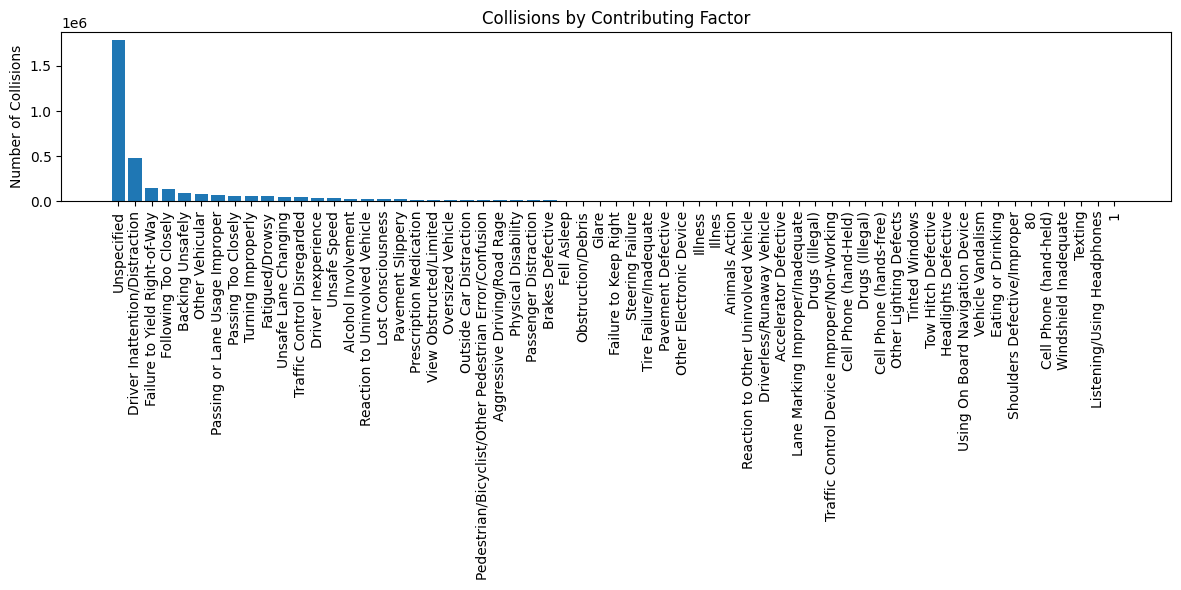

In [180]:
# Select the relevant columns
factor_cols = [
    'CONTRIBUTING FACTOR VEHICLE 1',
    'CONTRIBUTING FACTOR VEHICLE 2',
    'CONTRIBUTING FACTOR VEHICLE 3',
    'CONTRIBUTING FACTOR VEHICLE 4',
    'CONTRIBUTING FACTOR VEHICLE 5'
]

# Melt (flatten) the dataframe
flat_df = df.melt(
    id_vars=['COLLISION_ID', 'NUMBER OF PERSONS INJURED'],
    value_vars=factor_cols,
    var_name='Factor_Vehicle',
    value_name='Contributing_Factor'
)

# Drop rows where factor is missing
flat_df = flat_df.dropna(subset=['Contributing_Factor'])
human_df = flat_df.groupby(['Contributing_Factor'])['COLLISION_ID'].nunique().reset_index().sort_values(by=('COLLISION_ID'), ascending=False)
plt.figure(figsize=(12,6))
plt.bar(
    human_df['Contributing_Factor'],
    human_df['COLLISION_ID']
)
plt.xticks(rotation=90)
plt.ylabel('Number of Collisions')
plt.title('Collisions by Contributing Factor')
plt.tight_layout()
plt.show()

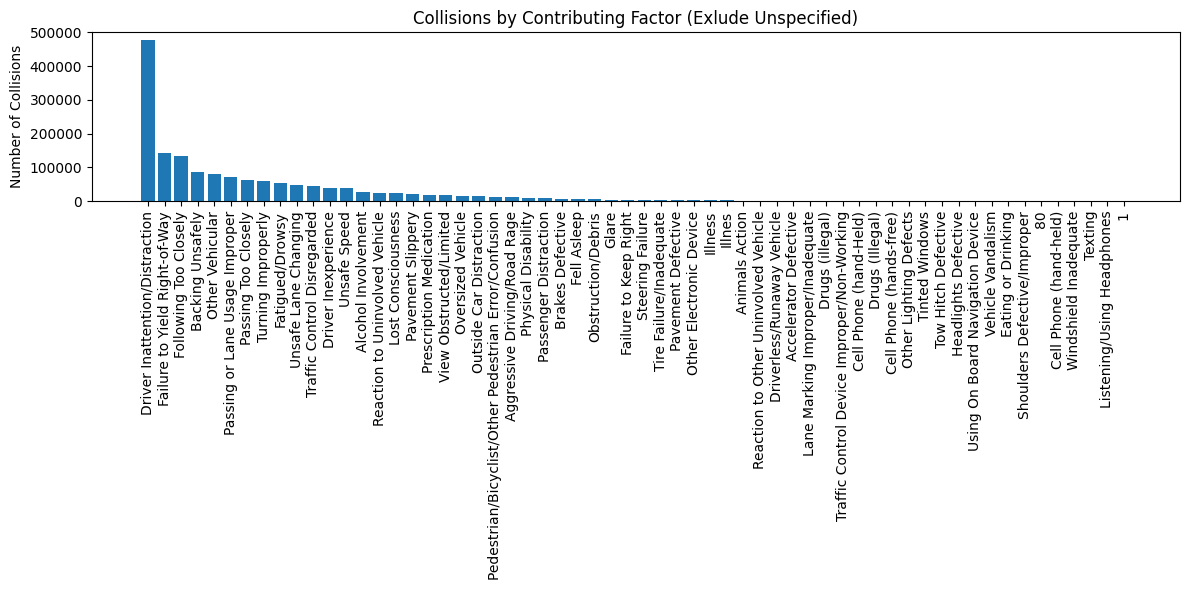

In [181]:
plt.figure(figsize=(12,6))
plt.bar(
    human_df[human_df['Contributing_Factor']!='Unspecified']['Contributing_Factor'],
    human_df[human_df['Contributing_Factor']!='Unspecified']['COLLISION_ID']
)
plt.xticks(rotation=90)
plt.ylabel('Number of Collisions')
plt.title('Collisions by Contributing Factor (Exlude Unspecified)')
plt.tight_layout()
plt.show()

In [182]:
print(f'Unique Collision Factor Values: {human_df['Contributing_Factor'].nunique()}')

Unique Collision Factor Values: 61


In [183]:
df['NUMBER OF PERSONS INJURED'] = pd.to_numeric(df['NUMBER OF PERSONS INJURED'], errors='coerce')
df['NUMBER OF PERSONS KILLED'] = pd.to_numeric(df['NUMBER OF PERSONS KILLED'], errors='coerce')

In [184]:
df.groupby(['NUMBER OF PERSONS INJURED'])['COLLISION_ID'].nunique().reset_index().sort_values(by=('COLLISION_ID'), ascending=False)

NUMBER OF PERSONS INJURED  COLLISION_ID
0                         0.0       1680405
1                         1.0        416646
2                         2.0         78279
3                         3.0         25679
4                         4.0          9430
5                         5.0          3643
6                         6.0          1499
7                         7.0           628
8                         8.0           280
9                         9.0           143
10                       10.0            95
11                       11.0            57
12                       12.0            34
13                       13.0            29
15                       15.0            17
14                       14.0            11
16                       16.0             8
17                       17.0             8
18                       18.0             6
19                       19.0             4
20                       20.0             4
22                       22.0             3
24                       24.0             3
21                       21.0             1
23                       23.0             1
25                       25.0             1
26                       27.0             1
27                       31.0             1
28                       32.0             1
29                       34.0             1
30                       40.0             1
31                       43.0             1

In [185]:
df.groupby(['NUMBER OF PERSONS KILLED'])['COLLISION_ID'].nunique().reset_index().sort_values(by=('COLLISION_ID'), ascending=False)

NUMBER OF PERSONS KILLED  COLLISION_ID
0                       0.0       2213541
1                       1.0          3254
2                       2.0            90
3                       3.0            15
4                       4.0             4
5                       5.0             2
6                       8.0             1

In [186]:
df['COLLISION_ID'].nunique()

2216938

(array([ 73375.,  39317.,  30300.,  26747.,  30326.,  32807.,  50123.,
         68490., 121445., 116544., 108948., 113652., 120893., 126719.,
        146367., 138011., 158166., 154964., 136365., 112673.,  94435.,
         80730., 135541.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]),
 <BarContainer object of 23 artists>)

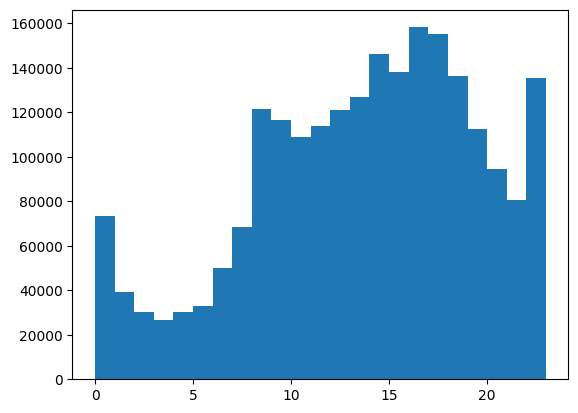

In [187]:
plt.hist(df['CRASH TIME'].apply(lambda x: int(x.split(':')[0])), bins=range(0, 24))

In [188]:
df['CRASH TIME'] = df['CRASH TIME'].apply(lambda x: int(x.split(':')[0]))

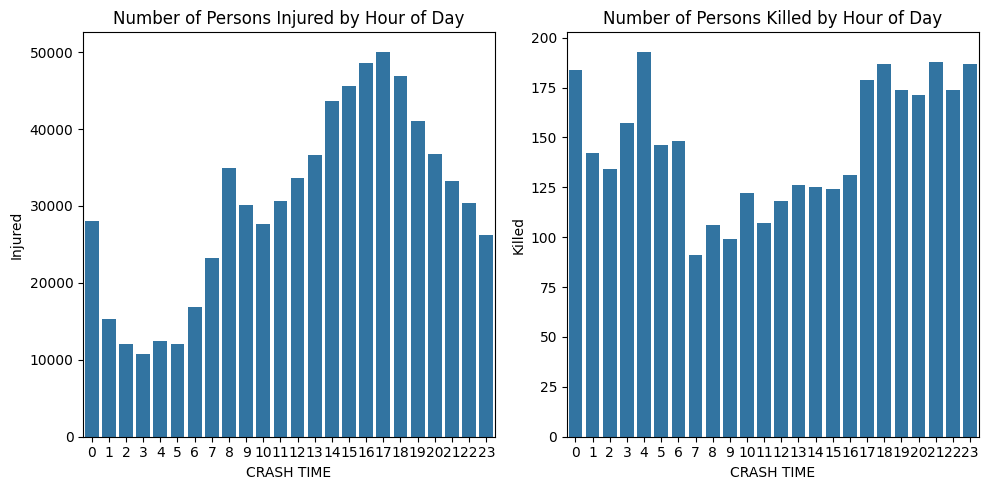

In [189]:
# --- Aggregate by hour ---
hourly_stats = df.groupby('CRASH TIME').agg({
    'COLLISION_ID': 'nunique',
    'NUMBER OF PERSONS INJURED': 'sum',
    'NUMBER OF PERSONS KILLED': 'sum'
}).reset_index()

hourly_stats.rename(columns={
    'COLLISION_ID': 'Number of Accidents',
    'NUMBER OF PERSONS INJURED': 'Number Injured',
    'NUMBER OF PERSONS KILLED': 'Number Killed'
}, inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
# Plot 2: Number Injured
sns.barplot(data=hourly_stats, x='CRASH TIME', y='Number Injured', ax=axes[0])
axes[0].set_title('Number of Persons Injured by Hour of Day')
axes[0].set_ylabel('Injured')

# Plot 3: Number Killed
sns.barplot(data=hourly_stats, x='CRASH TIME', y='Number Killed', ax=axes[1])
axes[1].set_title('Number of Persons Killed by Hour of Day')
axes[1].set_xlabel('CRASH TIME')
axes[1].set_ylabel('Killed')

plt.tight_layout()
plt.show()



In [190]:
hourly_stats['avg_injured_per_crash'] = hourly_stats['Number Injured'] / hourly_stats['Number of Accidents']
hourly_stats['avg_killed_per_crash'] = hourly_stats['Number Killed'] / hourly_stats['Number of Accidents']

Text(0, 0.5, 'Killed')

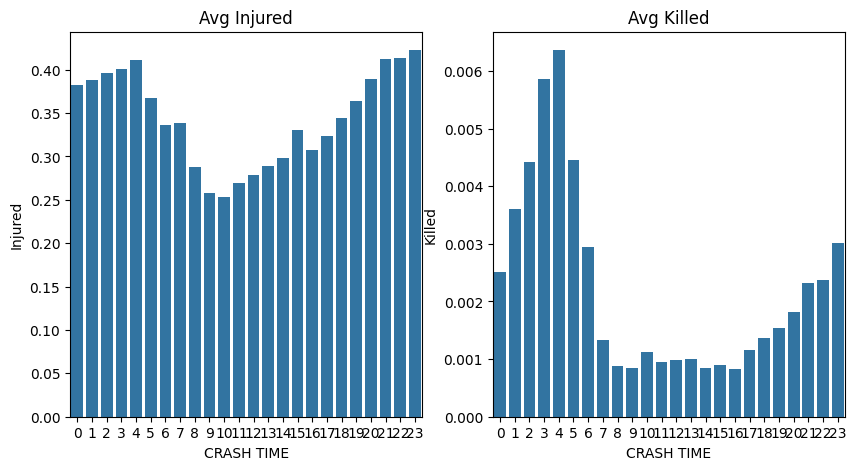

In [191]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
# Plot 2: Number Injured
sns.barplot(data=hourly_stats, x='CRASH TIME', y='avg_injured_per_crash', ax=axes[0])
axes[0].set_title('Avg Injured')
axes[0].set_ylabel('Injured')

# Plot 3: Number Killed
sns.barplot(data=hourly_stats, x='CRASH TIME', y='avg_killed_per_crash', ax=axes[1])
axes[1].set_title('Avg Killed')
axes[1].set_xlabel('CRASH TIME')
axes[1].set_ylabel('Killed')

In [192]:
df.head()

CRASH DATE  CRASH TIME   BOROUGH ZIP CODE  LATITUDE  LONGITUDE  \
0 2021-09-11           2       NaN      NaN       NaN        NaN   
1 2022-03-26          11       NaN      NaN       NaN        NaN   
2 2023-11-01           1  BROOKLYN  11230.0  40.62179 -73.970024   
3 2022-06-29           6       NaN      NaN       NaN        NaN   
4 2022-09-21          13       NaN      NaN       NaN        NaN   

                 LOCATION           ON STREET NAME CROSS STREET NAME  \
0                     NaN    WHITESTONE EXPRESSWAY         20 AVENUE   
1                     NaN  QUEENSBORO BRIDGE UPPER               NaN   
2  (40.62179, -73.970024)            OCEAN PARKWAY          AVENUE K   
3                     NaN       THROGS NECK BRIDGE               NaN   
4                     NaN          BROOKLYN BRIDGE               NaN   

  OFF STREET NAME  ...  CONTRIBUTING FACTOR VEHICLE 4  \
0             NaN  ...                            NaN   
1             NaN  ...                            NaN   
2             NaN  ...                            NaN   
3             NaN  ...                            NaN   
4             NaN  ...                            NaN   

   CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
0                            NaN       4455765   
1                            NaN       4513547   
2                            NaN       4675373   
3                            NaN       4541903   
4                            NaN       4566131   

                   VEHICLE TYPE CODE 1  VEHICLE TYPE CODE 2  \
0                                Sedan                Sedan   
1                                Sedan                  NaN   
2                                Moped                Sedan   
3                                Sedan        Pick-up Truck   
4  Station Wagon/Sport Utility Vehicle                  NaN   

   VEHICLE TYPE CODE 3  VEHICLE TYPE CODE 4  VEHICLE TYPE CODE 5  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                Sedan                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

       CRASH DATETIME DAY OF WEEK  
0 2021-09-11 02:39:00           5  
1 2022-03-26 11:45:00           5  
2 2023-11-01 01:29:00           2  
3 2022-06-29 06:55:00           2  
4 2022-09-21 13:21:00           2  

[5 rows x 31 columns]

## Weather Data EDA

In [193]:
weather_df = pd.read_csv('/content/drive/MyDrive/Project/NOAA_Weather_2012_2025_NYC.csv', parse_dates=['DATE'])[['NAME', 'DATE', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
                                                                                                                 'TMIN', 'TAVG', 'AWND', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05',
                                                                                                                 'WT06', 'WT08', 'WT09', 'WT11']].rename(columns={'LATITUDE':'WEATHER_LAT',
                                                                                                                                                                  'LONGITUDE':'WEATHER_LONG',
                                                                                                                                                                  'WT01':'IS_FOG',
                                                                                                                                                                  'WT02':'IS_HEAVY_FOG',
                                                                                                                                                                  'WT03':'IS_THUNDER',
                                                                                                                                                                  'WT04':'IS_SLEET',
                                                                                                                                                                  'WT05': 'IS_HAIL',
                                                                                                                                                                  'WT06':'IS_GLAZE',
                                                                                                                                                                  'WT08':'IS_HAZE',
                                                                                                                                                                  'WT09':'IS_DRIFT_SNOW',
                                                                                                                                                                  'WT11':'IS_HIGH_WIND'})

In [194]:
print("Dataset size:")
print(f'{weather_df.shape[0]} rows')
print(f'{weather_df.shape[1]} columns')

Dataset size:
100235 rows
18 columns


In [195]:

weather_df.dtypes

NAME                     object
DATE             datetime64[ns]
PRCP                    float64
SNOW                    float64
SNWD                    float64
TMAX                    float64
TMIN                    float64
TAVG                    float64
AWND                    float64
IS_FOG                  float64
IS_HEAVY_FOG            float64
IS_THUNDER              float64
IS_SLEET                float64
IS_HAIL                 float64
IS_GLAZE                float64
IS_HAZE                 float64
IS_DRIFT_SNOW           float64
IS_HIGH_WIND            float64
dtype: object

In [196]:
#Trying to join individual crashes to even just station lat/long only on date crashes all available RAM
#so instead take the average of all stations with non-null values
weather_mean_by_date = weather_df.groupby(['DATE'])[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TAVG', 'AWND']].mean()
weather_event_by_date = weather_df.groupby(['DATE'])[['IS_FOG', 'IS_HEAVY_FOG', 'IS_THUNDER', 'IS_SLEET', 'IS_HAIL', 'IS_GLAZE', 'IS_HAZE', 'IS_DRIFT_SNOW', 'IS_HIGH_WIND']].max()
daily_weather = pd.concat([weather_mean_by_date, weather_event_by_date], axis=1).reset_index()

In [197]:
#daily_weather.isna().sum()
daily_weather.fillna(value=0)

DATE      PRCP  SNOW  SNWD       TMAX       TMIN  TAVG     AWND  \
0    2012-07-01  0.003000   0.0   0.0  94.083333  70.833333   0.0  7.18625   
1    2012-07-02  0.034444   0.0   0.0  90.000000  67.500000   0.0  6.65375   
2    2012-07-03  0.000000   0.0   0.0  89.666667  66.833333   0.0  6.06500   
3    2012-07-04  0.050000   0.0   0.0  91.416667  70.083333   0.0  6.96250   
4    2012-07-05  0.023000   0.0   0.0  94.083333  73.583333   0.0  7.43750   
...         ...       ...   ...   ...        ...        ...   ...      ...   
4861 2025-10-22  0.258947   0.0   0.0  65.181818  50.000000   0.0  0.00000   
4862 2025-10-23  0.001053   0.0   0.0  61.454545  46.000000   0.0  0.00000   
4863 2025-10-24  0.000000   0.0   0.0  60.636364  43.000000   0.0  0.00000   
4864 2025-10-25  0.000000   0.0   0.0  59.636364  42.363636   0.0  0.00000   
4865 2025-10-26  0.000000   0.0   0.0  57.666667  41.333333   0.0  0.00000   

      IS_FOG  IS_HEAVY_FOG  IS_THUNDER  IS_SLEET  IS_HAIL  IS_GLAZE  IS_HAZE  \
0        0.0           0.0         1.0       0.0      0.0       0.0      1.0   
1        0.0           0.0         1.0       0.0      0.0       0.0      1.0   
2        0.0           0.0         0.0       0.0      0.0       0.0      0.0   
3        1.0           0.0         1.0       0.0      0.0       0.0      1.0   
4        1.0           0.0         1.0       0.0      0.0       0.0      1.0   
...      ...           ...         ...       ...      ...       ...      ...   
4861     0.0           0.0         0.0       0.0      0.0       0.0      0.0   
4862     0.0           0.0         0.0       0.0      0.0       0.0      0.0   
4863     0.0           0.0         0.0       0.0      0.0       0.0      0.0   
4864     0.0           0.0         0.0       0.0      0.0       0.0      0.0   
4865     0.0           0.0         0.0       0.0      0.0       0.0      0.0   

      IS_DRIFT_SNOW  IS_HIGH_WIND  
0               0.0           0.0  
1               0.0           0.0  
2               0.0           0.0  
3               0.0           0.0  
4               0.0           0.0  
...             ...           ...  
4861            0.0           0.0  
4862            0.0           0.0  
4863            0.0           0.0  
4864            0.0           0.0  
4865            0.0           0.0  

[4866 rows x 17 columns]

In [198]:
daily_weather.describe()

DATE         PRCP         SNOW         SNWD  \
count                 4866  4866.000000  4866.000000  4866.000000   
mean   2019-02-27 12:00:00     0.132106     0.074062     0.310114   
min    2012-07-01 00:00:00     0.000000     0.000000     0.000000   
25%    2015-10-30 06:00:00     0.000000     0.000000     0.000000   
50%    2019-02-27 12:00:00     0.011500     0.000000     0.000000   
75%    2022-06-27 18:00:00     0.147107     0.000000     0.000000   
max    2025-10-26 00:00:00     2.826000    13.825000    18.300000   
std                    NaN     0.266030     0.533101     1.408551   

              TMAX         TMIN         TAVG         AWND  IS_FOG  \
count  4866.000000  4866.000000  4532.000000  4805.000000  2691.0   
mean     63.751976    47.038402    56.885738     8.066871     1.0   
min      13.545455    -0.333333     8.000000     1.621250     1.0   
25%      48.750000    33.833333    43.333333     5.786250     1.0   
50%      64.916667    47.083333    57.333333     7.412857     1.0   
75%      79.583333    61.833333    72.333333     9.650000     1.0   
max      98.833333    79.416667    91.000000    29.081429     1.0   
std      17.810832    16.571309    16.902608     3.233569     0.0   

       IS_HEAVY_FOG  IS_THUNDER  IS_SLEET  IS_HAIL  IS_GLAZE  IS_HAZE  \
count         611.0       791.0     183.0     33.0      78.0   1705.0   
mean            1.0         1.0       1.0      1.0       1.0      1.0   
min             1.0         1.0       1.0      1.0       1.0      1.0   
25%             1.0         1.0       1.0      1.0       1.0      1.0   
50%             1.0         1.0       1.0      1.0       1.0      1.0   
75%             1.0         1.0       1.0      1.0       1.0      1.0   
max             1.0         1.0       1.0      1.0       1.0      1.0   
std             0.0         0.0       0.0      0.0       0.0      0.0   

       IS_DRIFT_SNOW  IS_HIGH_WIND  
count           23.0         104.0  
mean             1.0           1.0  
min              1.0           1.0  
25%              1.0           1.0  
50%              1.0           1.0  
75%              1.0           1.0  
max              1.0           1.0  
std              0.0           0.0

In [199]:
#Days with each weather event
daily_weather[['IS_FOG', 'IS_HEAVY_FOG', 'IS_THUNDER', 'IS_SLEET', 'IS_HAIL', 'IS_GLAZE', 'IS_HAZE', 'IS_DRIFT_SNOW', 'IS_HIGH_WIND']].sum()

IS_FOG           2691.0
IS_HEAVY_FOG      611.0
IS_THUNDER        791.0
IS_SLEET          183.0
IS_HAIL            33.0
IS_GLAZE           78.0
IS_HAZE          1705.0
IS_DRIFT_SNOW      23.0
IS_HIGH_WIND      104.0
dtype: float64

In [200]:
#Number of days with any precipitation
days_precip = daily_weather[daily_weather['PRCP']>0.01].shape[0]
days_snow = daily_weather[daily_weather['SNOW']>0.01].shape[0]
days_total = daily_weather.shape[0]
print(f'Days with Precipitation: {days_precip/days_total*100}%')
print(f'Days with Snow: {days_snow/days_total*100}%')

Days with Precipitation: 50.78092889436909%
Days with Snow: 7.233867653103165%


In [201]:
crashes_with_weather = pd.merge(df, daily_weather, how='left', left_on ='CRASH DATE', right_on = 'DATE')
for col in ['IS_FOG', 'IS_HEAVY_FOG', 'IS_THUNDER', 'IS_SLEET', 'IS_HAIL', 'IS_GLAZE', 'IS_HAZE', 'IS_DRIFT_SNOW', 'IS_HIGH_WIND']:
  crashes_with_weather[col] = crashes_with_weather[col].fillna(0)

In [202]:
crashes_with_weather.head()

CRASH DATE  CRASH TIME   BOROUGH ZIP CODE  LATITUDE  LONGITUDE  \
0 2021-09-11           2       NaN      NaN       NaN        NaN   
1 2022-03-26          11       NaN      NaN       NaN        NaN   
2 2023-11-01           1  BROOKLYN  11230.0  40.62179 -73.970024   
3 2022-06-29           6       NaN      NaN       NaN        NaN   
4 2022-09-21          13       NaN      NaN       NaN        NaN   

                 LOCATION           ON STREET NAME CROSS STREET NAME  \
0                     NaN    WHITESTONE EXPRESSWAY         20 AVENUE   
1                     NaN  QUEENSBORO BRIDGE UPPER               NaN   
2  (40.62179, -73.970024)            OCEAN PARKWAY          AVENUE K   
3                     NaN       THROGS NECK BRIDGE               NaN   
4                     NaN          BROOKLYN BRIDGE               NaN   

  OFF STREET NAME  ...     AWND  IS_FOG  IS_HEAVY_FOG  IS_THUNDER  IS_SLEET  \
0             NaN  ...  5.70375     0.0           0.0         0.0       0.0   
1             NaN  ...  9.75875     0.0           0.0         1.0       0.0   
2             NaN  ...  9.75750     1.0           0.0         0.0       0.0   
3             NaN  ...  6.01375     0.0           0.0         0.0       0.0   
4             NaN  ...  6.06750     0.0           0.0         0.0       0.0   

   IS_HAIL  IS_GLAZE  IS_HAZE IS_DRIFT_SNOW IS_HIGH_WIND  
0      0.0       0.0      0.0           0.0          0.0  
1      0.0       0.0      0.0           0.0          0.0  
2      0.0       0.0      0.0           0.0          0.0  
3      0.0       0.0      1.0           0.0          0.0  
4      0.0       0.0      0.0           0.0          0.0  

[5 rows x 48 columns]

(array([ 10804.,  40794., 124987., 249282., 295080., 291090., 289806.,
        337791., 358108.,  57329.]),
 array([ 8. , 16.3, 24.6, 32.9, 41.2, 49.5, 57.8, 66.1, 74.4, 82.7, 91. ]),
 <BarContainer object of 10 artists>)

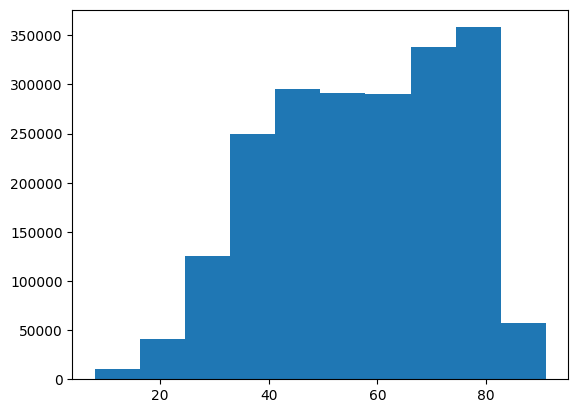

In [203]:
plt.hist(crashes_with_weather['TAVG'])

(array([1.867562e+06, 1.924260e+05, 8.720500e+04, 4.187200e+04,
        1.193300e+04, 6.983000e+03, 3.235000e+03, 3.765000e+03,
        6.110000e+02, 9.850000e+02]),
 array([0.    , 0.2826, 0.5652, 0.8478, 1.1304, 1.413 , 1.6956, 1.9782,
        2.2608, 2.5434, 2.826 ]),
 <BarContainer object of 10 artists>)

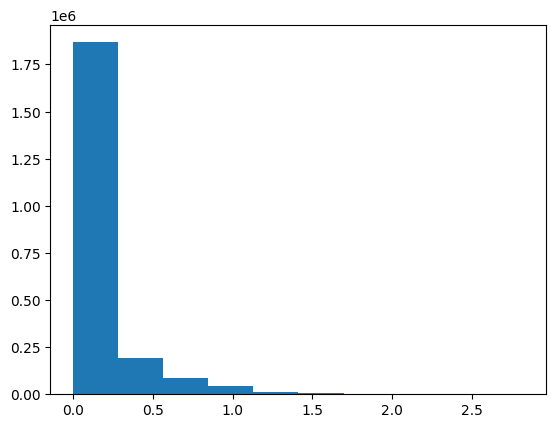

In [204]:
plt.hist(crashes_with_weather['PRCP'])

(array([2.178376e+06, 1.663000e+04, 1.205900e+04, 4.795000e+03,
        2.523000e+03, 4.030000e+02, 8.720000e+02, 5.170000e+02,
        0.000000e+00, 4.020000e+02]),
 array([ 0.    ,  1.3825,  2.765 ,  4.1475,  5.53  ,  6.9125,  8.295 ,
         9.6775, 11.06  , 12.4425, 13.825 ]),
 <BarContainer object of 10 artists>)

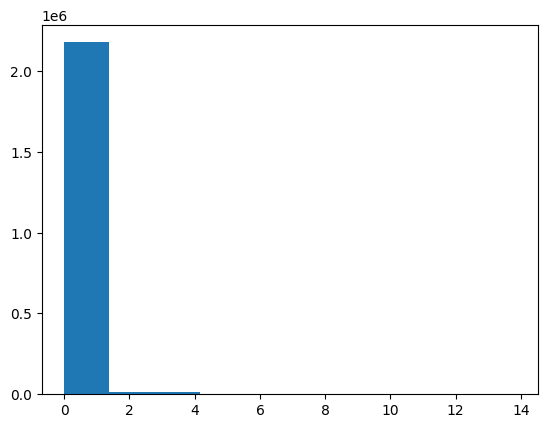

In [205]:
plt.hist(crashes_with_weather['SNOW'])

(array([2.103098e+06, 4.081500e+04, 2.045000e+04, 2.281600e+04,
        1.477600e+04, 5.717000e+03, 3.695000e+03, 2.725000e+03,
        1.310000e+03, 1.175000e+03]),
 array([ 0.  ,  1.83,  3.66,  5.49,  7.32,  9.15, 10.98, 12.81, 14.64,
        16.47, 18.3 ]),
 <BarContainer object of 10 artists>)

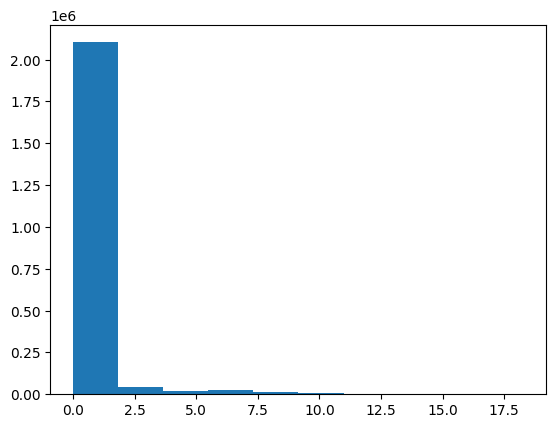

In [206]:
plt.hist(crashes_with_weather['SNWD'])

(array([1.69495e+05, 8.34252e+05, 6.85152e+05, 2.84306e+05, 1.54280e+05,
        5.47410e+04, 1.56820e+04, 3.06700e+03, 7.00000e+02, 2.98000e+02]),
 array([ 1.62125   ,  4.36726786,  7.11328571,  9.85930357, 12.60532143,
        15.35133929, 18.09735714, 20.843375  , 23.58939286, 26.33541071,
        29.08142857]),
 <BarContainer object of 10 artists>)

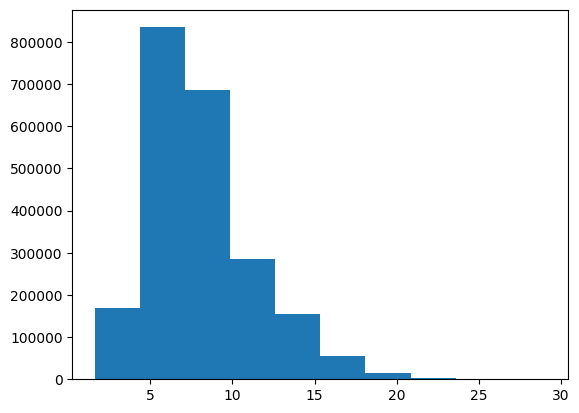

In [207]:
plt.hist(crashes_with_weather['AWND'])

## Traffic Volume EDA

In [208]:
traffic_volume_full = pd.read_csv('/content/drive/MyDrive/Project/Automated_Traffic_Volume_Counts.csv')

In [209]:
traffic_volume = traffic_volume_full[(traffic_volume_full.Yr >= 2021) & (traffic_volume_full.Yr <= 2023)]

In [210]:
print("Dataset size:")
print(f'{traffic_volume_full.shape[0]} rows')
print(f'{traffic_volume_full.shape[1]} columns')

Dataset size:
1838386 rows
14 columns


In [211]:
traffic_volume_full['datestring'] = traffic_volume_full['Yr'].astype(str) + '-' + traffic_volume_full['M'].astype(str) + '-' + traffic_volume_full['D'].astype(str)
traffic_volume_full['Date'] = pd.to_datetime(traffic_volume_full['datestring'])

In [212]:
traffic_volume.head()

RequestID      Boro    Yr  M   D  HH  MM  Vol  SegmentID  \
210      35707  Brooklyn  2023  1  14  12   0  197     151516   
211      35707  Brooklyn  2023  1  14  12  15  233     151516   
212      35707  Brooklyn  2023  1  14  12  30  213     151516   
213      35707  Brooklyn  2023  1  14  12  45  187     151516   
214      35707  Brooklyn  2023  1  14  13   0  192     151516   

                                           WktGeom           street    fromSt  \
210  POINT (1004852.0243700822 162537.73371917408)  FLATBUSH AVENUE  Dead end   
211  POINT (1004852.0243700822 162537.73371917408)  FLATBUSH AVENUE  Dead end   
212  POINT (1004852.0243700822 162537.73371917408)  FLATBUSH AVENUE  Dead end   
213  POINT (1004852.0243700822 162537.73371917408)  FLATBUSH AVENUE  Dead end   
214  POINT (1004852.0243700822 162537.73371917408)  FLATBUSH AVENUE  Dead end   

         toSt Direction  
210  Avenue S        NB  
211  Avenue S        NB  
212  Avenue S        NB  
213  Avenue S        NB  
214  Avenue S        NB

In [213]:
daily_traffic = traffic_volume_full[['Date', 'Vol']].groupby(['Date']).mean()

In [214]:
print(f'Min Date: {daily_traffic.index.min()}')
print(f'Min Date: {daily_traffic.index.max()}')

Min Date: 2000-01-01 00:00:00
Min Date: 2025-12-11 00:00:00


In [215]:
daily_traffic_12_25 = daily_traffic[daily_traffic.index >= '2012-07-01']

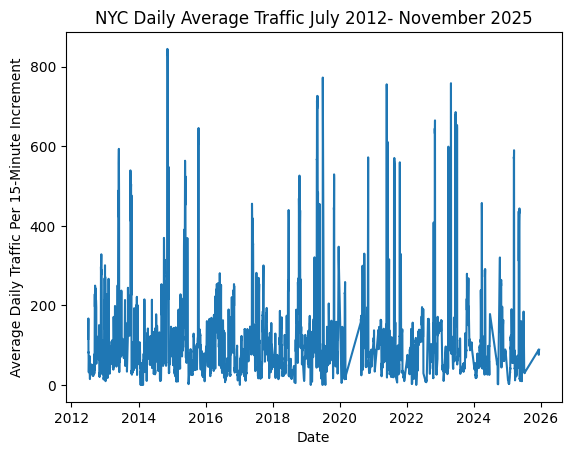

In [216]:
plt.plot(daily_traffic_12_25.index, daily_traffic_12_25['Vol'])
plt.xlabel('Date')
plt.ylabel('Average Daily Traffic Per 15-Minute Increment')
plt.title('NYC Daily Average Traffic July 2012- November 2025')
plt.show()

## EDA Specific to Crashes Per Day (Research Question 1)

In [217]:
daily_crashes_prelim = pd.concat([crashes_with_weather.groupby(['CRASH DATE']).count()['COLLISION_ID'],
                           crashes_with_weather[['CRASH DATE','PRCP', 'SNOW',	'SNWD',	'TMAX',	'TMIN',	'TAVG',	'AWND',	'IS_FOG',
                                                 'IS_HEAVY_FOG', 'IS_THUNDER', 'IS_SLEET', 'IS_HAIL', 'IS_GLAZE', 'IS_HAZE', 'IS_DRIFT_SNOW',
                                                 'IS_HIGH_WIND']].groupby(['CRASH DATE']).mean()], axis=1)
daily_crashes = pd.merge(daily_crashes_prelim, daily_traffic, how='left', left_index=True, right_index=True)
daily_crashes.rename(columns={'COLLISION_ID': 'COLLISION COUNT', 'Vol': 'AVG_TRAFFIC_VOL'}, inplace=True)
daily_crashes['DAY_OF_WEEK'] = daily_crashes.index.dayofweek.astype('category')
daily_crashes['MONTH'] = daily_crashes.index.month.astype('category')
daily_crashes['YEAR'] = daily_crashes.index.year.astype('category')
daily_crashes['IS_WEEKEND'] = np.where((daily_crashes['DAY_OF_WEEK'] == 5) | (daily_crashes['DAY_OF_WEEK'] == 6), 1, 0)


In [218]:
#Check for nulls
daily_crashes.isna().sum()

COLLISION COUNT       0
PRCP                  2
SNOW                  2
SNWD                  2
TMAX                  2
TMIN                  2
TAVG                336
AWND                 63
IS_FOG                0
IS_HEAVY_FOG          0
IS_THUNDER            0
IS_SLEET              0
IS_HAIL               0
IS_GLAZE              0
IS_HAZE               0
IS_DRIFT_SNOW         0
IS_HIGH_WIND          0
AVG_TRAFFIC_VOL    1138
DAY_OF_WEEK           0
MONTH                 0
YEAR                  0
IS_WEEKEND            0
dtype: int64

In [219]:
#Impute nulls

#For TAVG, use the average of TMAX and TMIN
daily_crashes['TAVG'] = daily_crashes['TAVG'].fillna((daily_crashes['TMAX'] + daily_crashes['TMIN']) / 2)
#This leaves only two extra records (the most recent two days) with nulls, so remove these
daily_crashes.dropna(subset=['TAVG'], inplace=True)
#Impute missing average wind speed with the median
daily_crashes['AWND'] = daily_crashes['AWND'].fillna(daily_crashes['AWND'].median())

In [220]:
# fill null traffic volume by the average traffic volume of this hour in the same weekday of the same month, per Amelia's method
daily_crashes['YEAR'] = daily_crashes.index.year
group_means = (
    daily_crashes
    .groupby(['YEAR', 'MONTH', 'IS_WEEKEND'])['AVG_TRAFFIC_VOL']
    .mean()
)

daily_crashes['group_mean'] = daily_crashes.set_index(
    ['YEAR', 'MONTH', 'IS_WEEKEND']
).index.map(group_means)

daily_crashes['AVG_TRAFFIC_VOL'] = daily_crashes['AVG_TRAFFIC_VOL'].fillna(daily_crashes['group_mean'])

daily_crashes['AVG_TRAFFIC_VOL'] = (
    daily_crashes['AVG_TRAFFIC_VOL']
        .fillna(method='ffill')
        .fillna(method='bfill')
)
daily_crashes.drop(columns=['group_mean'], inplace=True)

/tmp/ipython-input-238488579.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['YEAR', 'MONTH', 'IS_WEEKEND'])['AVG_TRAFFIC_VOL']
/tmp/ipython-input-238488579.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
/tmp/ipython-input-238488579.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')


In [221]:
#Creating some new categorical variables
daily_crashes['PRECIP_GT_ONE_TENTH_IN'] = daily_crashes['PRCP'] > 0.1
daily_crashes['BELOW_FREEZING'] = (daily_crashes['TAVG']<= 32).astype('int')
daily_crashes['SNOW_ACCUM_2_IN'] = (daily_crashes['SNWD'] > 2).astype('int')

In [222]:
#Check for nulls again
daily_crashes.isna().sum()

COLLISION COUNT           0
PRCP                      0
SNOW                      0
SNWD                      0
TMAX                      0
TMIN                      0
TAVG                      0
AWND                      0
IS_FOG                    0
IS_HEAVY_FOG              0
IS_THUNDER                0
IS_SLEET                  0
IS_HAIL                   0
IS_GLAZE                  0
IS_HAZE                   0
IS_DRIFT_SNOW             0
IS_HIGH_WIND              0
AVG_TRAFFIC_VOL           0
DAY_OF_WEEK               0
MONTH                     0
YEAR                      0
IS_WEEKEND                0
PRECIP_GT_ONE_TENTH_IN    0
BELOW_FREEZING            0
SNOW_ACCUM_2_IN           0
dtype: int64

In [223]:
#Add Amelia's IS_HOLIDAY indicator variable
daily_crashes['IS_HOLIDAY'] = False

# Extract year, month, day
years = daily_crashes['YEAR']
def nth_weekday_of_month(year, month, weekday, n):
    """weekday: Monday=0 ... Sunday=6"""
    d = pd.Timestamp(year, month, 1)
    # Move forward until weekday matches
    while d.weekday() != weekday:
        d += pd.Timedelta(days=1)
    # Add 7*(n-1) days
    return d + pd.Timedelta(days=7*(n-1))
def last_weekday_of_month(year, month, weekday):
    d = pd.Timestamp(year, month + 1, 1) - pd.Timedelta(days=1)
    while d.weekday() != weekday:
        d -= pd.Timedelta(days=1)
    return d
years_unique = years.unique()
holiday_windows = []   # list of (start_date, end_date)
for y in years_unique:
    holiday_windows.append((pd.Timestamp(y,12,21), pd.Timestamp(y,12,27)))
for y in years_unique:
    holiday_windows.append((pd.Timestamp(y-1,12,31), pd.Timestamp(y,1,2)))
for y in years_unique:
    thanksgiving = nth_weekday_of_month(y, 11, weekday=3, n=4)  # Thursday=3
    start = thanksgiving - pd.Timedelta(days=1)  # Wednesday
    end = thanksgiving + pd.Timedelta(days=1)    # Friday
    holiday_windows.append((start, end))
for y in years_unique:
    mlk = nth_weekday_of_month(y, 1, weekday=0, n=3)
    holiday_windows.append((mlk, mlk))
for y in years_unique:
    pres = nth_weekday_of_month(y, 2, weekday=0, n=3)
    holiday_windows.append((pres, pres))
for y in years_unique:
    mem = last_weekday_of_month(y, 5, weekday=0)
    holiday_windows.append((mem, mem))
for y in years_unique:
    holiday_windows.append((pd.Timestamp(y,6,19), pd.Timestamp(y,6,19)))
for y in years_unique:
    holiday_windows.append((pd.Timestamp(y,7,3), pd.Timestamp(y,7,5)))
for y in years_unique:
    labor = nth_weekday_of_month(y, 9, weekday=0, n=1)
    start = labor - pd.Timedelta(days=2)  # Saturday before
    end = labor + pd.Timedelta(days=1)    # Tuesday after
    holiday_windows.append((start, end))
for y in years_unique:
    col = nth_weekday_of_month(y, 10, weekday=0, n=2)
    start = col - pd.Timedelta(days=2)
    end = col + pd.Timedelta(days=1)
    holiday_windows.append((start, end))
for y in years_unique:
    holiday_windows.append((pd.Timestamp(y,10,31), pd.Timestamp(y,10,31)))

for y in years_unique:
    holiday_windows.append((pd.Timestamp(y,3,17), pd.Timestamp(y,3,17)))

for y in years_unique:
    holiday_windows.append((pd.Timestamp(y,2,14), pd.Timestamp(y,2,14)))


holiday_mask = np.zeros(len(daily_crashes), dtype=bool)

for start, end in holiday_windows:
    holiday_mask |= (daily_crashes.index >= start) & (daily_crashes.index <= end)

daily_crashes['IS_HOLIDAY'] = holiday_mask.astype('int')

#'YEAR' column is  no longer needed
daily_crashes.drop(columns=['YEAR'], inplace=True)

In [224]:
daily_crashes.dtypes

COLLISION COUNT              int64
PRCP                       float64
SNOW                       float64
SNWD                       float64
TMAX                       float64
TMIN                       float64
TAVG                       float64
AWND                       float64
IS_FOG                     float64
IS_HEAVY_FOG               float64
IS_THUNDER                 float64
IS_SLEET                   float64
IS_HAIL                    float64
IS_GLAZE                   float64
IS_HAZE                    float64
IS_DRIFT_SNOW              float64
IS_HIGH_WIND               float64
AVG_TRAFFIC_VOL            float64
DAY_OF_WEEK               category
MONTH                     category
IS_WEEKEND                   int64
PRECIP_GT_ONE_TENTH_IN        bool
BELOW_FREEZING               int64
SNOW_ACCUM_2_IN              int64
IS_HOLIDAY                   int64
dtype: object

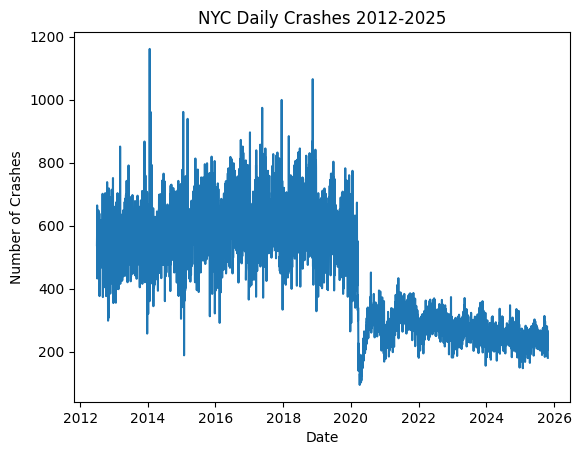

In [225]:
plt.plot(daily_crashes.index, daily_crashes['COLLISION COUNT'])
plt.xlabel('Date')
plt.ylabel('Number of Crashes')
plt.title('NYC Daily Crashes 2012-2025')
plt.show()

In [226]:
daily_crashes['2020-03-01':'2020-04-01']

COLLISION COUNT      PRCP  SNOW  SNWD       TMAX       TMIN  \
CRASH DATE                                                                
2020-03-01              423  0.000000   0.0   0.0  41.083333  23.750000   
2020-03-02              563  0.000000   0.0   0.0  52.666667  29.416667   
2020-03-03              550  0.126500   0.0   0.0  58.333333  42.250000   
2020-03-04              540  0.180000   0.0   0.0  57.416667  43.833333   
2020-03-05              529  0.009048   0.0   0.0  53.166667  37.583333   
2020-03-06              673  0.071905   0.0   0.0  47.750000  33.416667   
2020-03-07              515  0.176190   0.0   0.0  46.416667  34.333333   
2020-03-08              408  0.000952   0.0   0.0  54.454545  31.454545   
2020-03-09              546  0.000000   0.0   0.0  66.250000  37.750000   
2020-03-10              450  0.000476   0.0   0.0  67.500000  45.416667   
2020-03-11              473  0.004286   0.0   0.0  59.333333  40.916667   
2020-03-12              456  0.024286   0.0   0.0  51.750000  36.416667   
2020-03-13              551  0.232500   0.0   0.0  63.833333  42.000000   
2020-03-14              371  0.087368   0.0   0.0  60.333333  41.500000   
2020-03-15              331  0.000952   0.0   0.0  54.916667  39.250000   
2020-03-16              378  0.009048   0.0   0.0  47.250000  30.923077   
2020-03-17              374  0.106667   0.0   0.0  51.083333  36.769231   
2020-03-18              298  0.043333   0.0   0.0  53.083333  37.416667   
2020-03-19              339  0.930952   0.0   0.0  53.000000  39.461538   
2020-03-20              306  0.030000   0.0   0.0  67.833333  43.916667   
2020-03-21              238  0.000952   0.0   0.0  68.083333  40.000000   
2020-03-22              139  0.000000   0.0   0.0  45.909091  33.090909   
2020-03-23              226  0.417619   0.0   0.0  42.500000  34.833333   
2020-03-24              201  0.548095   0.0   0.0  50.166667  34.916667   
2020-03-25              168  0.002381   0.0   0.0  48.750000  37.916667   
2020-03-26              187  0.004500   0.0   0.0  54.416667  33.666667   
2020-03-27              195  0.001905   0.0   0.0  64.250000  42.250000   
2020-03-28              183  0.138571   0.0   0.0  56.250000  43.583333   
2020-03-29              146  0.312000   0.0   0.0  48.916667  44.583333   
2020-03-30              164  0.126000   0.0   0.0  49.666667  42.500000   
2020-03-31              158  0.100476   0.0   0.0  48.583333  40.416667   
2020-04-01              155  0.007143   0.0   0.0  52.666667  37.416667   

                 TAVG      AWND  IS_FOG  IS_HEAVY_FOG  ...  IS_DRIFT_SNOW  \
CRASH DATE                                             ...                  
2020-03-01  32.000000   9.87125     0.0           0.0  ...            0.0   
2020-03-02  44.000000   9.28500     0.0           0.0  ...            0.0   
2020-03-03  51.666667   7.66000     1.0           0.0  ...            0.0   
2020-03-04  50.666667  15.24000     1.0           0.0  ...            0.0   
2020-03-05  46.333333   8.75000     0.0           0.0  ...            0.0   
2020-03-06  41.666667   8.50125     1.0           0.0  ...            0.0   
2020-03-07  40.666667  13.42250     0.0           0.0  ...            0.0   
2020-03-08  44.000000   8.72500     0.0           0.0  ...            0.0   
2020-03-09  54.333333   9.22625     0.0           0.0  ...            0.0   
2020-03-10  57.333333  10.15125     0.0           0.0  ...            0.0   
2020-03-11  52.333333   6.60000     0.0           0.0  ...            0.0   
2020-03-12  45.666667   7.21375     1.0           0.0  ...            0.0   
2020-03-13  53.666667  13.03125     1.0           1.0  ...            0.0   
2020-03-14  51.000000  11.96875     1.0           0.0  ...            0.0   
2020-03-15  47.333333   7.83000     0.0           0.0  ...            0.0   
2020-03-16  39.666667  10.37500     0.0           0.0  ...            0.0   
2020-03-17  44.666667   6.76625     1.0           0.0  ...            0.0  

In [227]:
#There seems to be a huge difference in crash volume pre-COVID vs post-COVID so let's make a categorical variable to discern the difference
daily_crashes['PRECOVID'] = (daily_crashes.index < '2020-03-21').astype('int')

In [228]:
daily_crashes.corr()

COLLISION COUNT      PRCP      SNOW      SNWD  \
COLLISION COUNT                1.000000  0.034057  0.033391  0.037534   
PRCP                           0.034057  1.000000  0.164385  0.030902   
SNOW                           0.033391  0.164385  1.000000  0.491313   
SNWD                           0.037534  0.030902  0.491313  1.000000   
TMAX                           0.043352  0.005704 -0.222079 -0.341413   
TMIN                           0.034309  0.079963 -0.203042 -0.343997   
TAVG                           0.041168  0.033920 -0.216078 -0.341398   
AWND                           0.000453  0.235323  0.166317  0.080445   
IS_FOG                         0.100790  0.410602  0.113901  0.037644   
IS_HEAVY_FOG                   0.043417  0.254893  0.134352  0.046403   
IS_THUNDER                     0.014494  0.303782 -0.037703 -0.083019   
IS_SLEET                      -0.008960  0.147412  0.319672  0.223233   
IS_HAIL                       -0.005495  0.051662  0.036519 -0.004529   
IS_GLAZE                       0.021233  0.068818  0.194571  0.236608   
IS_HAZE                        0.091533  0.130720  0.105507  0.083893   
IS_DRIFT_SNOW                  0.006288  0.077817  0.531189  0.239600   
IS_HIGH_WIND                  -0.071424  0.243846  0.057198  0.009838   
AVG_TRAFFIC_VOL                0.087960 -0.018311 -0.050789 -0.064470   
DAY_OF_WEEK                   -0.096306 -0.008268  0.006065 -0.000837   
MONTH                          0.084976  0.016029 -0.132964 -0.253068   
IS_WEEKEND                    -0.166377 -0.006729  0.008945  0.002397   
PRECIP_GT_ONE_TENTH_IN         0.034082  0.684328  0.167171  0.038970   
BELOW_FREEZING                 0.028560 -0.075338  0.250057  0.403501   
SNOW_ACCUM_2_IN                0.038818  0.020654  0.436367  0.866058   
IS_HOLIDAY                    -0.068890 -0.008841 -0.012650 -0.011737   
PRECOVID                       0.886451 -0.007202  0.048223  0.067185   

                            TMAX      TMIN      TAVG      AWND    IS_FOG  \
COLLISION COUNT         0.043352  0.034309  0.041168  0.000453  0.100790   
PRCP                    0.005704  0.079963  0.033920  0.235323  0.410602   
SNOW                   -0.222079 -0.203042 -0.216078  0.166317  0.113901   
SNWD                   -0.341413 -0.343997 -0.341398  0.080445  0.037644   
TMAX                    1.000000  0.963702  0.990524 -0.326381  0.049025   
TMIN                    0.963702  1.000000  0.982892 -0.303309  0.130460   
TAVG                    0.990524  0.982892  1.000000 -0.313641  0.073599   
AWND                   -0.326381 -0.303309 -0.313641  1.000000  0.037048   
IS_FOG                  0.049025  0.130460  0.073599  0.037048  1.000000   
IS_HEAVY_FOG            0.000232  0.032209  0.001671 -0.042855  0.340678   
IS_THUNDER              0.368799  0.394952  0.370147 -0.034609  0.287424   
IS_SLEET               -0.248153 -0.219664 -0.237946  0.121458  0.147302   
IS_HAIL                -0.012207 -0.012208 -0.012204  0.044651  0.049106   
IS_GLAZE               -0.190050 -0.176079 -0.184130  0.059076  0.101582   
IS_HAZE                 0.049085  0.085101  0.054427 -0.065551  0.402955   
IS_DRIFT_SNOW          -0.126492 -0.121539 -0.124114  0.166352  0.055929   
IS_HIGH_WIND           -0.046154 -0.043058 -0.046221  0.232775  0.055692   
AVG_TRAFFIC_VOL         0.059094  0.047555  0.052736 -0.040444  0.019461   
DAY_OF_WEEK            -0.008830 -0.007920 -0.010285  0.017242 -0.017288   
MONTH                   0.277583  0.306882  0.305397 -0.186785 -0.005484   
IS_WEEKEND             -0.011238 -0.013579 -0.014369  0.001135 -0.031335   
PRECIP_GT_ONE_TENTH_IN  0.024419  0.111128  0.054361  0.175804  0.531217   
BELOW_FREEZING         -0.512073 -0.511439 -0.523962  0.155336 -0.092036   
SNOW_ACCUM_2_IN        -0.334053 -0.335101 -0.334442  0.082135  0.032029   
IS_HOLIDAY             -0.069101 -0.056533 -0.062164 -0.020382  0.011925   
PRECOVID               -0.071191 -0.069691 -0.073842  0.014569  0.089162   


In [229]:
#Transforming the prediction (number of crashes) using log sowill always predict a positive number
daily_crashes['LOG_COLLISION_COUNT'] = np.log(daily_crashes['COLLISION COUNT'])
daily_crashes.corr()
daily_crashes.corr()['LOG_COLLISION_COUNT']

COLLISION COUNT           0.985101
PRCP                      0.027402
SNOW                      0.028177
SNWD                      0.037856
TMAX                      0.045833
TMIN                      0.037210
TAVG                      0.043512
AWND                     -0.011789
IS_FOG                    0.100203
IS_HEAVY_FOG              0.041238
IS_THUNDER                0.011638
IS_SLEET                 -0.014484
IS_HAIL                  -0.009516
IS_GLAZE                  0.016785
IS_HAZE                   0.090208
IS_DRIFT_SNOW             0.007900
IS_HIGH_WIND             -0.078223
AVG_TRAFFIC_VOL           0.097582
DAY_OF_WEEK              -0.077820
MONTH                     0.089080
IS_WEEKEND               -0.136384
PRECIP_GT_ONE_TENTH_IN    0.027925
BELOW_FREEZING            0.029081
SNOW_ACCUM_2_IN           0.041131
IS_HOLIDAY               -0.063429
PRECOVID                  0.906285
LOG_COLLISION_COUNT       1.000000
Name: LOG_COLLISION_COUNT, dtype: float64

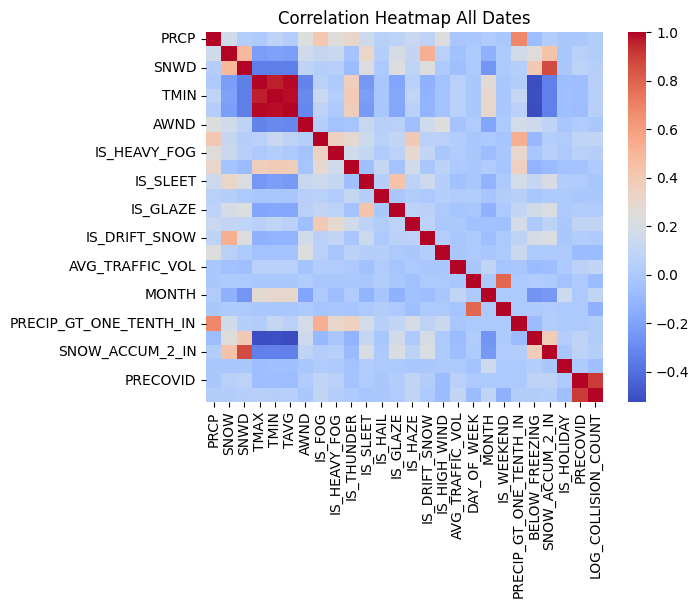

In [230]:
#Visualize correlation with a heatmap
sns.heatmap(daily_crashes.drop(columns='COLLISION COUNT').corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap All Dates")
plt.show()

### Pre-Covid Correlation

In [231]:
#COVID will almost certainly have some form of interaction. Let's try looking at correlation matrices before and after COVID to see if correlation is any stronger
daily_crashes_pre_covid = daily_crashes[:'2020-03-20']

In [232]:
daily_crashes_pre_covid.corr()
#Now we see a higher correlation with temperature especially.

COLLISION COUNT      PRCP      SNOW      SNWD  \
COLLISION COUNT                1.000000  0.107146 -0.015441 -0.043948   
PRCP                           0.107146  1.000000  0.207355  0.043770   
SNOW                          -0.015441  0.207355  1.000000  0.490141   
SNWD                          -0.043948  0.043770  0.490141  1.000000   
TMAX                           0.219567  0.008503 -0.233259 -0.361431   
TMIN                           0.197034  0.075850 -0.216435 -0.376248   
TAVG                           0.219162  0.033247 -0.227058 -0.365165   
AWND                           0.000439  0.238086  0.172907  0.090042   
IS_FOG                         0.052963  0.410401  0.120385  0.023745   
IS_HEAVY_FOG                   0.010651  0.276607  0.145737  0.047796   
IS_THUNDER                     0.113864  0.310422 -0.030513 -0.082962   
IS_SLEET                      -0.036300  0.194071  0.344993  0.239484   
IS_HAIL                        0.019299  0.056244  0.041964 -0.002038   
IS_GLAZE                       0.003472  0.092615  0.179555  0.206352   
IS_HAZE                        0.028680  0.108086  0.112914  0.092912   
IS_DRIFT_SNOW                 -0.049038  0.077961  0.479800  0.225811   
IS_HIGH_WIND                   0.017742  0.209181  0.063285  0.012642   
AVG_TRAFFIC_VOL                0.053049 -0.027612 -0.072701 -0.104772   
DAY_OF_WEEK                   -0.276769 -0.007720  0.013746  0.003415   
MONTH                          0.154653  0.011495 -0.143403 -0.286263   
IS_WEEKEND                    -0.451574 -0.008284  0.010417  0.004928   
PRECIP_GT_ONE_TENTH_IN         0.089585  0.716153  0.186702  0.047434   
BELOW_FREEZING                -0.082183 -0.085108  0.238516  0.411637   
SNOW_ACCUM_2_IN               -0.055212  0.026317  0.419465  0.867633   
IS_HOLIDAY                    -0.200350 -0.008289 -0.023468 -0.028387   
PRECOVID                            NaN       NaN       NaN       NaN   
LOG_COLLISION_COUNT            0.989891  0.098288 -0.037082 -0.052710   

                            TMAX      TMIN      TAVG      AWND    IS_FOG  \
COLLISION COUNT         0.219567  0.197034  0.219162  0.000439  0.052963   
PRCP                    0.008503  0.075850  0.033247  0.238086  0.410401   
SNOW                   -0.233259 -0.216435 -0.227058  0.172907  0.120385   
SNWD                   -0.361431 -0.376248 -0.365165  0.090042  0.023745   
TMAX                    1.000000  0.966425  0.991040 -0.327358  0.072758   
TMIN                    0.966425  1.000000  0.984234 -0.302588  0.146333   
TAVG                    0.991040  0.984234  1.000000 -0.311772  0.095088   
AWND                   -0.327358 -0.302588 -0.311772  1.000000  0.043970   
IS_FOG                  0.072758  0.146333  0.095088  0.043970  1.000000   
IS_HEAVY_FOG           -0.018628  0.011575 -0.015921 -0.046323  0.334414   
IS_THUNDER              0.366677  0.393951  0.366813 -0.040425  0.292136   
IS_SLEET               -0.243753 -0.217503 -0.234874  0.136302  0.151657   
IS_HAIL                -0.005237 -0.004628 -0.005692  0.040109  0.055498   
IS_GLAZE               -0.190487 -0.182165 -0.186774  0.064326  0.105764   
IS_HAZE                 0.056902  0.083817  0.058892 -0.063161  0.370639   
IS_DRIFT_SNOW          -0.140495 -0.139537 -0.138132  0.185105  0.057650   
IS_HIGH_WIND           -0.022336 -0.012191 -0.020081  0.187480  0.061929   
AVG_TRAFFIC_VOL         0.066221  0.060329  0.059845 -0.033771  0.009028   
DAY_OF_WEEK            -0.011849 -0.007100 -0.009284  0.008508 -0.037077   
MONTH                   0.279916  0.316662  0.308428 -0.169155  0.020882   
IS_WEEKEND             -0.008526 -0.010796 -0.009296 -0.016153 -0.047233   
PRECIP_GT_ONE_TENTH_IN  0.024883  0.106239  0.053731  0.187233  0.514345   
BELOW_FREEZING         -0.545135 -0.547223 -0.556434  0.154037 -0.110206   
SNOW_ACCUM_2_IN        -0.358756 -0.370902 -0.362427  0.096444  0.010208   
IS_HOLIDAY             -0.061493 -0.046734 -0.055570 -0.012995  0.006819   
PRE

In [233]:
daily_crashes_pre_covid.corr()['LOG_COLLISION_COUNT']

COLLISION COUNT           0.989891
PRCP                      0.098288
SNOW                     -0.037082
SNWD                     -0.052710
TMAX                      0.232364
TMIN                      0.209820
TAVG                      0.231684
AWND                     -0.011915
IS_FOG                    0.051125
IS_HEAVY_FOG              0.002297
IS_THUNDER                0.117075
IS_SLEET                 -0.047208
IS_HAIL                   0.020715
IS_GLAZE                 -0.002245
IS_HAZE                   0.027374
IS_DRIFT_SNOW            -0.063424
IS_HIGH_WIND              0.014996
AVG_TRAFFIC_VOL           0.056748
DAY_OF_WEEK              -0.283078
MONTH                     0.153344
IS_WEEKEND               -0.446371
PRECIP_GT_ONE_TENTH_IN    0.083041
BELOW_FREEZING           -0.093291
SNOW_ACCUM_2_IN          -0.062110
IS_HOLIDAY               -0.223703
PRECOVID                       NaN
LOG_COLLISION_COUNT       1.000000
Name: LOG_COLLISION_COUNT, dtype: float64

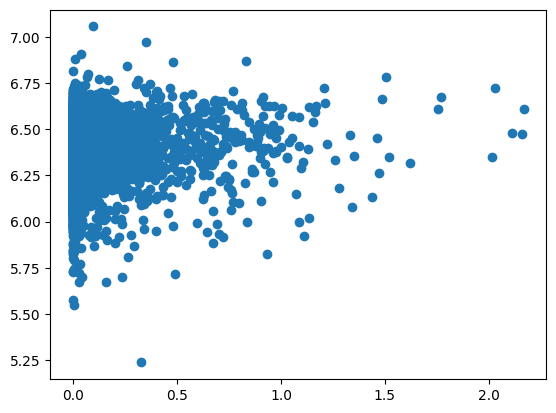

In [234]:
plt.scatter(daily_crashes_pre_covid['PRCP'], daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


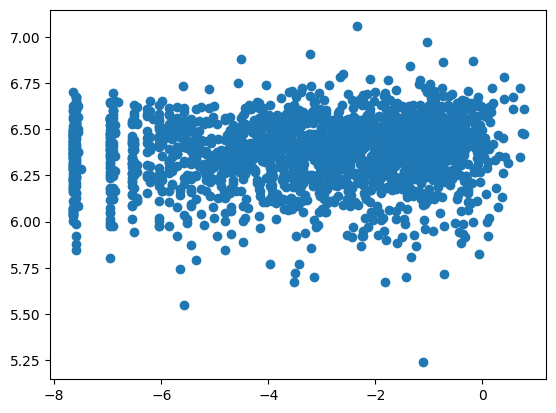

In [235]:
#This seems very left-skewed. Let's try taking the log to see if that results in a more linear relationship.
plt.scatter(np.log(daily_crashes_pre_covid['PRCP']), daily_crashes_pre_covid['LOG_COLLISION_COUNT'])


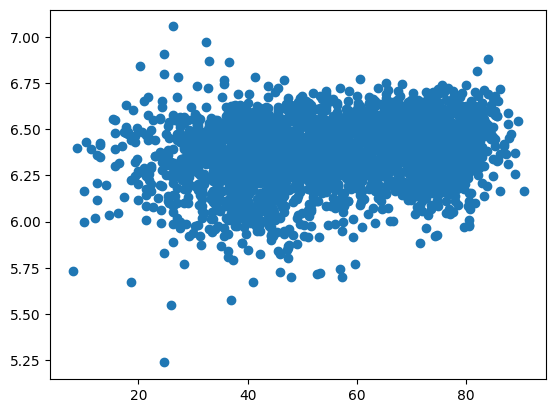

In [236]:
plt.scatter(daily_crashes_pre_covid['TAVG'], daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

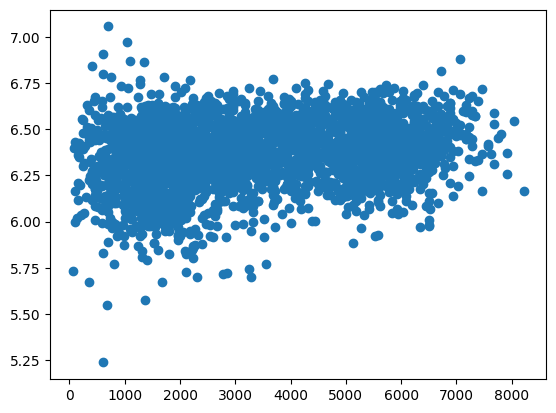

In [237]:
#Does squaring the average temperature make the relationship any more linear?
plt.scatter(np.power(daily_crashes_pre_covid['TAVG'], 2), daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

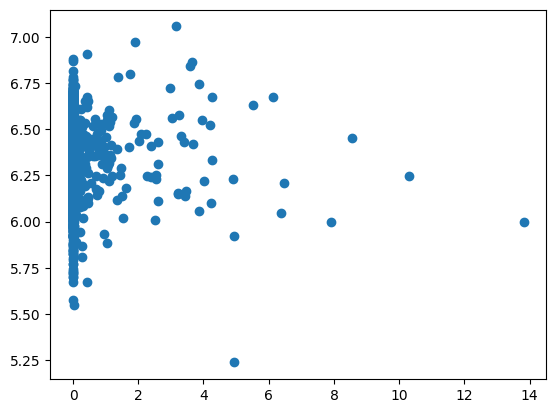

In [238]:
plt.scatter(daily_crashes_pre_covid['SNOW'], daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

In [239]:
#Left-skewed; try taking the natural log

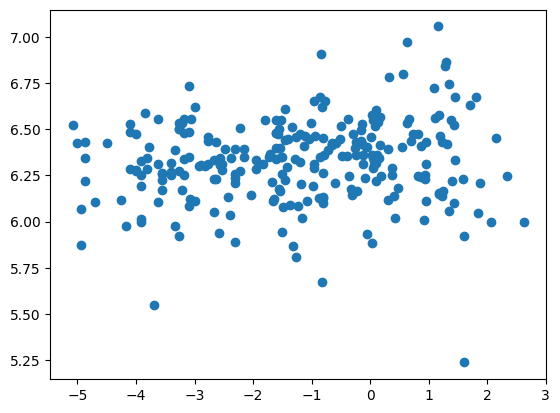

In [240]:
plt.scatter(np.log(daily_crashes_pre_covid['SNOW']), daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

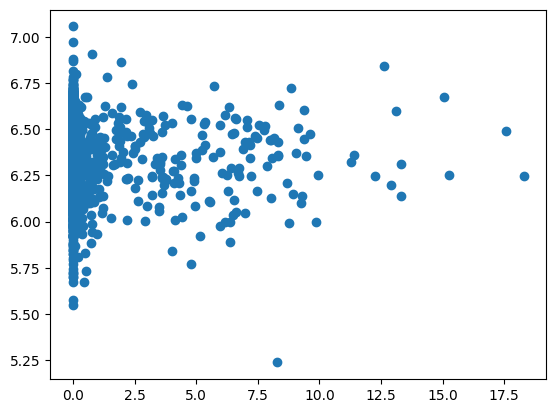

In [241]:
plt.scatter(daily_crashes_pre_covid['SNWD'], daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

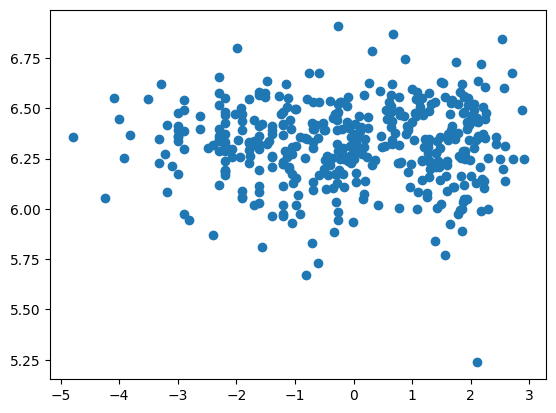

In [242]:
plt.scatter(np.log(daily_crashes_pre_covid['SNWD']), daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

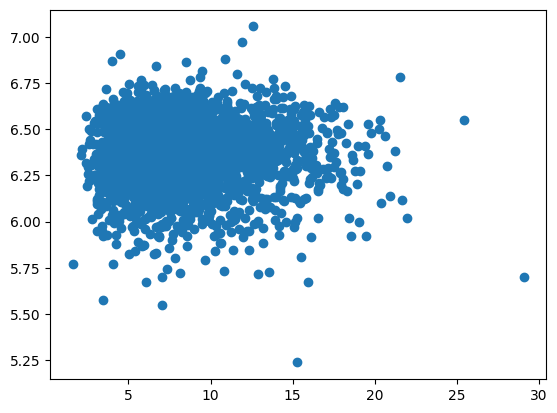

In [243]:
plt.scatter(daily_crashes_pre_covid['AWND'], daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

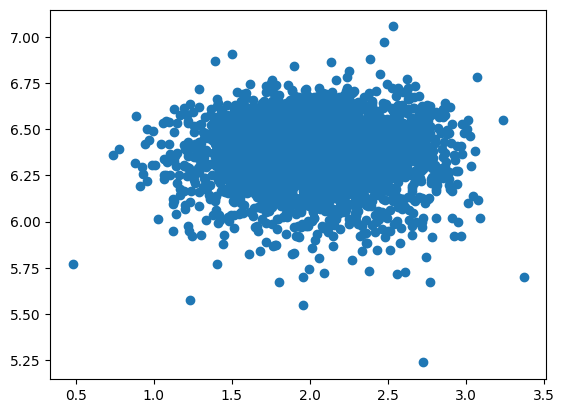

In [244]:
#This also looks left-skewed; try taking the log
plt.scatter(np.log(daily_crashes_pre_covid['AWND']), daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

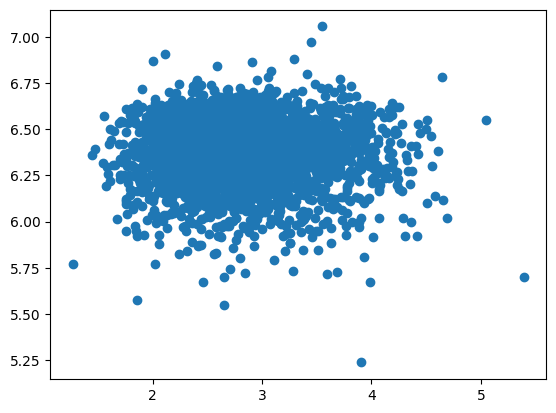

In [245]:
#Try square root
plt.scatter(np.power(daily_crashes_pre_covid['AWND'], 0.5), daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

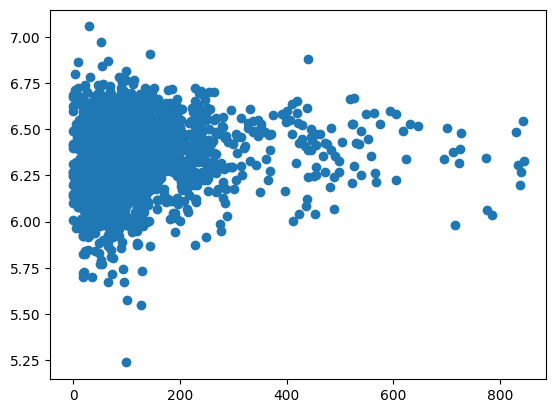

In [246]:
plt.scatter(daily_crashes_pre_covid['AVG_TRAFFIC_VOL'], daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

In [247]:
#Try taking natural log
#Tplt.scatter(np.log(daily_crashes_pre_covid['AVG_TRAFFIC_VOL']), daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

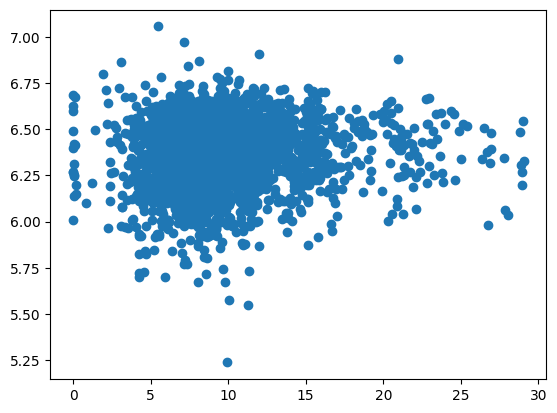

In [248]:
#Try taking square root
plt.scatter(np.power(daily_crashes_pre_covid['AVG_TRAFFIC_VOL'], 0.5), daily_crashes_pre_covid['LOG_COLLISION_COUNT'])

In [249]:
#Now let's add the transformations and see what their correlations with the target variable are like
daily_crashes['LOG_PRCP'] = np.log(daily_crashes['PRCP'])
daily_crashes['TAVG_SQ'] = np.power(daily_crashes['TAVG'], 2)
daily_crashes['LOG_SNOW'] = np.log(daily_crashes['SNOW'])
daily_crashes['LOG_SNWD'] = np.log(daily_crashes['SNWD'])
daily_crashes['AWND_SQRT'] = np.power(daily_crashes['AWND'], 0.5)
daily_crashes['AVG_TRAFFIC_VOL_SQRT'] = np.power(daily_crashes['AVG_TRAFFIC_VOL'], 0.5)

daily_crashes_pre_covid = daily_crashes[:'2020-03-20']
daily_crashes_pre_covid.corr()['LOG_COLLISION_COUNT']

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


COLLISION COUNT           0.989891
PRCP                      0.098288
SNOW                     -0.037082
SNWD                     -0.052710
TMAX                      0.232364
TMIN                      0.209820
TAVG                      0.231684
AWND                     -0.011915
IS_FOG                    0.051125
IS_HEAVY_FOG              0.002297
IS_THUNDER                0.117075
IS_SLEET                 -0.047208
IS_HAIL                   0.020715
IS_GLAZE                 -0.002245
IS_HAZE                   0.027374
IS_DRIFT_SNOW            -0.063424
IS_HIGH_WIND              0.014996
AVG_TRAFFIC_VOL           0.056748
DAY_OF_WEEK              -0.283078
MONTH                     0.153344
IS_WEEKEND               -0.446371
PRECIP_GT_ONE_TENTH_IN    0.083041
BELOW_FREEZING           -0.093291
SNOW_ACCUM_2_IN          -0.062110
IS_HOLIDAY               -0.223703
PRECOVID                       NaN
LOG_COLLISION_COUNT       1.000000
LOG_PRCP                  0.103159
TAVG_SQ                   0.231950
LOG_SNOW                  0.124198
LOG_SNWD                  0.018308
AWND_SQRT                -0.001804
AVG_TRAFFIC_VOL_SQRT      0.068851
Name: LOG_COLLISION_COUNT, dtype: float64

The only value that noticeably improved was LOG_SNOW, but so many values of SNOW are 0 that this wouldn't feasibly work.

### Post-Covid Correlation

In [ ]:
daily_crashes_post_covid = daily_crashes['2020-03-21':]
daily_crashes_post_covid.corr()['LOG_COLLISION_COUNT']

COLLISION COUNT           0.987074
PRCP                      0.059675
SNOW                     -0.039005
SNWD                     -0.060654
TMAX                      0.303898
TMIN                      0.278980
TAVG                      0.306340
AWND                     -0.127183
IS_FOG                    0.039525
IS_HEAVY_FOG             -0.014723
IS_THUNDER                0.097820
IS_SLEET                 -0.095166
IS_HAIL                  -0.022767
IS_GLAZE                 -0.058005
IS_HAZE                  -0.010598
IS_DRIFT_SNOW            -0.000619
IS_HIGH_WIND             -0.030651
AVG_TRAFFIC_VOL           0.170832
DAY_OF_WEEK              -0.049628
MONTH                     0.262019
IS_WEEKEND               -0.154398
PRECIP_GT_ONE_TENTH_IN    0.043688
BELOW_FREEZING           -0.108519
SNOW_ACCUM_2_IN          -0.058005
IS_HOLIDAY               -0.096153
PRECOVID                       NaN
LOG_COLLISION_COUNT       1.000000
LOG_PRCP                  0.026050
TAVG_SQ             

Scatter plots for variables that may be relevant based on correlation values and pre-COVID exploration

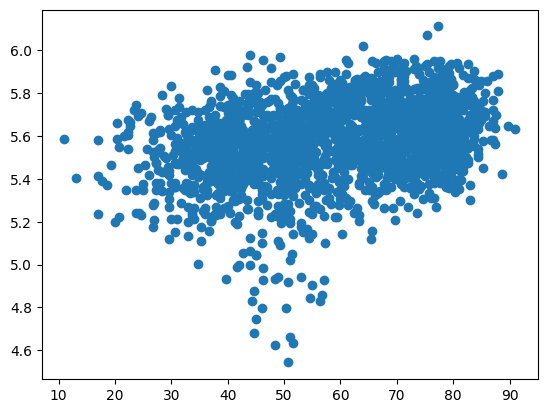

In [ ]:
plt.scatter(daily_crashes_post_covid['TAVG'], daily_crashes_post_covid['LOG_COLLISION_COUNT'])

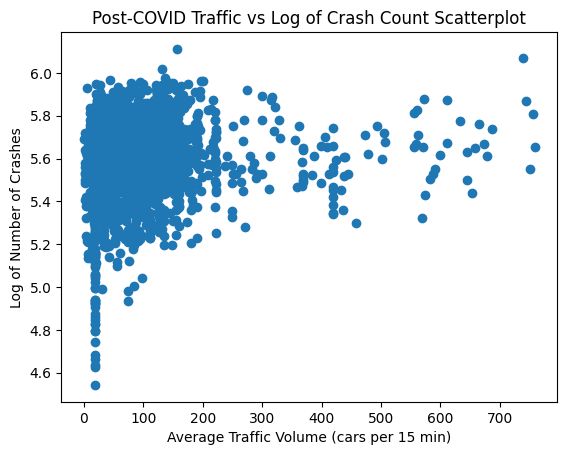

In [ ]:
plt.scatter(daily_crashes_post_covid['AVG_TRAFFIC_VOL'], daily_crashes_post_covid['LOG_COLLISION_COUNT'])
plt.xlabel('Average Traffic Volume (cars per 15 min)')
plt.ylabel('Log of Number of Crashes')
plt.title('Post-COVID Traffic vs Log of Crash Count Scatterplot')
plt.show()

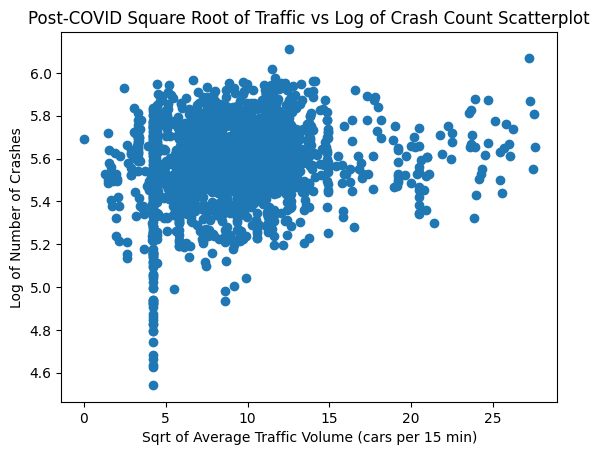

In [ ]:
plt.scatter(daily_crashes_post_covid['AVG_TRAFFIC_VOL_SQRT'], daily_crashes_post_covid['LOG_COLLISION_COUNT'])
plt.xlabel('Sqrt of Average Traffic Volume (cars per 15 min)')
plt.ylabel('Log of Number of Crashes')
plt.title('Post-COVID Square Root of Traffic vs Log of Crash Count Scatterplot')
plt.show()

### Time Categories (Day of Week, Month)

Text(0.5, 1.0, '')

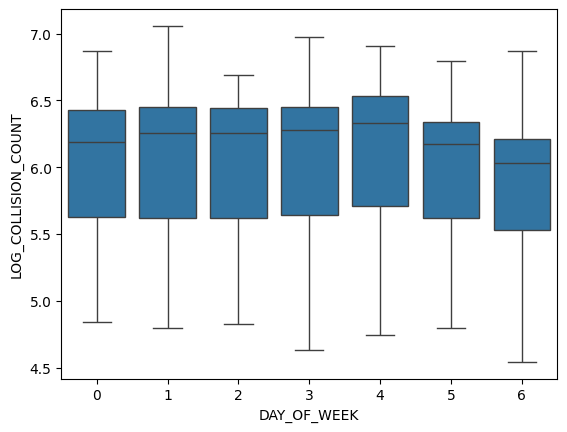

In [ ]:
sns.boxplot(x='DAY_OF_WEEK', y='LOG_COLLISION_COUNT', data=daily_crashes)
plt.title('')

Text(0.5, 1.0, 'Pre-COVID Log Collision Count Distribution by Day of Week')

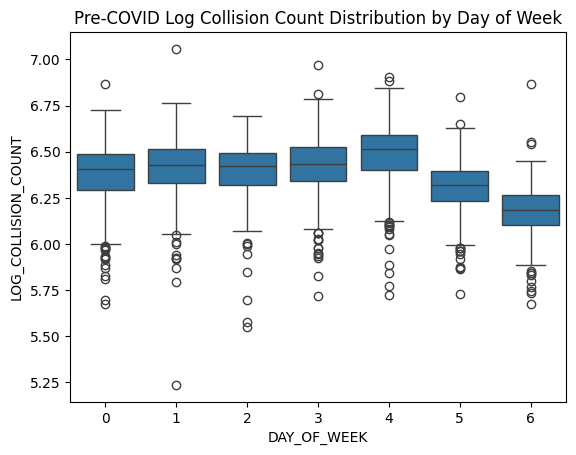

In [ ]:
sns.boxplot(x='DAY_OF_WEEK', y='LOG_COLLISION_COUNT', data=daily_crashes_pre_covid)
plt.title('Pre-COVID Log Collision Count Distribution by Day of Week')

Text(0.5, 1.0, 'Post-COVID Log Collision Count Distribution by Day of Week')

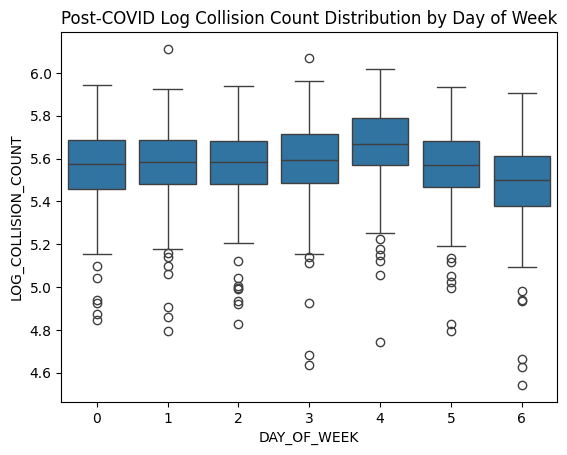

In [ ]:
sns.boxplot(x='DAY_OF_WEEK', y='LOG_COLLISION_COUNT', data=daily_crashes_post_covid)
plt.title('Post-COVID Log Collision Count Distribution by Day of Week')

<Axes: xlabel='MONTH', ylabel='LOG_COLLISION_COUNT'>

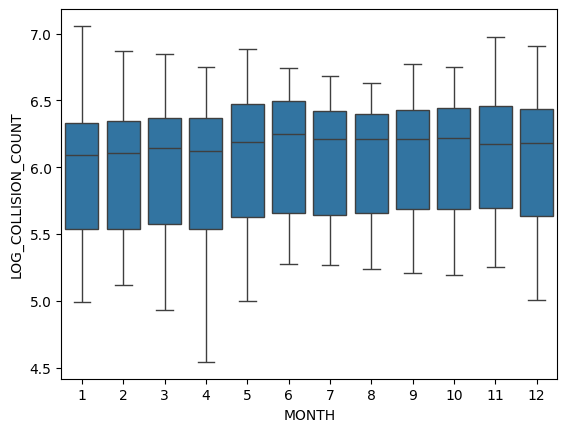

In [ ]:
sns.boxplot(x='MONTH', y='LOG_COLLISION_COUNT', data=daily_crashes)

<Axes: xlabel='MONTH', ylabel='LOG_COLLISION_COUNT'>

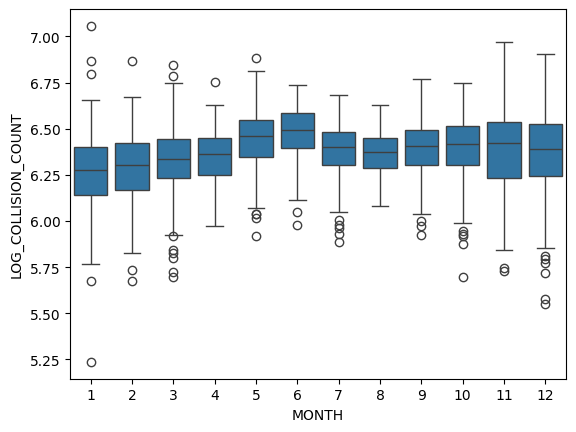

In [ ]:
sns.boxplot(x='MONTH', y='LOG_COLLISION_COUNT', data=daily_crashes_pre_covid)

Text(0.5, 1.0, 'Post-COVID Log Collision Count Distribution by Month')

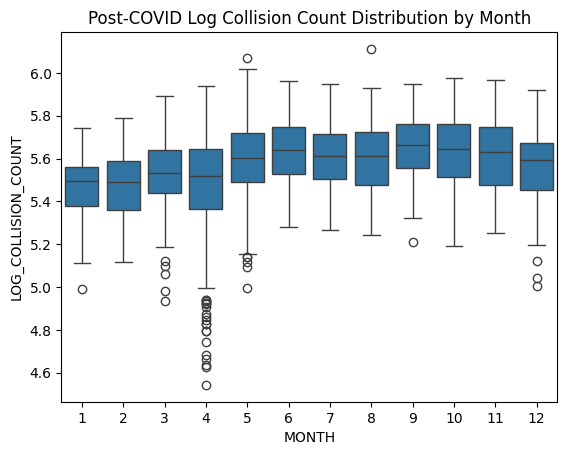

In [ ]:
sns.boxplot(x='MONTH', y='LOG_COLLISION_COUNT', data=daily_crashes_post_covid)
plt.title('Post-COVID Log Collision Count Distribution by Month')

In [ ]:
## Next thing to investigate: what happens if we look at crashes per day per borough? Do some variables affect some boroughs more than others?

In [ ]:
print(crashes_with_weather['BOROUGH'].value_counts())
print('Null: '+str(crashes_with_weather['BOROUGH'].isnull().sum()))


BOROUGH
BROOKLYN         492636
QUEENS           411970
MANHATTAN        340742
BRONX            227654
STATEN ISLAND     64366
Name: count, dtype: int64
Null: 679570


### Crashes by Borough by Day

In [ ]:
crashes_with_weather['BOROUGH'] = crashes_with_weather['BOROUGH'].fillna('Unspecified')

In [ ]:
## Next thing to investigate: what happens if we look at crashes per day per borough? Do some variables affect some boroughs more than others?
daily_crashes_by_borough = pd.concat([crashes_with_weather.groupby([ 'BOROUGH','CRASH DATE',]).count()['COLLISION_ID'],
                           crashes_with_weather[['CRASH DATE', 'BOROUGH', 'PRCP', 'SNOW',	'SNWD',	'TMAX',	'TMIN',	'TAVG',	'AWND',	'IS_FOG',
                                                 'IS_HEAVY_FOG', 'IS_THUNDER', 'IS_SLEET', 'IS_HAIL', 'IS_GLAZE', 'IS_HAZE', 'IS_DRIFT_SNOW',
                                                 'IS_HIGH_WIND']].groupby([ 'BOROUGH','CRASH DATE']).mean()], axis=1)
daily_crashes_by_borough.rename(columns={'COLLISION_ID': 'COLLISION COUNT'}, inplace=True)
daily_crashes_by_borough.index.names = ['BOROUGH', 'CRASH DATE']
daily_crashes_by_borough['DAY_OF_WEEK'] = daily_crashes_by_borough.index.get_level_values('CRASH DATE').dayofweek.astype('category')
daily_crashes_by_borough['MONTH'] = daily_crashes_by_borough.index.get_level_values('CRASH DATE').month.astype('category')
daily_crashes_by_borough['YEAR'] = daily_crashes_by_borough.index.get_level_values('CRASH DATE').year.astype('category')
daily_crashes_by_borough['LOG_COLLISION_COUNT'] = np.log(daily_crashes_by_borough['COLLISION COUNT'])


In [ ]:
#Creating some new categorical variables
daily_crashes_by_borough['PRECIP_GT_0.1'] = daily_crashes_by_borough['PRCP'] > 0.1
daily_crashes_by_borough['BELOW_FREEZING'] = daily_crashes_by_borough['TAVG']<= 32
daily_crashes_by_borough['SNOW_ACCUM_2_IN'] = daily_crashes_by_borough['SNWD'] > 2
daily_crashes_by_borough['IS_WEEKEND'] = np.where((daily_crashes_by_borough['DAY_OF_WEEK'] == 5) | (daily_crashes_by_borough['DAY_OF_WEEK'] == 6), 1, 0)

#### Bronx

In [ ]:
#One borough at a time
daily_crashes_bronx = daily_crashes_by_borough.loc['BRONX']
daily_crashes_bronx['DAY OF WEEK'] = daily_crashes_bronx.index.dayofweek.astype('category')
daily_crashes_bronx_pre_covid = daily_crashes_bronx[:'2020-03-20']
daily_crashes_bronx_post_covid = daily_crashes_bronx['2020-03-21':]
daily_crashes_bronx_pre_covid.corr()


/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_25216/4270837057.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_crashes_bronx['DAY OF WEEK'] = daily_crashes_bronx.index.dayofweek.astype('category')


COLLISION COUNT      PRCP      SNOW      SNWD      TMAX  \
COLLISION COUNT             1.000000  0.106924  0.064652  0.010766  0.103738   
PRCP                        0.106924  1.000000  0.207355  0.043770  0.008503   
SNOW                        0.064652  0.207355  1.000000  0.490141 -0.233259   
SNWD                        0.010766  0.043770  0.490141  1.000000 -0.361431   
TMAX                        0.103738  0.008503 -0.233259 -0.361431  1.000000   
TMIN                        0.088329  0.075850 -0.216435 -0.376248  0.966425   
TAVG                        0.100346  0.027426 -0.230695 -0.379325  0.990721   
AWND                        0.026937  0.238086  0.172907  0.090042 -0.327358   
IS_FOG                      0.034398  0.410401  0.120385  0.023745  0.072758   
IS_HEAVY_FOG                0.031982  0.276607  0.145737  0.047796 -0.018628   
IS_THUNDER                  0.072762  0.310422 -0.030513 -0.082962  0.366677   
IS_SLEET                    0.016567  0.194071  0.344993  0.239484 -0.243753   
IS_HAIL                     0.021115  0.056244  0.041964 -0.002038 -0.005237   
IS_GLAZE                    0.056884  0.092615  0.179555  0.206352 -0.190487   
IS_HAZE                    -0.005040  0.108086  0.112914  0.092912  0.056902   
IS_DRIFT_SNOW               0.009469  0.077961  0.479800  0.225811 -0.140495   
IS_HIGH_WIND                0.028156  0.209181  0.063285  0.012642 -0.022336   
DAY_OF_WEEK                -0.205135 -0.007720  0.013746  0.003415 -0.011849   
MONTH                       0.000395  0.011495 -0.143403 -0.286263  0.279916   
YEAR                        0.220312  0.040983 -0.006140 -0.065756 -0.066256   
LOG_COLLISION_COUNT         0.975696  0.094711  0.034096 -0.018029  0.130113   
PRECIP_GT_0.1               0.090422  0.716153  0.186702  0.047434  0.024883   
BELOW_FREEZING             -0.003977 -0.079255  0.227752  0.420987 -0.513967   
SNOW_ACCUM_2_IN            -0.000916  0.026317  0.419465  0.867633 -0.358756   
IS_WEEKEND                 -0.323856 -0.008284  0.010417  0.004928 -0.008526   
DAY OF WEEK                -0.205135 -0.007720  0.013746  0.003415 -0.011849   

                         TMIN      TAVG      AWND    IS_FOG  IS_HEAVY_FOG  \
COLLISION COUNT      0.088329  0.100346  0.026937  0.034398      0.031982   
PRCP                 0.075850  0.027426  0.238086  0.410401      0.276607   
SNOW                -0.216435 -0.230695  0.172907  0.120385      0.145737   
SNWD                -0.376248 -0.379325  0.090042  0.023745      0.047796   
TMAX                 0.966425  0.990721 -0.327358  0.072758     -0.018628   
TMIN                 1.000000  0.984045 -0.302588  0.146333      0.011575   
TAVG                 0.984045  1.000000 -0.309674  0.101464     -0.012606   
AWND                -0.302588 -0.309674  1.000000  0.043970     -0.046323   
IS_FOG               0.146333  0.101464  0.043970  1.000000      0.334414   
IS_HEAVY_FOG         0.011575 -0.012606 -0.046323  0.334414      1.000000   
IS_THUNDER           0.393951  0.351648 -0.040425  0.292136      0.157355   
IS_SLEET            -0.217503 -0.226899  0.136302  0.151657      0.121733   
IS_HAIL             -0.004628 -0.002208  0.040109  0.055498      0.021675   
IS_GLAZE            -0.182165 -0.197416  0.064326  0.105764      0.093443   
IS_HAZE              0.083817  0.060786 -0.063161  0.370639      0.276836   
IS_DRIFT_SNOW       -0.139537 -0.140082  0.185105  0.057650      0.096505   
IS_HIGH_WIND        -0.012191 -0.021955  0.187480  0.061929     -0.033370   
DAY_OF_WEEK         -0.007100 -0.008975  0.008508 -0.037077     -0.015745   
MONTH                0.316662  0.305422 -0.169155  0.020882     -0.079503   
YEAR                -0.062943 -0.091011  0.086259 -0.051810     -0.042743   
LOG_COLLISION_COUNT  0.114791  0.126460  0.012134  0.026673      0.017146   
PRECIP_GT_0.1        0.106239  0.046032  0.187233  0.514345      0.312910   
BELOW_FREEZING      -0.521399 -0.565234  0.138579 -0.113132     -0.018745   
SNOW_ACCUM_2

In [ ]:
daily_crashes_bronx_post_covid.corr()

COLLISION COUNT      PRCP      SNOW      SNWD      TMAX  \
COLLISION COUNT             1.000000  0.017311 -0.018870 -0.050403  0.233178   
PRCP                        0.017311  1.000000  0.103596  0.012942  0.001035   
SNOW                       -0.018870  0.103596  1.000000  0.490504 -0.198855   
SNWD                       -0.050403  0.012942  0.490504  1.000000 -0.299189   
TMAX                        0.233178  0.001035 -0.198855 -0.299189  1.000000   
TMIN                        0.203799  0.085533 -0.173042 -0.275852  0.958975   
TAVG                        0.236951  0.036892 -0.191090 -0.288942  0.989811   
AWND                       -0.084689  0.235703  0.156153  0.058653 -0.323800   
IS_FOG                      0.037046  0.417431  0.096445  0.048484  0.031288   
IS_HEAVY_FOG               -0.037664  0.231650  0.105348  0.034501  0.040179   
IS_THUNDER                  0.083026  0.296574 -0.049857 -0.080933  0.369993   
IS_SLEET                   -0.086184  0.088967  0.274858  0.192984 -0.254033   
IS_HAIL                    -0.017990  0.046664  0.031840 -0.007075 -0.023156   
IS_GLAZE                   -0.027035  0.035937  0.233940  0.306875 -0.186855   
IS_HAZE                    -0.000371  0.164140  0.080579  0.049593  0.055049   
IS_DRIFT_SNOW               0.007538  0.088026  0.705917  0.279065 -0.095441   
IS_HIGH_WIND               -0.016491  0.276996  0.076009  0.021672 -0.082043   
DAY_OF_WEEK                -0.020765 -0.008981 -0.009771 -0.008900 -0.004607   
MONTH                       0.150593  0.021990 -0.118058 -0.196040  0.276835   
YEAR                       -0.410803 -0.024719 -0.015265 -0.083576 -0.023391   
LOG_COLLISION_COUNT         0.982507  0.012828 -0.024112 -0.049261  0.229456   
PRECIP_GT_0.1              -0.000170  0.649476  0.137041  0.024375  0.023919   
BELOW_FREEZING             -0.042929 -0.062861  0.274552  0.372674 -0.447916   
SNOW_ACCUM_2_IN            -0.039960  0.014128  0.481528  0.859544 -0.281326   
IS_WEEKEND                 -0.106682 -0.004910  0.006590 -0.002159 -0.015478   
DAY OF WEEK                -0.020765 -0.008981 -0.009771 -0.008900 -0.004607   

                         TMIN      TAVG      AWND    IS_FOG  IS_HEAVY_FOG  \
COLLISION COUNT      0.203799  0.236951 -0.084689  0.037046     -0.037664   
PRCP                 0.085533  0.036892  0.235703  0.417431      0.231650   
SNOW                -0.173042 -0.191090  0.156153  0.096445      0.105348   
SNWD                -0.275852 -0.288942  0.058653  0.048484      0.034501   
TMAX                 0.958975  0.989811 -0.323800  0.031288      0.040179   
TMIN                 1.000000  0.980646 -0.303077  0.125094      0.075545   
TAVG                 0.980646  1.000000 -0.315610  0.073176      0.044782   
AWND                -0.303077 -0.315610  1.000000  0.018460     -0.041213   
IS_FOG               0.125094  0.073176  0.018460  1.000000      0.345693   
IS_HEAVY_FOG         0.075545  0.044782 -0.041213  0.345693      1.000000   
IS_THUNDER           0.395255  0.382064 -0.028340  0.292684      0.176776   
IS_SLEET            -0.221815 -0.240815  0.095963  0.139563      0.082743   
IS_HAIL             -0.024015 -0.021865  0.051088  0.044281      0.005188   
IS_GLAZE            -0.161846 -0.175783  0.047800  0.090638      0.021048   
IS_HAZE              0.105675  0.074986 -0.078149  0.438404      0.317593   
IS_DRIFT_SNOW       -0.080079 -0.091503  0.128946  0.049423      0.110950   
IS_HIGH_WIND        -0.084762 -0.083394  0.296840  0.068744     -0.005999   
DAY_OF_WEEK         -0.009327 -0.011848  0.031093  0.010736      0.005527   
MONTH                0.294694  0.300353 -0.212343 -0.045168     -0.069506   
YEAR                -0.024567 -0.046365  0.017056 -0.100168      0.018645   
LOG_COLLISION_COUNT  0.198455  0.232053 -0.079209  0.029241     -0.039286   
PRECIP_GT_0.1        0.119202  0.058621  0.160111  0.559379      0.293905   
BELOW_FREEZING      -0.440977 -0.458862  0.156575 -0.083248     -0.032158   
SNOW_ACCUM_2

#### Brooklyn

In [ ]:

daily_crashes_brooklyn = daily_crashes_by_borough.loc['BROOKLYN']
daily_crashes_brooklyn['DAY OF WEEK'] = daily_crashes_brooklyn.index.dayofweek.astype('category')
daily_crashes_brooklyn_pre_covid = daily_crashes_brooklyn[:'2020-03-20']
daily_crashes_brooklyn_post_covid = daily_crashes_brooklyn['2020-03-21':]
daily_crashes_brooklyn_pre_covid.corr()


/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_25216/959008408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_crashes_brooklyn['DAY OF WEEK'] = daily_crashes_brooklyn.index.dayofweek.astype('category')


COLLISION COUNT      PRCP      SNOW      SNWD      TMAX  \
COLLISION COUNT             1.000000  0.104326  0.018457  0.019765  0.152903   
PRCP                        0.104326  1.000000  0.207355  0.043770  0.008503   
SNOW                        0.018457  0.207355  1.000000  0.490141 -0.233259   
SNWD                        0.019765  0.043770  0.490141  1.000000 -0.361431   
TMAX                        0.152903  0.008503 -0.233259 -0.361431  1.000000   
TMIN                        0.132092  0.075850 -0.216435 -0.376248  0.966425   
TAVG                        0.148199  0.027426 -0.230695 -0.379325  0.990721   
AWND                        0.015370  0.238086  0.172907  0.090042 -0.327358   
IS_FOG                      0.083633  0.410401  0.120385  0.023745  0.072758   
IS_HEAVY_FOG                0.047956  0.276607  0.145737  0.047796 -0.018628   
IS_THUNDER                  0.099925  0.310422 -0.030513 -0.082962  0.366677   
IS_SLEET                    0.008999  0.194071  0.344993  0.239484 -0.243753   
IS_HAIL                     0.023520  0.056244  0.041964 -0.002038 -0.005237   
IS_GLAZE                    0.044385  0.092615  0.179555  0.206352 -0.190487   
IS_HAZE                     0.090372  0.108086  0.112914  0.092912  0.056902   
IS_DRIFT_SNOW              -0.016455  0.077961  0.479800  0.225811 -0.140495   
IS_HIGH_WIND                0.015308  0.209181  0.063285  0.012642 -0.022336   
DAY_OF_WEEK                -0.332783 -0.007720  0.013746  0.003415 -0.011849   
MONTH                       0.088797  0.011495 -0.143403 -0.286263  0.279916   
YEAR                       -0.140009  0.040983 -0.006140 -0.065756 -0.066256   
LOG_COLLISION_COUNT         0.980444  0.095906  0.000011 -0.009224  0.167913   
PRECIP_GT_0.1               0.071455  0.716153  0.186702  0.047434  0.024883   
BELOW_FREEZING             -0.023135 -0.079255  0.227752  0.420987 -0.513967   
SNOW_ACCUM_2_IN             0.004299  0.026317  0.419465  0.867633 -0.358756   
IS_WEEKEND                 -0.451195 -0.008284  0.010417  0.004928 -0.008526   
DAY OF WEEK                -0.332783 -0.007720  0.013746  0.003415 -0.011849   

                         TMIN      TAVG      AWND    IS_FOG  IS_HEAVY_FOG  \
COLLISION COUNT      0.132092  0.148199  0.015370  0.083633      0.047956   
PRCP                 0.075850  0.027426  0.238086  0.410401      0.276607   
SNOW                -0.216435 -0.230695  0.172907  0.120385      0.145737   
SNWD                -0.376248 -0.379325  0.090042  0.023745      0.047796   
TMAX                 0.966425  0.990721 -0.327358  0.072758     -0.018628   
TMIN                 1.000000  0.984045 -0.302588  0.146333      0.011575   
TAVG                 0.984045  1.000000 -0.309674  0.101464     -0.012606   
AWND                -0.302588 -0.309674  1.000000  0.043970     -0.046323   
IS_FOG               0.146333  0.101464  0.043970  1.000000      0.334414   
IS_HEAVY_FOG         0.011575 -0.012606 -0.046323  0.334414      1.000000   
IS_THUNDER           0.393951  0.351648 -0.040425  0.292136      0.157355   
IS_SLEET            -0.217503 -0.226899  0.136302  0.151657      0.121733   
IS_HAIL             -0.004628 -0.002208  0.040109  0.055498      0.021675   
IS_GLAZE            -0.182165 -0.197416  0.064326  0.105764      0.093443   
IS_HAZE              0.083817  0.060786 -0.063161  0.370639      0.276836   
IS_DRIFT_SNOW       -0.139537 -0.140082  0.185105  0.057650      0.096505   
IS_HIGH_WIND        -0.012191 -0.021955  0.187480  0.061929     -0.033370   
DAY_OF_WEEK         -0.007100 -0.008975  0.008508 -0.037077     -0.015745   
MONTH                0.316662  0.305422 -0.169155  0.020882     -0.079503   
YEAR                -0.062943 -0.091011  0.086259 -0.051810     -0.042743   
LOG_COLLISION_COUNT  0.148907  0.164611  0.007055  0.080468      0.039313   
PRECIP_GT_0.1        0.106239  0.046032  0.187233  0.514345      0.312910   
BELOW_FREEZING      -0.521399 -0.565234  0.138579 -0.113132     -0.018745   
SNOW_ACCUM_2

In [ ]:
daily_crashes_brooklyn_post_covid.corr()

COLLISION COUNT      PRCP      SNOW      SNWD      TMAX  \
COLLISION COUNT             1.000000  0.037834 -0.064996 -0.079303  0.291284   
PRCP                        0.037834  1.000000  0.103596  0.012942  0.001035   
SNOW                       -0.064996  0.103596  1.000000  0.490504 -0.198855   
SNWD                       -0.079303  0.012942  0.490504  1.000000 -0.299189   
TMAX                        0.291284  0.001035 -0.198855 -0.299189  1.000000   
TMIN                        0.274583  0.085533 -0.173042 -0.275852  0.958975   
TAVG                        0.292276  0.036892 -0.191090 -0.288942  0.989811   
AWND                       -0.104091  0.235703  0.156153  0.058653 -0.323800   
IS_FOG                      0.003929  0.417431  0.096445  0.048484  0.031288   
IS_HEAVY_FOG               -0.025202  0.231650  0.105348  0.034501  0.040179   
IS_THUNDER                  0.079295  0.296574 -0.049857 -0.080933  0.369993   
IS_SLEET                   -0.090862  0.088967  0.274858  0.192984 -0.254033   
IS_HAIL                    -0.030651  0.046664  0.031840 -0.007075 -0.023156   
IS_GLAZE                   -0.049407  0.035937  0.233940  0.306875 -0.186855   
IS_HAZE                     0.020053  0.164140  0.080579  0.049593  0.055049   
IS_DRIFT_SNOW              -0.018192  0.088026  0.705917  0.279065 -0.095441   
IS_HIGH_WIND               -0.046293  0.276996  0.076009  0.021672 -0.082043   
DAY_OF_WEEK                -0.140141 -0.008981 -0.009771 -0.008900 -0.004607   
MONTH                       0.205223  0.021990 -0.118058 -0.196040  0.276835   
YEAR                        0.000128 -0.024719 -0.015265 -0.083576 -0.023391   
LOG_COLLISION_COUNT         0.983839  0.033288 -0.061629 -0.073400  0.283632   
PRECIP_GT_0.1               0.021815  0.649476  0.137041  0.024375  0.023919   
BELOW_FREEZING             -0.103579 -0.062861  0.274552  0.372674 -0.447916   
SNOW_ACCUM_2_IN            -0.088506  0.014128  0.481528  0.859544 -0.281326   
IS_WEEKEND                 -0.252879 -0.004910  0.006590 -0.002159 -0.015478   
DAY OF WEEK                -0.140141 -0.008981 -0.009771 -0.008900 -0.004607   

                         TMIN      TAVG      AWND    IS_FOG  IS_HEAVY_FOG  \
COLLISION COUNT      0.274583  0.292276 -0.104091  0.003929     -0.025202   
PRCP                 0.085533  0.036892  0.235703  0.417431      0.231650   
SNOW                -0.173042 -0.191090  0.156153  0.096445      0.105348   
SNWD                -0.275852 -0.288942  0.058653  0.048484      0.034501   
TMAX                 0.958975  0.989811 -0.323800  0.031288      0.040179   
TMIN                 1.000000  0.980646 -0.303077  0.125094      0.075545   
TAVG                 0.980646  1.000000 -0.315610  0.073176      0.044782   
AWND                -0.303077 -0.315610  1.000000  0.018460     -0.041213   
IS_FOG               0.125094  0.073176  0.018460  1.000000      0.345693   
IS_HEAVY_FOG         0.075545  0.044782 -0.041213  0.345693      1.000000   
IS_THUNDER           0.395255  0.382064 -0.028340  0.292684      0.176776   
IS_SLEET            -0.221815 -0.240815  0.095963  0.139563      0.082743   
IS_HAIL             -0.024015 -0.021865  0.051088  0.044281      0.005188   
IS_GLAZE            -0.161846 -0.175783  0.047800  0.090638      0.021048   
IS_HAZE              0.105675  0.074986 -0.078149  0.438404      0.317593   
IS_DRIFT_SNOW       -0.080079 -0.091503  0.128946  0.049423      0.110950   
IS_HIGH_WIND        -0.084762 -0.083394  0.296840  0.068744     -0.005999   
DAY_OF_WEEK         -0.009327 -0.011848  0.031093  0.010736      0.005527   
MONTH                0.294694  0.300353 -0.212343 -0.045168     -0.069506   
YEAR                -0.024567 -0.046365  0.017056 -0.100168      0.018645   
LOG_COLLISION_COUNT  0.268678  0.284951 -0.108305  0.000876     -0.021813   
PRECIP_GT_0.1        0.119202  0.058621  0.160111  0.559379      0.293905   
BELOW_FREEZING      -0.440977 -0.458862  0.156575 -0.083248     -0.032158   
SNOW_ACCUM_2

#### Queens

In [ ]:

daily_crashes_queens = daily_crashes_by_borough.loc['QUEENS']
daily_crashes_queens['DAY OF WEEK'] = daily_crashes_queens.index.dayofweek.astype('category')
daily_crashes_queens_pre_covid = daily_crashes_queens[:'2020-03-20']
daily_crashes_queens_post_covid = daily_crashes_queens['2020-03-21':]
daily_crashes_queens_pre_covid.corr()

/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_25216/4206653854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_crashes_queens['DAY OF WEEK'] = daily_crashes_queens.index.dayofweek.astype('category')


COLLISION COUNT      PRCP      SNOW      SNWD      TMAX  \
COLLISION COUNT             1.000000  0.129044  0.105566  0.063332  0.111022   
PRCP                        0.129044  1.000000  0.207355  0.043770  0.008503   
SNOW                        0.105566  0.207355  1.000000  0.490141 -0.233259   
SNWD                        0.063332  0.043770  0.490141  1.000000 -0.361431   
TMAX                        0.111022  0.008503 -0.233259 -0.361431  1.000000   
TMIN                        0.097741  0.075850 -0.216435 -0.376248  0.966425   
TAVG                        0.111049  0.027426 -0.230695 -0.379325  0.990721   
AWND                        0.005522  0.238086  0.172907  0.090042 -0.327358   
IS_FOG                      0.087521  0.410401  0.120385  0.023745  0.072758   
IS_HEAVY_FOG                0.052288  0.276607  0.145737  0.047796 -0.018628   
IS_THUNDER                  0.076605  0.310422 -0.030513 -0.082962  0.366677   
IS_SLEET                    0.040396  0.194071  0.344993  0.239484 -0.243753   
IS_HAIL                     0.021094  0.056244  0.041964 -0.002038 -0.005237   
IS_GLAZE                    0.054752  0.092615  0.179555  0.206352 -0.190487   
IS_HAZE                     0.068144  0.108086  0.112914  0.092912  0.056902   
IS_DRIFT_SNOW               0.007345  0.077961  0.479800  0.225811 -0.140495   
IS_HIGH_WIND                0.012926  0.209181  0.063285  0.012642 -0.022336   
DAY_OF_WEEK                -0.238951 -0.007720  0.013746  0.003415 -0.011849   
MONTH                       0.116104  0.011495 -0.143403 -0.286263  0.279916   
YEAR                       -0.027790  0.040983 -0.006140 -0.065756 -0.066256   
LOG_COLLISION_COUNT         0.977638  0.116168  0.073927  0.025729  0.134878   
PRECIP_GT_0.1               0.106842  0.716153  0.186702  0.047434  0.024883   
BELOW_FREEZING              0.000340 -0.079255  0.227752  0.420987 -0.513967   
SNOW_ACCUM_2_IN             0.031774  0.026317  0.419465  0.867633 -0.358756   
IS_WEEKEND                 -0.335682 -0.008284  0.010417  0.004928 -0.008526   
DAY OF WEEK                -0.238951 -0.007720  0.013746  0.003415 -0.011849   

                         TMIN      TAVG      AWND    IS_FOG  IS_HEAVY_FOG  \
COLLISION COUNT      0.097741  0.111049  0.005522  0.087521      0.052288   
PRCP                 0.075850  0.027426  0.238086  0.410401      0.276607   
SNOW                -0.216435 -0.230695  0.172907  0.120385      0.145737   
SNWD                -0.376248 -0.379325  0.090042  0.023745      0.047796   
TMAX                 0.966425  0.990721 -0.327358  0.072758     -0.018628   
TMIN                 1.000000  0.984045 -0.302588  0.146333      0.011575   
TAVG                 0.984045  1.000000 -0.309674  0.101464     -0.012606   
AWND                -0.302588 -0.309674  1.000000  0.043970     -0.046323   
IS_FOG               0.146333  0.101464  0.043970  1.000000      0.334414   
IS_HEAVY_FOG         0.011575 -0.012606 -0.046323  0.334414      1.000000   
IS_THUNDER           0.393951  0.351648 -0.040425  0.292136      0.157355   
IS_SLEET            -0.217503 -0.226899  0.136302  0.151657      0.121733   
IS_HAIL             -0.004628 -0.002208  0.040109  0.055498      0.021675   
IS_GLAZE            -0.182165 -0.197416  0.064326  0.105764      0.093443   
IS_HAZE              0.083817  0.060786 -0.063161  0.370639      0.276836   
IS_DRIFT_SNOW       -0.139537 -0.140082  0.185105  0.057650      0.096505   
IS_HIGH_WIND        -0.012191 -0.021955  0.187480  0.061929     -0.033370   
DAY_OF_WEEK         -0.007100 -0.008975  0.008508 -0.037077     -0.015745   
MONTH                0.316662  0.305422 -0.169155  0.020882     -0.079503   
YEAR                -0.062943 -0.091011  0.086259 -0.051810     -0.042743   
LOG_COLLISION_COUNT  0.122947  0.137361 -0.006298  0.081972      0.038652   
PRECIP_GT_0.1        0.106239  0.046032  0.187233  0.514345      0.312910   
BELOW_FREEZING      -0.521399 -0.565234  0.138579 -0.113132     -0.018745   
SNOW_ACCUM_2

In [ ]:
daily_crashes_queens_post_covid.corr()

COLLISION COUNT      PRCP      SNOW      SNWD      TMAX  \
COLLISION COUNT             1.000000  0.014039  0.024614 -0.020265  0.212204   
PRCP                        0.014039  1.000000  0.103596  0.012942  0.001035   
SNOW                        0.024614  0.103596  1.000000  0.490504 -0.198855   
SNWD                       -0.020265  0.012942  0.490504  1.000000 -0.299189   
TMAX                        0.212204  0.001035 -0.198855 -0.299189  1.000000   
TMIN                        0.191846  0.085533 -0.173042 -0.275852  0.958975   
TAVG                        0.218599  0.036892 -0.191090 -0.288942  0.989811   
AWND                       -0.088308  0.235703  0.156153  0.058653 -0.323800   
IS_FOG                     -0.019174  0.417431  0.096445  0.048484  0.031288   
IS_HEAVY_FOG               -0.020880  0.231650  0.105348  0.034501  0.040179   
IS_THUNDER                  0.040396  0.296574 -0.049857 -0.080933  0.369993   
IS_SLEET                   -0.059939  0.088967  0.274858  0.192984 -0.254033   
IS_HAIL                    -0.026891  0.046664  0.031840 -0.007075 -0.023156   
IS_GLAZE                   -0.028858  0.035937  0.233940  0.306875 -0.186855   
IS_HAZE                    -0.034502  0.164140  0.080579  0.049593  0.055049   
IS_DRIFT_SNOW               0.012977  0.088026  0.705917  0.279065 -0.095441   
IS_HIGH_WIND               -0.018324  0.276996  0.076009  0.021672 -0.082043   
DAY_OF_WEEK                 0.098108 -0.008981 -0.009771 -0.008900 -0.004607   
MONTH                       0.253631  0.021990 -0.118058 -0.196040  0.276835   
YEAR                       -0.060758 -0.024719 -0.015265 -0.083576 -0.023391   
LOG_COLLISION_COUNT         0.980774  0.014217  0.022149 -0.016394  0.208564   
PRECIP_GT_0.1               0.020172  0.649476  0.137041  0.024375  0.023919   
BELOW_FREEZING             -0.051230 -0.062861  0.274552  0.372674 -0.447916   
SNOW_ACCUM_2_IN            -0.020746  0.014128  0.481528  0.859544 -0.281326   
IS_WEEKEND                  0.044550 -0.004910  0.006590 -0.002159 -0.015478   
DAY OF WEEK                 0.098108 -0.008981 -0.009771 -0.008900 -0.004607   

                         TMIN      TAVG      AWND    IS_FOG  IS_HEAVY_FOG  \
COLLISION COUNT      0.191846  0.218599 -0.088308 -0.019174     -0.020880   
PRCP                 0.085533  0.036892  0.235703  0.417431      0.231650   
SNOW                -0.173042 -0.191090  0.156153  0.096445      0.105348   
SNWD                -0.275852 -0.288942  0.058653  0.048484      0.034501   
TMAX                 0.958975  0.989811 -0.323800  0.031288      0.040179   
TMIN                 1.000000  0.980646 -0.303077  0.125094      0.075545   
TAVG                 0.980646  1.000000 -0.315610  0.073176      0.044782   
AWND                -0.303077 -0.315610  1.000000  0.018460     -0.041213   
IS_FOG               0.125094  0.073176  0.018460  1.000000      0.345693   
IS_HEAVY_FOG         0.075545  0.044782 -0.041213  0.345693      1.000000   
IS_THUNDER           0.395255  0.382064 -0.028340  0.292684      0.176776   
IS_SLEET            -0.221815 -0.240815  0.095963  0.139563      0.082743   
IS_HAIL             -0.024015 -0.021865  0.051088  0.044281      0.005188   
IS_GLAZE            -0.161846 -0.175783  0.047800  0.090638      0.021048   
IS_HAZE              0.105675  0.074986 -0.078149  0.438404      0.317593   
IS_DRIFT_SNOW       -0.080079 -0.091503  0.128946  0.049423      0.110950   
IS_HIGH_WIND        -0.084762 -0.083394  0.296840  0.068744     -0.005999   
DAY_OF_WEEK         -0.009327 -0.011848  0.031093  0.010736      0.005527   
MONTH                0.294694  0.300353 -0.212343 -0.045168     -0.069506   
YEAR                -0.024567 -0.046365  0.017056 -0.100168      0.018645   
LOG_COLLISION_COUNT  0.189833  0.214883 -0.095783 -0.023062     -0.013241   
PRECIP_GT_0.1        0.119202  0.058621  0.160111  0.559379      0.293905   
BELOW_FREEZING      -0.440977 -0.458862  0.156575 -0.083248     -0.032158   
SNOW_ACCUM_2

#### Manhattan

In [ ]:
daily_crashes_manhattan = daily_crashes_by_borough.loc['MANHATTAN']
daily_crashes_manhattan['DAY OF WEEK'] = daily_crashes_manhattan.index.dayofweek.astype('category')
daily_crashes_manhattan_pre_covid = daily_crashes_manhattan[:'2020-03-20']
daily_crashes_manhattan_post_covid = daily_crashes_manhattan['2020-03-21':]
daily_crashes_manhattan_pre_covid.corr()

/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_25216/463815965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_crashes_manhattan['DAY OF WEEK'] = daily_crashes_manhattan.index.dayofweek.astype('category')


COLLISION COUNT      PRCP      SNOW      SNWD      TMAX  \
COLLISION COUNT             1.000000  0.025403 -0.062654 -0.012891  0.190864   
PRCP                        0.025403  1.000000  0.207355  0.043770  0.008503   
SNOW                       -0.062654  0.207355  1.000000  0.490141 -0.233259   
SNWD                       -0.012891  0.043770  0.490141  1.000000 -0.361431   
TMAX                        0.190864  0.008503 -0.233259 -0.361431  1.000000   
TMIN                        0.176036  0.075850 -0.216435 -0.376248  0.966425   
TAVG                        0.185463  0.027426 -0.230695 -0.379325  0.990721   
AWND                       -0.059049  0.238086  0.172907  0.090042 -0.327358   
IS_FOG                      0.066915  0.410401  0.120385  0.023745  0.072758   
IS_HEAVY_FOG                0.032790  0.276607  0.145737  0.047796 -0.018628   
IS_THUNDER                  0.098159  0.310422 -0.030513 -0.082962  0.366677   
IS_SLEET                   -0.069750  0.194071  0.344993  0.239484 -0.243753   
IS_HAIL                     0.006538  0.056244  0.041964 -0.002038 -0.005237   
IS_GLAZE                   -0.044582  0.092615  0.179555  0.206352 -0.190487   
IS_HAZE                     0.113590  0.108086  0.112914  0.092912  0.056902   
IS_DRIFT_SNOW              -0.058543  0.077961  0.479800  0.225811 -0.140495   
IS_HIGH_WIND               -0.013331  0.209181  0.063285  0.012642 -0.022336   
DAY_OF_WEEK                -0.141228 -0.007720  0.013746  0.003415 -0.011849   
MONTH                       0.146792  0.011495 -0.143403 -0.286263  0.279916   
YEAR                       -0.577492  0.040983 -0.006140 -0.065756 -0.066256   
LOG_COLLISION_COUNT         0.974042  0.017136 -0.074471 -0.023565  0.196796   
PRECIP_GT_0.1               0.004213  0.716153  0.186702  0.047434  0.024883   
BELOW_FREEZING             -0.077694 -0.079255  0.227752  0.420987 -0.513967   
SNOW_ACCUM_2_IN            -0.019254  0.026317  0.419465  0.867633 -0.358756   
IS_WEEKEND                 -0.310164 -0.008284  0.010417  0.004928 -0.008526   
DAY OF WEEK                -0.141228 -0.007720  0.013746  0.003415 -0.011849   

                         TMIN      TAVG      AWND    IS_FOG  IS_HEAVY_FOG  \
COLLISION COUNT      0.176036  0.185463 -0.059049  0.066915      0.032790   
PRCP                 0.075850  0.027426  0.238086  0.410401      0.276607   
SNOW                -0.216435 -0.230695  0.172907  0.120385      0.145737   
SNWD                -0.376248 -0.379325  0.090042  0.023745      0.047796   
TMAX                 0.966425  0.990721 -0.327358  0.072758     -0.018628   
TMIN                 1.000000  0.984045 -0.302588  0.146333      0.011575   
TAVG                 0.984045  1.000000 -0.309674  0.101464     -0.012606   
AWND                -0.302588 -0.309674  1.000000  0.043970     -0.046323   
IS_FOG               0.146333  0.101464  0.043970  1.000000      0.334414   
IS_HEAVY_FOG         0.011575 -0.012606 -0.046323  0.334414      1.000000   
IS_THUNDER           0.393951  0.351648 -0.040425  0.292136      0.157355   
IS_SLEET            -0.217503 -0.226899  0.136302  0.151657      0.121733   
IS_HAIL             -0.004628 -0.002208  0.040109  0.055498      0.021675   
IS_GLAZE            -0.182165 -0.197416  0.064326  0.105764      0.093443   
IS_HAZE              0.083817  0.060786 -0.063161  0.370639      0.276836   
IS_DRIFT_SNOW       -0.139537 -0.140082  0.185105  0.057650      0.096505   
IS_HIGH_WIND        -0.012191 -0.021955  0.187480  0.061929     -0.033370   
DAY_OF_WEEK         -0.007100 -0.008975  0.008508 -0.037077     -0.015745   
MONTH                0.316662  0.305422 -0.169155  0.020882     -0.079503   
YEAR                -0.062943 -0.091011  0.086259 -0.051810     -0.042743   
LOG_COLLISION_COUNT  0.181620  0.195368 -0.062820  0.058256      0.026146   
PRECIP_GT_0.1        0.106239  0.046032  0.187233  0.514345      0.312910   
BELOW_FREEZING      -0.521399 -0.565234  0.138579 -0.113132     -0.018745   
SNOW_ACCUM_2

In [ ]:
daily_crashes_manhattan_post_covid.corr()

COLLISION COUNT      PRCP      SNOW      SNWD      TMAX  \
COLLISION COUNT             1.000000  0.011791 -0.090053 -0.153284  0.275275   
PRCP                        0.011791  1.000000  0.103596  0.012942  0.001035   
SNOW                       -0.090053  0.103596  1.000000  0.490504 -0.198855   
SNWD                       -0.153284  0.012942  0.490504  1.000000 -0.299189   
TMAX                        0.275275  0.001035 -0.198855 -0.299189  1.000000   
TMIN                        0.258375  0.085533 -0.173042 -0.275852  0.958975   
TAVG                        0.273329  0.036892 -0.191090 -0.288942  0.989811   
AWND                       -0.089260  0.235703  0.156153  0.058653 -0.323800   
IS_FOG                     -0.037350  0.417431  0.096445  0.048484  0.031288   
IS_HEAVY_FOG               -0.006573  0.231650  0.105348  0.034501  0.040179   
IS_THUNDER                  0.049817  0.296574 -0.049857 -0.080933  0.369993   
IS_SLEET                   -0.106236  0.088967  0.274858  0.192984 -0.254033   
IS_HAIL                    -0.004529  0.046664  0.031840 -0.007075 -0.023156   
IS_GLAZE                   -0.098354  0.035937  0.233940  0.306875 -0.186855   
IS_HAZE                    -0.011898  0.164140  0.080579  0.049593  0.055049   
IS_DRIFT_SNOW              -0.058804  0.088026  0.705917  0.279065 -0.095441   
IS_HIGH_WIND               -0.024585  0.276996  0.076009  0.021672 -0.082043   
DAY_OF_WEEK                -0.045196 -0.008981 -0.009771 -0.008900 -0.004607   
MONTH                       0.236645  0.021990 -0.118058 -0.196040  0.276835   
YEAR                        0.323500 -0.024719 -0.015265 -0.083576 -0.023391   
LOG_COLLISION_COUNT         0.957658  0.007598 -0.083339 -0.145319  0.262171   
PRECIP_GT_0.1               0.018013  0.649476  0.137041  0.024375  0.023919   
BELOW_FREEZING             -0.154867 -0.062861  0.274552  0.372674 -0.447916   
SNOW_ACCUM_2_IN            -0.135187  0.014128  0.481528  0.859544 -0.281326   
IS_WEEKEND                 -0.165806 -0.004910  0.006590 -0.002159 -0.015478   
DAY OF WEEK                -0.045196 -0.008981 -0.009771 -0.008900 -0.004607   

                         TMIN      TAVG      AWND    IS_FOG  IS_HEAVY_FOG  \
COLLISION COUNT      0.258375  0.273329 -0.089260 -0.037350     -0.006573   
PRCP                 0.085533  0.036892  0.235703  0.417431      0.231650   
SNOW                -0.173042 -0.191090  0.156153  0.096445      0.105348   
SNWD                -0.275852 -0.288942  0.058653  0.048484      0.034501   
TMAX                 0.958975  0.989811 -0.323800  0.031288      0.040179   
TMIN                 1.000000  0.980646 -0.303077  0.125094      0.075545   
TAVG                 0.980646  1.000000 -0.315610  0.073176      0.044782   
AWND                -0.303077 -0.315610  1.000000  0.018460     -0.041213   
IS_FOG               0.125094  0.073176  0.018460  1.000000      0.345693   
IS_HEAVY_FOG         0.075545  0.044782 -0.041213  0.345693      1.000000   
IS_THUNDER           0.395255  0.382064 -0.028340  0.292684      0.176776   
IS_SLEET            -0.221815 -0.240815  0.095963  0.139563      0.082743   
IS_HAIL             -0.024015 -0.021865  0.051088  0.044281      0.005188   
IS_GLAZE            -0.161846 -0.175783  0.047800  0.090638      0.021048   
IS_HAZE              0.105675  0.074986 -0.078149  0.438404      0.317593   
IS_DRIFT_SNOW       -0.080079 -0.091503  0.128946  0.049423      0.110950   
IS_HIGH_WIND        -0.084762 -0.083394  0.296840  0.068744     -0.005999   
DAY_OF_WEEK         -0.009327 -0.011848  0.031093  0.010736      0.005527   
MONTH                0.294694  0.300353 -0.212343 -0.045168     -0.069506   
YEAR                -0.024567 -0.046365  0.017056 -0.100168      0.018645   
LOG_COLLISION_COUNT  0.247613  0.261666 -0.098825 -0.043649     -0.007705   
PRECIP_GT_0.1        0.119202  0.058621  0.160111  0.559379      0.293905   
BELOW_FREEZING      -0.440977 -0.458862  0.156575 -0.083248     -0.032158   
SNOW_ACCUM_2

#### Staten Island

In [ ]:
daily_crashes_si = daily_crashes_by_borough.loc['STATEN ISLAND']
daily_crashes_si['DAY OF WEEK'] = daily_crashes_si.index.dayofweek.astype('category')
daily_crashes_si_pre_covid = daily_crashes_si[:'2020-03-20']
daily_crashes_si_post_covid = daily_crashes_si['2020-03-21':]
daily_crashes_si_pre_covid.corr()

/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_25216/2820838070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_crashes_si['DAY OF WEEK'] = daily_crashes_si.index.dayofweek.astype('category')


COLLISION COUNT      PRCP      SNOW      SNWD      TMAX  \
COLLISION COUNT             1.000000  0.044286  0.109106  0.069506  0.010972   
PRCP                        0.044286  1.000000  0.207337  0.043727  0.008656   
SNOW                        0.109106  0.207337  1.000000  0.490134 -0.233242   
SNWD                        0.069506  0.043727  0.490134  1.000000 -0.361406   
TMAX                        0.010972  0.008656 -0.233242 -0.361406  1.000000   
TMIN                       -0.000005  0.076007 -0.216416 -0.376224  0.966418   
TAVG                        0.028379  0.027600 -0.230677 -0.379299  0.990719   
AWND                       -0.013619  0.237970  0.172883  0.089979 -0.327191   
IS_FOG                      0.083532  0.410303  0.120350  0.023645  0.073134   
IS_HEAVY_FOG                0.088591  0.276554  0.145720  0.047763 -0.018514   
IS_THUNDER                  0.054943  0.310369 -0.030537 -0.083003  0.366854   
IS_SLEET                    0.046017  0.194044  0.344986  0.239470 -0.243725   
IS_HAIL                     0.027631  0.056232  0.041960 -0.002045 -0.005215   
IS_GLAZE                    0.016747  0.092594  0.179549  0.206343 -0.190470   
IS_HAZE                     0.109382  0.107956  0.112882  0.092853  0.057147   
IS_DRIFT_SNOW               0.035578  0.077950  0.479798  0.225807 -0.140488   
IS_HIGH_WIND               -0.007242  0.209172  0.063279  0.012633 -0.022307   
DAY_OF_WEEK                -0.151127 -0.007446  0.013835  0.003549 -0.012291   
MONTH                       0.051536  0.011624 -0.143377 -0.286229  0.279772   
YEAR                       -0.529720  0.041257 -0.006065 -0.065657 -0.066691   
LOG_COLLISION_COUNT         0.942176  0.032494  0.084800  0.060087  0.028225   
PRECIP_GT_0.1               0.034843  0.716121  0.186681  0.047381  0.025077   
BELOW_FREEZING              0.008396 -0.079317  0.227740  0.420971 -0.513948   
SNOW_ACCUM_2_IN             0.050055  0.026272  0.419458  0.867630 -0.358731   
IS_WEEKEND                 -0.234512 -0.007995  0.010509  0.005070 -0.008991   
DAY OF WEEK                -0.151127 -0.007446  0.013835  0.003549 -0.012291   

                         TMIN      TAVG      AWND    IS_FOG  IS_HEAVY_FOG  \
COLLISION COUNT     -0.000005  0.028379 -0.013619  0.083532      0.088591   
PRCP                 0.076007  0.027600  0.237970  0.410303      0.276554   
SNOW                -0.216416 -0.230677  0.172883  0.120350      0.145720   
SNWD                -0.376224 -0.379299  0.089979  0.023645      0.047763   
TMAX                 0.966418  0.990719 -0.327191  0.073134     -0.018514   
TMIN                 1.000000  0.984042 -0.302423  0.146720      0.011688   
TAVG                 0.984042  1.000000 -0.309478  0.101887     -0.012481   
AWND                -0.302423 -0.309478  1.000000  0.043623     -0.046452   
IS_FOG               0.146720  0.101887  0.043623  1.000000      0.334338   
IS_HEAVY_FOG         0.011688 -0.012481 -0.046452  0.334338      1.000000   
IS_THUNDER           0.394122  0.351842 -0.040560  0.292040      0.157304   
IS_SLEET            -0.217471 -0.226868  0.136259  0.151610      0.121708   
IS_HAIL             -0.004607 -0.002182  0.040090  0.055480      0.021665   
IS_GLAZE            -0.182147 -0.197397  0.064292  0.105731      0.093426   
IS_HAZE              0.084056  0.061056 -0.063418  0.370436      0.276762   
IS_DRIFT_SNOW       -0.139530 -0.140076  0.185105  0.057631      0.096496   
IS_HIGH_WIND        -0.012162 -0.021926  0.187472  0.061899     -0.033386   
DAY_OF_WEEK         -0.007519 -0.009468  0.008968 -0.036461     -0.015538   
MONTH                0.316532  0.305261 -0.168981  0.021184     -0.079414   
YEAR                -0.063358 -0.091498  0.086723 -0.051246     -0.042560   
LOG_COLLISION_COUNT  0.014915  0.045027 -0.013248  0.065817      0.064932   
PRECIP_GT_0.1        0.106438  0.046254  0.187074  0.514238      0.312850   
BELOW_FREEZING      -0.521379 -0.565217  0.138507 -0.113292     -0.018789   
SNOW_ACCUM_2

In [ ]:
daily_crashes_si_post_covid.corr()

COLLISION COUNT      PRCP      SNOW      SNWD      TMAX  \
COLLISION COUNT             1.000000  0.026865  0.052815 -0.010534  0.058497   
PRCP                        0.026865  1.000000  0.103583  0.012919  0.001091   
SNOW                        0.052815  0.103583  1.000000  0.490500 -0.198842   
SNWD                       -0.010534  0.012919  0.490500  1.000000 -0.299168   
TMAX                        0.058497  0.001091 -0.198842 -0.299168  1.000000   
TMIN                        0.057258  0.085656 -0.173026 -0.275828  0.959002   
TAVG                        0.065006  0.036956 -0.191075 -0.288919  0.989810   
AWND                       -0.035445  0.235621  0.156144  0.058564 -0.323678   
IS_FOG                      0.033343  0.417678  0.096522  0.048583  0.031097   
IS_HEAVY_FOG                0.026502  0.232526  0.105721  0.034821  0.039683   
IS_THUNDER                  0.003082  0.297208 -0.049797 -0.080840  0.369994   
IS_SLEET                   -0.032851  0.088943  0.274851  0.192971 -0.254008   
IS_HAIL                    -0.011867  0.046653  0.031836 -0.007083 -0.023140   
IS_GLAZE                    0.054713  0.035923  0.233935  0.306868 -0.186841   
IS_HAZE                     0.038457  0.164448  0.080709  0.049754  0.054775   
IS_DRIFT_SNOW               0.071064  0.088021  0.705917  0.279063 -0.095435   
IS_HIGH_WIND               -0.041167  0.276978  0.075999  0.021656 -0.082009   
DAY_OF_WEEK                -0.075844 -0.008913 -0.009744 -0.008858 -0.004707   
MONTH                       0.131627  0.021928 -0.118090 -0.196092  0.276954   
YEAR                        0.091282 -0.024525 -0.015191 -0.083493 -0.023709   
LOG_COLLISION_COUNT         0.947138  0.028418  0.041123 -0.015913  0.070801   
PRECIP_GT_0.1               0.034748  0.649466  0.137020  0.024321  0.024053   
BELOW_FREEZING              0.015828 -0.062896  0.274544  0.372661 -0.447893   
SNOW_ACCUM_2_IN            -0.007673  0.014106  0.481524  0.859542 -0.281306   
IS_WEEKEND                 -0.120948 -0.004997  0.006556 -0.002214 -0.015353   
DAY OF WEEK                -0.075844 -0.008913 -0.009744 -0.008858 -0.004707   

                         TMIN      TAVG      AWND    IS_FOG  IS_HEAVY_FOG  \
COLLISION COUNT      0.057258  0.065006 -0.035445  0.033343      0.026502   
PRCP                 0.085656  0.036956  0.235621  0.417678      0.232526   
SNOW                -0.173026 -0.191075  0.156144  0.096522      0.105721   
SNWD                -0.275828 -0.288919  0.058564  0.048583      0.034821   
TMAX                 0.959002  0.989810 -0.323678  0.031097      0.039683   
TMIN                 1.000000  0.980676 -0.302742  0.124758      0.074593   
TAVG                 0.980676  1.000000 -0.315478  0.072986      0.044258   
AWND                -0.302742 -0.315478  1.000000  0.019083     -0.039518   
IS_FOG               0.124758  0.072986  0.019083  1.000000      0.345072   
IS_HEAVY_FOG         0.074593  0.044258 -0.039518  0.345072      1.000000   
IS_THUNDER           0.394931  0.382052 -0.027055  0.292037      0.174301   
IS_SLEET            -0.221778 -0.240787  0.095881  0.139690      0.083179   
IS_HAIL             -0.023984 -0.021847  0.051052  0.044335      0.005324   
IS_GLAZE            -0.161829 -0.175767  0.047750  0.090713      0.021245   
IS_HAZE              0.105158  0.074706 -0.077276  0.438013      0.316251   
IS_DRIFT_SNOW       -0.080072 -0.091496  0.128965  0.049459      0.111247   
IS_HIGH_WIND        -0.084702 -0.083357  0.296838  0.068855     -0.005741   
DAY_OF_WEEK         -0.009521 -0.011958  0.031422  0.010495      0.004832   
MONTH                0.294935  0.300477 -0.212713 -0.044955     -0.068993   
YEAR                -0.025171 -0.046743  0.018082 -0.100989      0.016550   
LOG_COLLISION_COUNT  0.070546  0.078837 -0.041697  0.033125      0.026731   
PRECIP_GT_0.1        0.119484  0.058772  0.159779  0.559890      0.295456   
BELOW_FREEZING      -0.440959 -0.458838  0.156488 -0.083154     -0.031890   
SNOW_ACCUM_2

#### None

In [ ]:
daily_crashes_none = daily_crashes_by_borough.loc['Unspecified']
daily_crashes_none['DAY OF WEEK'] = daily_crashes_none.index.dayofweek.astype('category')
daily_crashes_none_pre_covid = daily_crashes_none[:'2020-03-20']
daily_crashes_none_post_covid = daily_crashes_none['2020-03-21':]
daily_crashes_none_pre_covid.corr()

/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_25216/3023358482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_crashes_none['DAY OF WEEK'] = daily_crashes_none.index.dayofweek.astype('category')


COLLISION COUNT      PRCP      SNOW      SNWD      TMAX  \
COLLISION COUNT             1.000000  0.059292 -0.070186 -0.113092  0.170461   
PRCP                        0.059292  1.000000  0.207355  0.043770  0.008503   
SNOW                       -0.070186  0.207355  1.000000  0.490141 -0.233259   
SNWD                       -0.113092  0.043770  0.490141  1.000000 -0.361431   
TMAX                        0.170461  0.008503 -0.233259 -0.361431  1.000000   
TMIN                        0.155843  0.075850 -0.216435 -0.376248  0.966425   
TAVG                        0.171207  0.027426 -0.230695 -0.379325  0.990721   
AWND                        0.016028  0.238086  0.172907  0.090042 -0.327358   
IS_FOG                     -0.022042  0.410401  0.120385  0.023745  0.072758   
IS_HEAVY_FOG               -0.053456  0.276607  0.145737  0.047796 -0.018628   
IS_THUNDER                  0.062923  0.310422 -0.030513 -0.082962  0.366677   
IS_SLEET                   -0.058451  0.194071  0.344993  0.239484 -0.243753   
IS_HAIL                     0.005582  0.056244  0.041964 -0.002038 -0.005237   
IS_GLAZE                   -0.025166  0.092615  0.179555  0.206352 -0.190487   
IS_HAZE                    -0.077718  0.108086  0.112914  0.092912  0.056902   
IS_DRIFT_SNOW              -0.061189  0.077961  0.479800  0.225811 -0.140495   
IS_HIGH_WIND                0.021415  0.209181  0.063285  0.012642 -0.022336   
DAY_OF_WEEK                -0.134363 -0.007720  0.013746  0.003415 -0.011849   
MONTH                       0.119613  0.011495 -0.143403 -0.286263  0.279916   
YEAR                        0.578968  0.040983 -0.006140 -0.065756 -0.066256   
LOG_COLLISION_COUNT         0.980433  0.059938 -0.095329 -0.140249  0.185684   
PRECIP_GT_0.1               0.064684  0.716153  0.186702  0.047434  0.024883   
BELOW_FREEZING             -0.054498 -0.079255  0.227752  0.420987 -0.513967   
SNOW_ACCUM_2_IN            -0.107476  0.026317  0.419465  0.867633 -0.358756   
IS_WEEKEND                 -0.242929 -0.008284  0.010417  0.004928 -0.008526   
DAY OF WEEK                -0.134363 -0.007720  0.013746  0.003415 -0.011849   

                         TMIN      TAVG      AWND    IS_FOG  IS_HEAVY_FOG  \
COLLISION COUNT      0.155843  0.171207  0.016028 -0.022042     -0.053456   
PRCP                 0.075850  0.027426  0.238086  0.410401      0.276607   
SNOW                -0.216435 -0.230695  0.172907  0.120385      0.145737   
SNWD                -0.376248 -0.379325  0.090042  0.023745      0.047796   
TMAX                 0.966425  0.990721 -0.327358  0.072758     -0.018628   
TMIN                 1.000000  0.984045 -0.302588  0.146333      0.011575   
TAVG                 0.984045  1.000000 -0.309674  0.101464     -0.012606   
AWND                -0.302588 -0.309674  1.000000  0.043970     -0.046323   
IS_FOG               0.146333  0.101464  0.043970  1.000000      0.334414   
IS_HEAVY_FOG         0.011575 -0.012606 -0.046323  0.334414      1.000000   
IS_THUNDER           0.393951  0.351648 -0.040425  0.292136      0.157355   
IS_SLEET            -0.217503 -0.226899  0.136302  0.151657      0.121733   
IS_HAIL             -0.004628 -0.002208  0.040109  0.055498      0.021675   
IS_GLAZE            -0.182165 -0.197416  0.064326  0.105764      0.093443   
IS_HAZE              0.083817  0.060786 -0.063161  0.370639      0.276836   
IS_DRIFT_SNOW       -0.139537 -0.140082  0.185105  0.057650      0.096505   
IS_HIGH_WIND        -0.012191 -0.021955  0.187480  0.061929     -0.033370   
DAY_OF_WEEK         -0.007100 -0.008975  0.008508 -0.037077     -0.015745   
MONTH                0.316662  0.305422 -0.169155  0.020882     -0.079503   
YEAR                -0.062943 -0.091011  0.086259 -0.051810     -0.042743   
LOG_COLLISION_COUNT  0.170802  0.185672  0.006806 -0.021038     -0.060394   
PRECIP_GT_0.1        0.106239  0.046032  0.187233  0.514345      0.312910   
BELOW_FREEZING      -0.521399 -0.565234  0.138579 -0.113132     -0.018745   
SNOW_ACCUM_2

In [ ]:
daily_crashes_none_post_covid.corr()

COLLISION COUNT      PRCP      SNOW      SNWD      TMAX  \
COLLISION COUNT             1.000000  0.080162 -0.025401 -0.004660  0.170322   
PRCP                        0.080162  1.000000  0.103596  0.012942  0.001035   
SNOW                       -0.025401  0.103596  1.000000  0.490504 -0.198855   
SNWD                       -0.004660  0.012942  0.490504  1.000000 -0.299189   
TMAX                        0.170322  0.001035 -0.198855 -0.299189  1.000000   
TMIN                        0.151203  0.085533 -0.173042 -0.275852  0.958975   
TAVG                        0.193241  0.036892 -0.191090 -0.288942  0.989811   
AWND                       -0.087300  0.235703  0.156153  0.058653 -0.323800   
IS_FOG                      0.084613  0.417431  0.096445  0.048484  0.031288   
IS_HEAVY_FOG               -0.010427  0.231650  0.105348  0.034501  0.040179   
IS_THUNDER                  0.093010  0.296574 -0.049857 -0.080933  0.369993   
IS_SLEET                   -0.041037  0.088967  0.274858  0.192984 -0.254033   
IS_HAIL                     0.005102  0.046664  0.031840 -0.007075 -0.023156   
IS_GLAZE                   -0.041927  0.035937  0.233940  0.306875 -0.186855   
IS_HAZE                    -0.021750  0.164140  0.080579  0.049593  0.055049   
IS_DRIFT_SNOW               0.010597  0.088026  0.705917  0.279065 -0.095441   
IS_HIGH_WIND                0.003035  0.276996  0.076009  0.021672 -0.082043   
DAY_OF_WEEK                -0.014807 -0.008981 -0.009771 -0.008900 -0.004607   
MONTH                       0.140122  0.021990 -0.118058 -0.196040  0.276835   
YEAR                       -0.658637 -0.024719 -0.015265 -0.083576 -0.023391   
LOG_COLLISION_COUNT         0.981136  0.080751 -0.016513  0.004771  0.152838   
PRECIP_GT_0.1               0.053444  0.649476  0.137041  0.024375  0.023919   
BELOW_FREEZING             -0.074578 -0.062861  0.274552  0.372674 -0.447916   
SNOW_ACCUM_2_IN            -0.005056  0.014128  0.481528  0.859544 -0.281326   
IS_WEEKEND                 -0.076607 -0.004910  0.006590 -0.002159 -0.015478   
DAY OF WEEK                -0.014807 -0.008981 -0.009771 -0.008900 -0.004607   

                         TMIN      TAVG      AWND    IS_FOG  IS_HEAVY_FOG  \
COLLISION COUNT      0.151203  0.193241 -0.087300  0.084613     -0.010427   
PRCP                 0.085533  0.036892  0.235703  0.417431      0.231650   
SNOW                -0.173042 -0.191090  0.156153  0.096445      0.105348   
SNWD                -0.275852 -0.288942  0.058653  0.048484      0.034501   
TMAX                 0.958975  0.989811 -0.323800  0.031288      0.040179   
TMIN                 1.000000  0.980646 -0.303077  0.125094      0.075545   
TAVG                 0.980646  1.000000 -0.315610  0.073176      0.044782   
AWND                -0.303077 -0.315610  1.000000  0.018460     -0.041213   
IS_FOG               0.125094  0.073176  0.018460  1.000000      0.345693   
IS_HEAVY_FOG         0.075545  0.044782 -0.041213  0.345693      1.000000   
IS_THUNDER           0.395255  0.382064 -0.028340  0.292684      0.176776   
IS_SLEET            -0.221815 -0.240815  0.095963  0.139563      0.082743   
IS_HAIL             -0.024015 -0.021865  0.051088  0.044281      0.005188   
IS_GLAZE            -0.161846 -0.175783  0.047800  0.090638      0.021048   
IS_HAZE              0.105675  0.074986 -0.078149  0.438404      0.317593   
IS_DRIFT_SNOW       -0.080079 -0.091503  0.128946  0.049423      0.110950   
IS_HIGH_WIND        -0.084762 -0.083394  0.296840  0.068744     -0.005999   
DAY_OF_WEEK         -0.009327 -0.011848  0.031093  0.010736      0.005527   
MONTH                0.294694  0.300353 -0.212343 -0.045168     -0.069506   
YEAR                -0.024567 -0.046365  0.017056 -0.100168      0.018645   
LOG_COLLISION_COUNT  0.137034  0.177263 -0.091918  0.094423      0.000414   
PRECIP_GT_0.1        0.119202  0.058621  0.160111  0.559379      0.293905   
BELOW_FREEZING      -0.440977 -0.458862  0.156575 -0.083248     -0.032158   
SNOW_ACCUM_2

The correlations when splitting by borough show some improvement, but not much, and this would require creating 6 separate models, so we'll stick with just crashes per day for all boroughs combined.

## EDA Specific to Probabiliy of Injury per Crash (Research Question 2)

### Reload datasets & transform necessary variables

In [ ]:
# reload crash dataset to avoid variables overlapped
df = pd.read_csv("Motor_Vehicle_Collisions_-_Crashes.csv")
df['CRASH DATETIME'] = pd.to_datetime(df['CRASH DATE'] + ' ' + df['CRASH TIME'], format='%m/%d/%Y %H:%M')
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['DAY OF WEEK'] = df['CRASH DATETIME'].dt.dayofweek
print(min(df['CRASH DATETIME']))
print(max(df['CRASH DATETIME']))
df['NUMBER OF PERSONS INJURED'] = pd.to_numeric(df['NUMBER OF PERSONS INJURED'], errors='coerce')
df['NUMBER OF PERSONS KILLED'] = pd.to_numeric(df['NUMBER OF PERSONS KILLED'], errors='coerce')
df = df[~df['NUMBER OF PERSONS INJURED'].isna()]
df['CRASH TIME'] = df['CRASH TIME'].apply(lambda x: int(x.split(':')[0]))


/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_23761/1453130566.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Motor_Vehicle_Collisions_-_Crashes.csv")


2012-07-01 00:05:00
2025-10-28 23:51:00


In [ ]:
# Weather data
weather_df = pd.read_csv("NOAA_Weather_2012_2025_NYC.csv", parse_dates=['DATE'])[['NAME', 'DATE', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
                                                                                                                 'TMIN', 'TAVG', 'AWND', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05',
                                                                                                                 'WT06', 'WT08', 'WT09', 'WT11']].rename(columns={'LATITUDE':'WEATHER_LAT',
                                                                                                                                                                  'LONGITUDE':'WEATHER_LONG',
                                                                                                                                                                  'WT01':'IS_FOG',
                                                                                                                                                                  'WT02':'IS_HEAVY_FOG',
                                                                                                                                                                  'WT03':'IS_THUNDER',
                                                                                                                                                                  'WT04':'IS_SLEET',
                                                                                                                                                                  'WT05': 'IS_HAIL',
                                                                                                                                                                  'WT06':'IS_GLAZE',
                                                                                                                                                                  'WT08':'IS_HAZE',
                                                                                                                                                                  'WT09':'IS_DRIFT_SNOW',
                                                                                                                                                                  'WT11':'IS_HIGH_WIND'})
weather_mean_by_date = weather_df.groupby(['DATE'])[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TAVG', 'AWND']].mean()
weather_event_by_date = weather_df.groupby(['DATE'])[['IS_FOG', 'IS_HEAVY_FOG', 'IS_THUNDER', 'IS_SLEET', 'IS_HAIL', 'IS_GLAZE', 'IS_HAZE', 'IS_DRIFT_SNOW', 'IS_HIGH_WIND']].max()
daily_weather = pd.concat([weather_mean_by_date, weather_event_by_date], axis=1).reset_index()
daily_weather.fillna(value=0)
crashes_with_weather = pd.merge(df, daily_weather, how='left', left_on ='CRASH DATE', right_on = 'DATE')
for col in ['IS_FOG', 'IS_HEAVY_FOG', 'IS_THUNDER', 'IS_SLEET', 'IS_HAIL', 'IS_GLAZE', 'IS_HAZE', 'IS_DRIFT_SNOW', 'IS_HIGH_WIND']:
  crashes_with_weather[col] = crashes_with_weather[col].fillna(0)
crashes_with_weather['PRECIP_GT_0.1'] = crashes_with_weather['PRCP'] > 0.1
crashes_with_weather['BELOW_FREEZING'] = crashes_with_weather['TAVG']<= 32
crashes_with_weather['SNOW_ACCUM_2_IN'] = crashes_with_weather['SNWD'] > 2

# TRAFFIC:
traffic_volume = pd.read_csv("Automated_Traffic_Volume_Counts.csv")

traffic_volume["Date"] = pd.to_datetime(
    traffic_volume["Yr"].astype(str) + "-" +
    traffic_volume["M"].astype(str) + "-" +
    traffic_volume["D"].astype(str)
)

traffic_volume = traffic_volume.drop(columns={"RequestID", "SegmentID", "WktGeom", "fromSt", "toSt", "Direction", "D", "MM"})
traffic_volume = traffic_volume.groupby(['Date', 'HH'])['Vol'].mean().reset_index()
traffic_volume = traffic_volume.rename(columns={'Date':'CRASH DATE', 'HH':'CRASH TIME','Vol': 'AVG TRAFFIC VOLUME'})
df_full = crashes_with_weather.merge(traffic_volume, on=['CRASH DATE', 'CRASH TIME'], how='left')

# Drop unnecessary attributes
cols_to_drop = [
    "ZIP CODE",
    "LATITUDE",
    "LONGITUDE",
    "LOCATION",
    "CROSS STREET NAME",
    "OFF STREET NAME",
    "NUMBER OF PEDESTRIANS INJURED",
    "NUMBER OF PEDESTRIANS KILLED",
    "NUMBER OF CYCLIST INJURED",
    "NUMBER OF CYCLIST KILLED",
    "CRASH DATETIME",
    "NUMBER OF MOTORIST INJURED",
    "NUMBER OF MOTORIST KILLED",
]

df_full = df_full.drop(columns=cols_to_drop)

In [ ]:
# add column indicating VISION_BLOCK weather (Fog, Sleet, Hail, Glaze, Drift Snow)
df_full['VISION_BLOCK'] =(
    (df_full['IS_FOG'] > 0.0) |
    (df_full['IS_HEAVY_FOG'] > 0.0) |
(df_full['IS_SLEET'] > 0.0) |
(df_full['IS_HAIL'] > 0.0) |
(df_full['IS_GLAZE'] > 0.0) |
(df_full['IS_DRIFT_SNOW'] > 0.0))
# remove "DATE" column (unnecesseary)
df_full = df_full.drop(columns={'DATE'})

In [ ]:
df_full['is_injured'] = ((df_full['NUMBER OF PERSONS INJURED'] > 0) | (df_full['NUMBER OF PERSONS KILLED'] > 0))

In [ ]:
df_full['TOTAL INJURIES'] = df_full['NUMBER OF PERSONS INJURED'] + (df_full['NUMBER OF PERSONS KILLED'] > 0)

In [ ]:
df_person = pd.read_csv("Motor_Vehicle_Collisions_-_Person.csv")
df_vehicle = pd.read_csv("Motor_Vehicle_Collisions_-_Vehicles.csv")
# check for misisng data
missing_in_person = df_full.loc[
    ~df_full['COLLISION_ID'].isin(df_person['COLLISION_ID'])
]
print("Number of missing collisions in df_person:", missing_in_person['COLLISION_ID'].nunique()/df_full['COLLISION_ID'].nunique())
print(df_vehicle[df_vehicle['DRIVER_SEX'].isnull()]['COLLISION_ID'].nunique()/df_full['COLLISION_ID'].nunique())
print(df_vehicle[df_vehicle['DRIVER_LICENSE_STATUS'].isna()]['COLLISION_ID'].nunique()/df_vehicle['COLLISION_ID'].nunique())

/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_23761/3923182401.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vehicle = pd.read_csv("Motor_Vehicle_Collisions_-_Vehicles.csv")


Number of missing collisions in df_person: 0.2841766955956913
0.6035432040849467
0.6337800107137639


* 60% of collisions are missing from Persons dataset --> will not use this. dataset
* 60% of collisions in Vehicle dataset misses Gender value; 63.4% lacks driver license status --> will not use this dataset

In [ ]:
def contingency(variable):
    confusion_table = pd.crosstab(df_full[variable], df_full['is_injured'], values = df_full['COLLISION_ID'], aggfunc = lambda x: x.nunique())
    print(confusion_table)
    print('')
    print(f'P(Injury|{variable} = True): {round(confusion_table.loc[True, True]/confusion_table.loc[True].sum(),4)}')
    print(f'P(Injury|{variable} = False): {round(confusion_table.loc[False, True]/confusion_table.loc[False].sum(),4)}')
    chi2, p, dof, expected = chi2_contingency(confusion_table)
    print('')
    print("Chi-square:", chi2)
    print("p-value:", p)
    print("Degrees of freedom:", dof)
    print("Expected frequencies:", expected)
    print("")
    if p > 0.05:
        print(f"pvalue > 0.05: Not enough evidence for {variable}")
    else:
        print(f"pvalue <= 0.05: Enough evidence for {variable}")

### Response Variable Distribution

In [ ]:
df['TOTAL INJURIES'] = df['NUMBER OF PERSONS INJURED'] + df['NUMBER OF PERSONS KILLED']

In [ ]:
df['TOTAL INJURIES'].describe()

count    2.216901e+06
mean     3.294198e-01
std      7.164936e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.300000e+01
Name: TOTAL INJURIES, dtype: float64

Approximately 75% of the collisions have 0 injuries. The majority of collisions result from 0-1 injuries. Higher severity ranges from 2 to around 30. The highest number of injuries reported are 43 persons.

<Axes: ylabel='TOTAL INJURIES'>

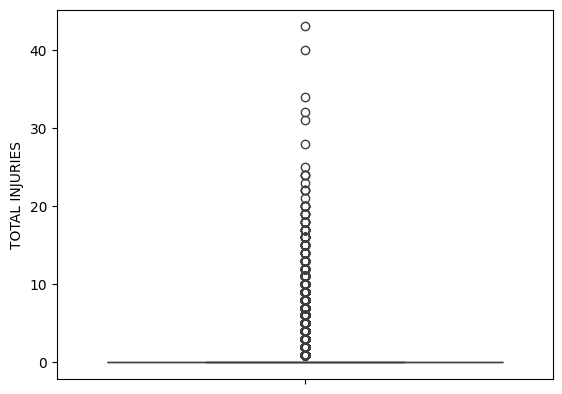

In [ ]:
sns.boxplot(df['TOTAL INJURIES'])

In [ ]:
df['is_injured'] = ((df['NUMBER OF PERSONS INJURED'] > 0) | (df['NUMBER OF PERSONS KILLED'] > 0))

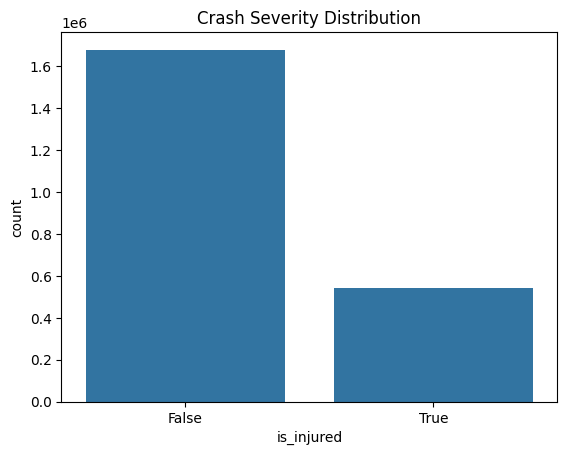

In [ ]:
sns.countplot(data=df, x='is_injured')
plt.title('Crash Severity Distribution')
plt.show()

In [ ]:
overall_prob = df['is_injured'].mean()
print("Probability of injury per collision (baseline):", overall_prob)

Probability of injury per collision (baseline): 0.24315176009959763


In [ ]:
# odd of injury per crash
overall_prob/(1-overall_prob)

np.float64(0.32126884529928385)

### Weather Factors

In [ ]:
# PRCP level
df_full['PRCP'] = df_full['PRCP'].fillna(0)
group1 = df_full[df_full['is_injured'] == True]['PRCP']
group0 = df_full[df_full['is_injured'] == False]['PRCP']
t_stat, p_value = ttest_ind(group1, group0, equal_var=False)
print(t_stat)
print(p_value)
if p_value < 0.05:
  print("There's difference between 2 groups")
else:
  print("Not enough evidence")

1.8659899716424726
0.06204309795260578
Not enough evidence


In [ ]:
contingency('PRECIP_GT_0.1')

is_injured       False   True 
PRECIP_GT_0.1                 
False          1169507  375048
True            508365  164000

P(Injury|PRECIP_GT_0.1 = True): 0.2439
P(Injury|PRECIP_GT_0.1 = False): 0.2428

Chi-square: 3.0499670963423537
p-value: 0.08073877862840546
Degrees of freedom: 1
Expected frequencies: [[1168993.73317937  375561.26682063]
 [ 508878.26682063  163486.73317937]]

pvalue > 0.05: Not enough evidence for PRECIP_GT_0.1


PRCP is not a prospect variable for P(injury)

In [ ]:
# TAVG
df_full['TAVG'] = df_full['TAVG'].fillna(0)
group1 = df_full[df_full['is_injured'] == True]['PRCP']
group0 = df_full[df_full['is_injured'] == False]['PRCP']
t_stat, p_value = ttest_ind(group1, group0, equal_var=False)
print(t_stat)
print(p_value)
if p_value < 0.05:
  print("There's difference between 2 groups")
else:
  print("Not enough evidence")

1.8659899716424726
0.06204309795260578
Not enough evidence


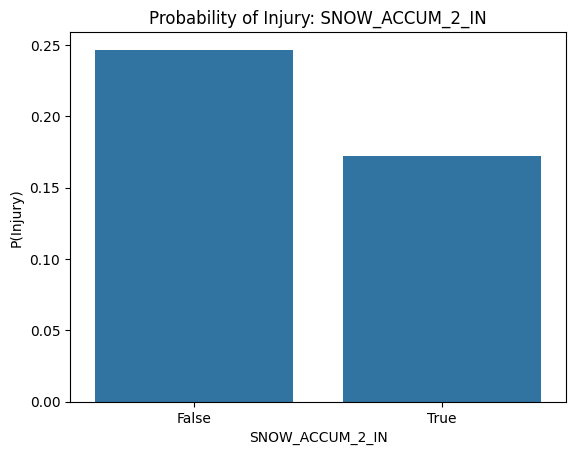

In [ ]:
injury_prob = df_full.groupby('SNOW_ACCUM_2_IN')['is_injured'].mean().reset_index()
sns.barplot(data=injury_prob, x='SNOW_ACCUM_2_IN', y='is_injured')
plt.title('Probability of Injury: SNOW_ACCUM_2_IN')
plt.ylabel('P(Injury)')
plt.show()

In [ ]:
contingency('SNOW_ACCUM_2_IN')

is_injured         False   True 
SNOW_ACCUM_2_IN                 
False            1590211  520821
True               87661   18227

P(Injury|SNOW_ACCUM_2_IN = True): 0.1721
P(Injury|SNOW_ACCUM_2_IN = False): 0.2467

Chi-square: 3047.075741208077
p-value: 0.0
Degrees of freedom: 1
Expected frequencies: [[1597730.85357343  513301.14642657]
 [  80141.14642657   25746.85357343]]

pvalue <= 0.05: Enough evidence for SNOW_ACCUM_2_IN


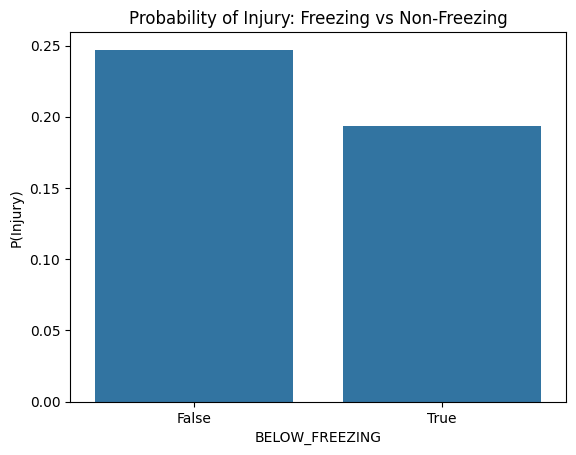

In [ ]:
injury_prob = df_full.groupby('BELOW_FREEZING')['is_injured'].mean().reset_index()
sns.barplot(data=injury_prob, x='BELOW_FREEZING', y='is_injured')
plt.title('Probability of Injury: Freezing vs Non-Freezing')
plt.ylabel('P(Injury)')
plt.show()

In [ ]:
contingency('BELOW_FREEZING')

is_injured        False   True 
BELOW_FREEZING                 
False           1546675  507531
True             131197   31517

P(Injury|BELOW_FREEZING = True): 0.1937
P(Injury|BELOW_FREEZING = False): 0.2471

Chi-square: 2333.619350413781
p-value: 0.0
Degrees of freedom: 1
Expected frequencies: [[1554722.19549285  499483.80450715]
 [ 123149.80450715   39564.19549285]]

pvalue <= 0.05: Enough evidence for BELOW_FREEZING


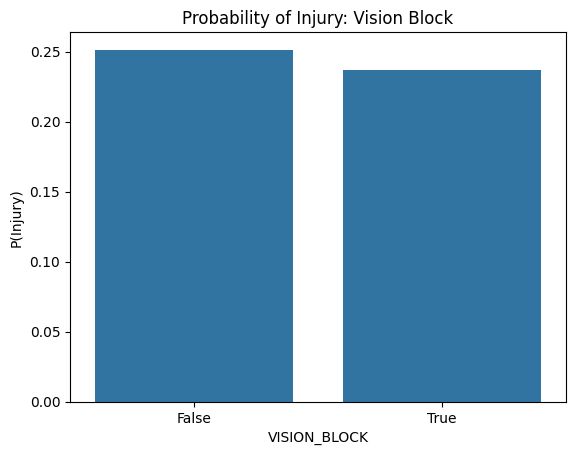

In [ ]:
injury_prob = df_full.groupby('VISION_BLOCK')['is_injured'].mean().reset_index()
sns.barplot(data=injury_prob, x='VISION_BLOCK', y='is_injured')
plt.title('Probability of Injury: Vision Block')
plt.ylabel('P(Injury)')
plt.show()

In [ ]:
contingency('VISION_BLOCK')

is_injured     False   True 
VISION_BLOCK                
False         703418  236239
True          974454  302809

P(Injury|VISION_BLOCK = True): 0.2371
P(Injury|VISION_BLOCK = False): 0.2514

Chi-square: 604.3008681507021
p-value: 1.942367958838946e-133
Degrees of freedom: 1
Expected frequencies: [[711177.74656009 228479.25343991]
 [966694.25343991 310568.74656009]]

pvalue <= 0.05: Enough evidence for VISION_BLOCK


### Temporal Factors
- Hour of day
- Day of Week/Weekend
- Month
- Holiday
- Busy Hour

#### **Hour of Day, Day of Week, Weekend**

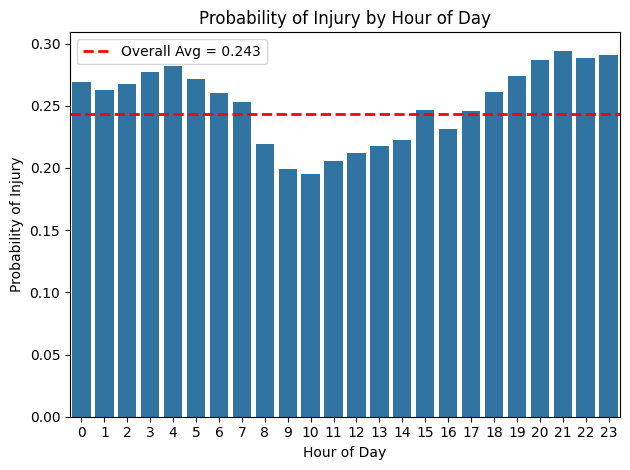

In [ ]:
df['CRASH TIME'] = pd.to_numeric(df['CRASH TIME'])
injury_by_hour = df.groupby('CRASH TIME')['is_injured'].mean().sort_index()
sns.barplot(x=injury_by_hour.index,y=injury_by_hour.values)
plt.axhline(overall_prob, color='red', linestyle='--', linewidth=2, label=f'Overall Avg = {overall_prob:.3f}')
plt.title("Probability of Injury by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Probability of Injury")
plt.legend()
plt.tight_layout()
plt.show()

DAY OF WEEK
0    0.240521
1    0.241261
2    0.242474
3    0.239370
4    0.239051
5    0.248029
6    0.253990
Name: is_injured, dtype: float64


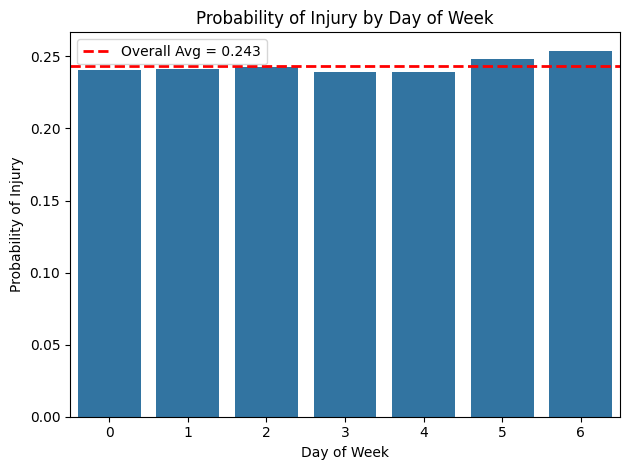

In [ ]:
injury_by_day = df.groupby('DAY OF WEEK')['is_injured'].mean()
print(injury_by_day)
sns.barplot(x=injury_by_day.index,y=injury_by_day.values)
plt.axhline(overall_prob, color='red', linestyle='--', linewidth=2, label=f'Overall Avg = {overall_prob:.3f}')
plt.title("Probability of Injury by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Probability of Injury")
plt.legend()
plt.tight_layout()
plt.show()

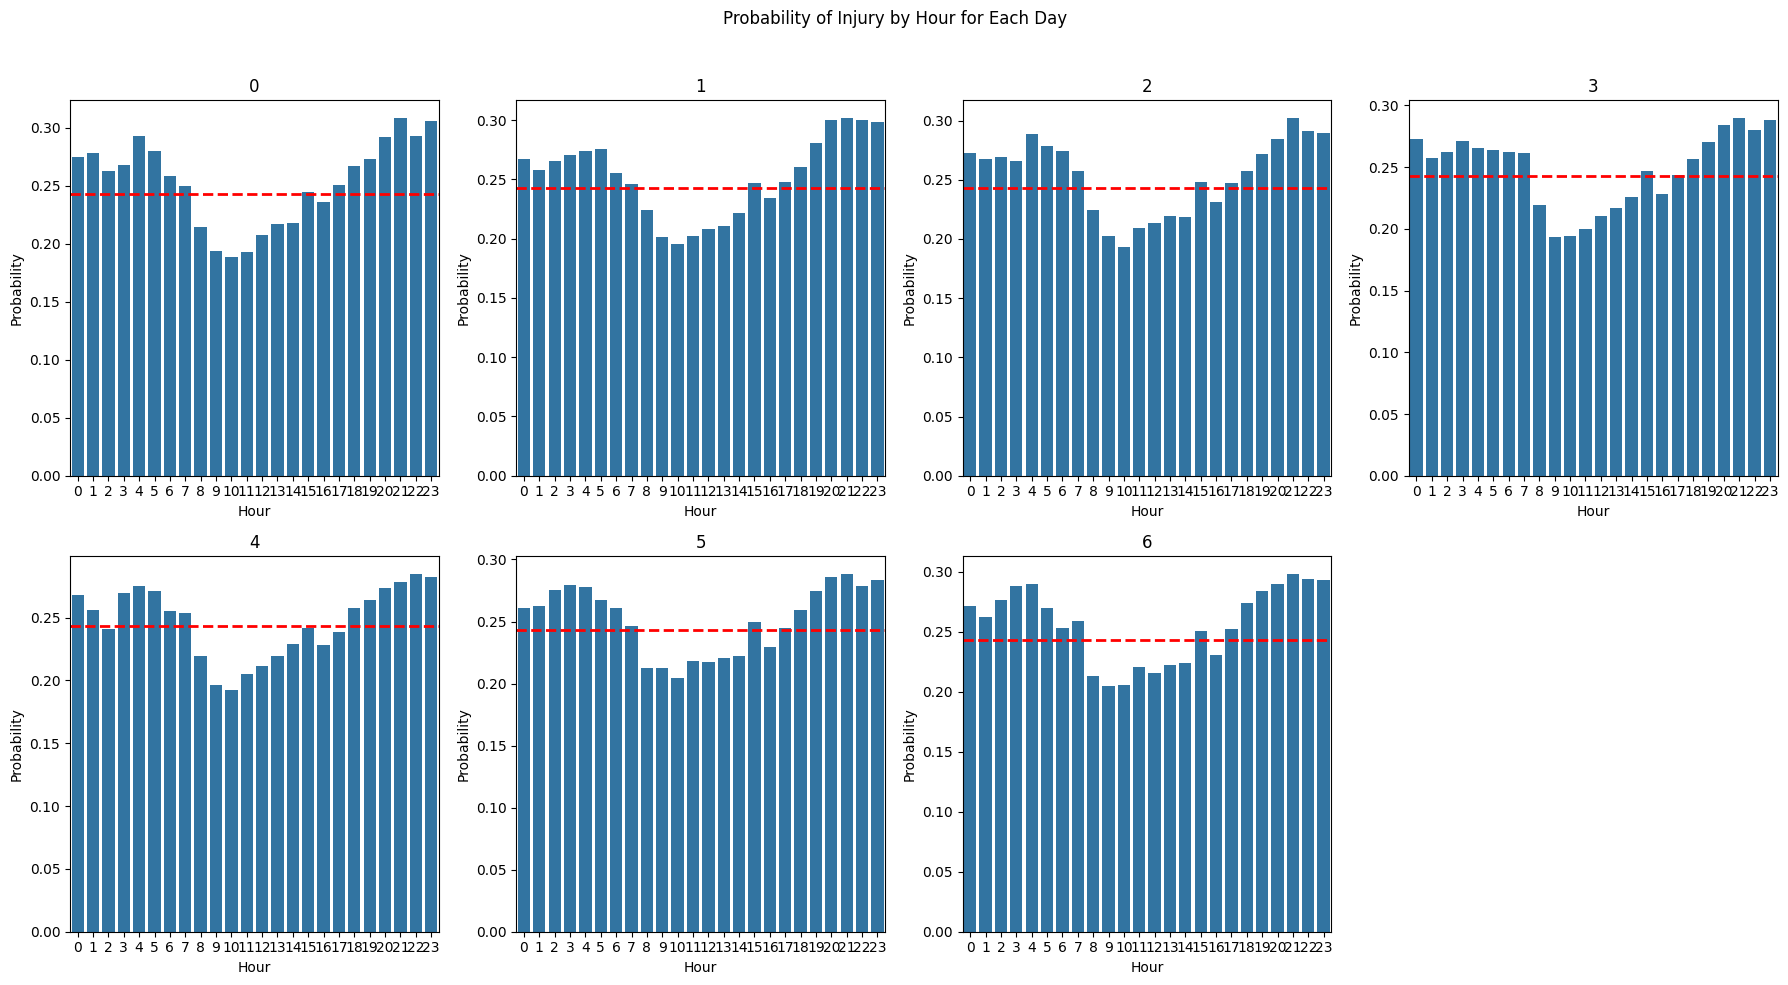

In [ ]:
# Is there a pattern amongst the hour of each day of the week?
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()
days = sorted(df['DAY OF WEEK'].unique())
for i, d in enumerate(days):
    ax = axes[i]
    df_d = df[df['DAY OF WEEK'] == d]
    injury_by_hour_d = (df_d.groupby('CRASH TIME')['is_injured'].mean().sort_index())
    sns.barplot(x=injury_by_hour_d.index,y=injury_by_hour_d.values,ax=ax)
    ax.axhline(overall_prob, color='red', linestyle='--', linewidth=2)
    ax.set_title(f"{d}")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Probability")
for j in range(len(days), len(axes)):
    fig.delaxes(axes[j])
plt.suptitle("Probability of Injury by Hour for Each Day")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Slight difference between day 5,6 (weekend) and the rest of the week (weekdays).

In [ ]:
df_full['IS_WEEKEND'] = (df_full['DAY OF WEEK'] > 4)

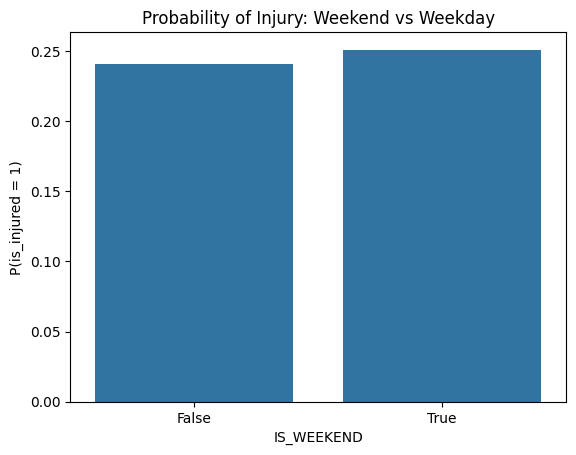

In [ ]:
prob_weekend = df_full.groupby('IS_WEEKEND')['is_injured'].mean().reset_index()

sns.barplot(data=prob_weekend, x='IS_WEEKEND', y='is_injured')
plt.title('Probability of Injury: Weekend vs Weekday')
plt.ylabel('P(is_injured = 1)')
plt.show()

In [ ]:
contingency('IS_WEEKEND')

is_injured    False   True 
IS_WEEKEND                 
False       1252669  396675
True         425203  142373

P(Injury|IS_WEEKEND = True): 0.2508
P(Injury|IS_WEEKEND = False): 0.2405

Chi-square: 245.23132474467332
p-value: 2.845072047087312e-55
Degrees of freedom: 1
Expected frequencies: [[1248303.10339029  401040.89660971]
 [ 429568.89660971  138007.10339029]]

pvalue <= 0.05: Enough evidence for IS_WEEKEND


#### **Month**

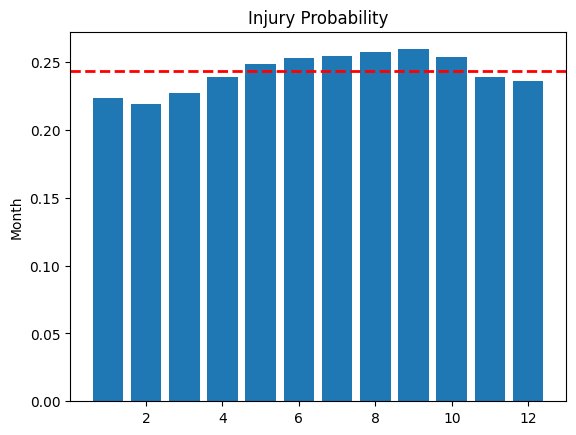

In [ ]:
df['MONTH'] = df['CRASH DATE'].dt.month
monthly_mean = df['is_injured'].mean()
monthly_prob = df.groupby('MONTH')['is_injured'].mean()
plt.bar(monthly_prob.index,monthly_prob.values)
plt.axhline(monthly_mean, color='red', linestyle='--', linewidth=2)
plt.ylabel('Month')
plt.title('Injury Probability')
plt.show()

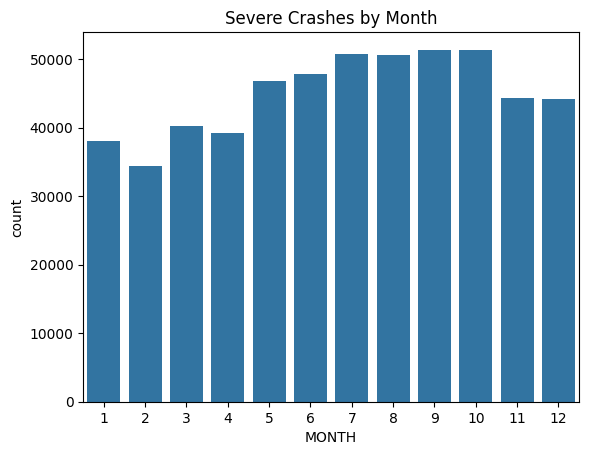

In [ ]:
sns.countplot(data=df[df['is_injured']==1], x='MONTH')
plt.title('Severe Crashes by Month')
plt.show()

In [ ]:
contingency_table = pd.crosstab(df['MONTH'], df['is_injured'])

chi2, p, dof, ex = chi2_contingency(contingency_table)
print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 2056.9309414775444
p-value: 0.0


#### **Holiday**
There is no specification for holiday dates from the dataset. This is our rule for marking the data into the following dates, assuming holiday oftern leads to different traffic patterns. The holidays are federal holiday and popular holidays:
* Christmas Week: Dec 21 - Dec 27  
* New Year: Dec 31 - Jan 2  
* Thanksgiving Day (Fourth Thursday in November): The Wednesday before this to the Friday after that day
* Birthday of Martin Luther King, Jr. (Third Monday in January)
* Washington's Birthday (Also known as Presidents Day; third Monday in February)
* Memorial Day (Last Monday in May)
* Juneteenth National (June 19)
* Independence Day: July 3 - July 5
* Labor Day (First Monday in September): The Saturday before that to the Tuesday after that
* Columbus Day (Second Monday in October): The Saturday before that to the Tuesday after that
* Veterans Day (November 11)


In [ ]:
df_full['IS_HOLIDAY'] = False
df_full['CRASH DATE'] = pd.to_datetime(df_full['CRASH DATE'])

# Extract year, month, day
years = df_full['CRASH DATE'].dt.year
def nth_weekday_of_month(year, month, weekday, n):
    """weekday: Monday=0 ... Sunday=6"""
    d = pd.Timestamp(year, month, 1)
    # Move forward until weekday matches
    while d.weekday() != weekday:
        d += pd.Timedelta(days=1)
    # Add 7*(n-1) days
    return d + pd.Timedelta(days=7*(n-1))
def last_weekday_of_month(year, month, weekday):
    d = pd.Timestamp(year, month + 1, 1) - pd.Timedelta(days=1)
    while d.weekday() != weekday:
        d -= pd.Timedelta(days=1)
    return d
years_unique = years.unique()
holiday_windows = []
for y in years_unique:
    holiday_windows.append((pd.Timestamp(y,12,21), pd.Timestamp(y,12,27)))
for y in years_unique:
    holiday_windows.append((pd.Timestamp(y-1,12,31), pd.Timestamp(y,1,2)))
for y in years_unique:
    thanksgiving = nth_weekday_of_month(y, 11, weekday=3, n=4)  # Thursday=3
    start = thanksgiving - pd.Timedelta(days=1)  # Wednesday
    end = thanksgiving + pd.Timedelta(days=1)    # Friday
    holiday_windows.append((start, end))
for y in years_unique:
    mlk = nth_weekday_of_month(y, 1, weekday=0, n=3)
    holiday_windows.append((mlk, mlk))
for y in years_unique:
    pres = nth_weekday_of_month(y, 2, weekday=0, n=3)
    holiday_windows.append((pres, pres))
for y in years_unique:
    mem = last_weekday_of_month(y, 5, weekday=0)
    holiday_windows.append((mem, mem))
for y in years_unique:
    holiday_windows.append((pd.Timestamp(y,6,19), pd.Timestamp(y,6,19)))
for y in years_unique:
    holiday_windows.append((pd.Timestamp(y,7,3), pd.Timestamp(y,7,5)))
for y in years_unique:
    labor = nth_weekday_of_month(y, 9, weekday=0, n=1)
    start = labor - pd.Timedelta(days=2)  # Saturday before
    end = labor + pd.Timedelta(days=1)    # Tuesday after
    holiday_windows.append((start, end))
for y in years_unique:
    col = nth_weekday_of_month(y, 10, weekday=0, n=2)
    start = col - pd.Timedelta(days=2)
    end = col + pd.Timedelta(days=1)
    holiday_windows.append((start, end))
for y in years_unique:
    holiday_windows.append((pd.Timestamp(y,10,31), pd.Timestamp(y,10,31)))

for y in years_unique:
    holiday_windows.append((pd.Timestamp(y,3,17), pd.Timestamp(y,3,17)))

for y in years_unique:
    holiday_windows.append((pd.Timestamp(y,2,14), pd.Timestamp(y,2,14)))


holiday_mask = np.zeros(len(df_full), dtype=bool)

for start, end in holiday_windows:
    holiday_mask |= (df_full['CRASH DATE'] >= start) & (df_full['CRASH DATE'] <= end)

df_full['IS_HOLIDAY'] = holiday_mask

<Axes: xlabel='IS_HOLIDAY', ylabel='is_injured'>

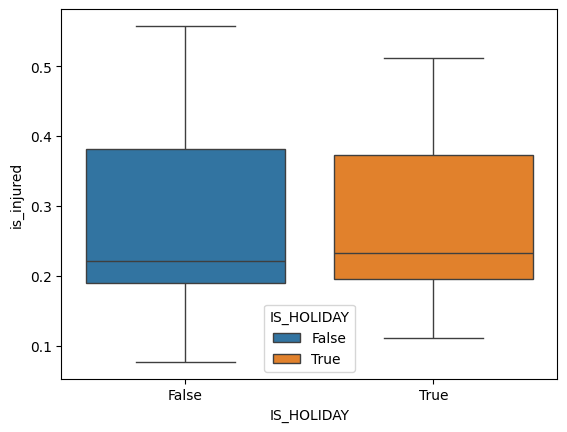

In [ ]:
injury_prob = df_full.groupby(['CRASH DATE', 'IS_HOLIDAY'])['is_injured'].mean().reset_index()
sns.boxplot(
    data=injury_prob,
    x="IS_HOLIDAY",
    y="is_injured",
    hue = 'IS_HOLIDAY'
)

In [ ]:
contingency('IS_HOLIDAY')

is_injured    False   True 
IS_HOLIDAY                 
False       1548652  496571
True         129220   42477

P(Injury|IS_HOLIDAY = True): 0.2474
P(Injury|IS_HOLIDAY = False): 0.2428

Chi-square: 18.184835465732185
p-value: 2.00468705277727e-05
Degrees of freedom: 1
Expected frequencies: [[1547923.42775382  497299.57224618]
 [ 129948.57224618   41748.42775382]]

pvalue <= 0.05: Enough evidence for IS_HOLIDAY


#### **Busy Hour**
The data also doesn't specify busy hours, but we noticed a patterns in average traffic volume in the city between weekend and weekdays

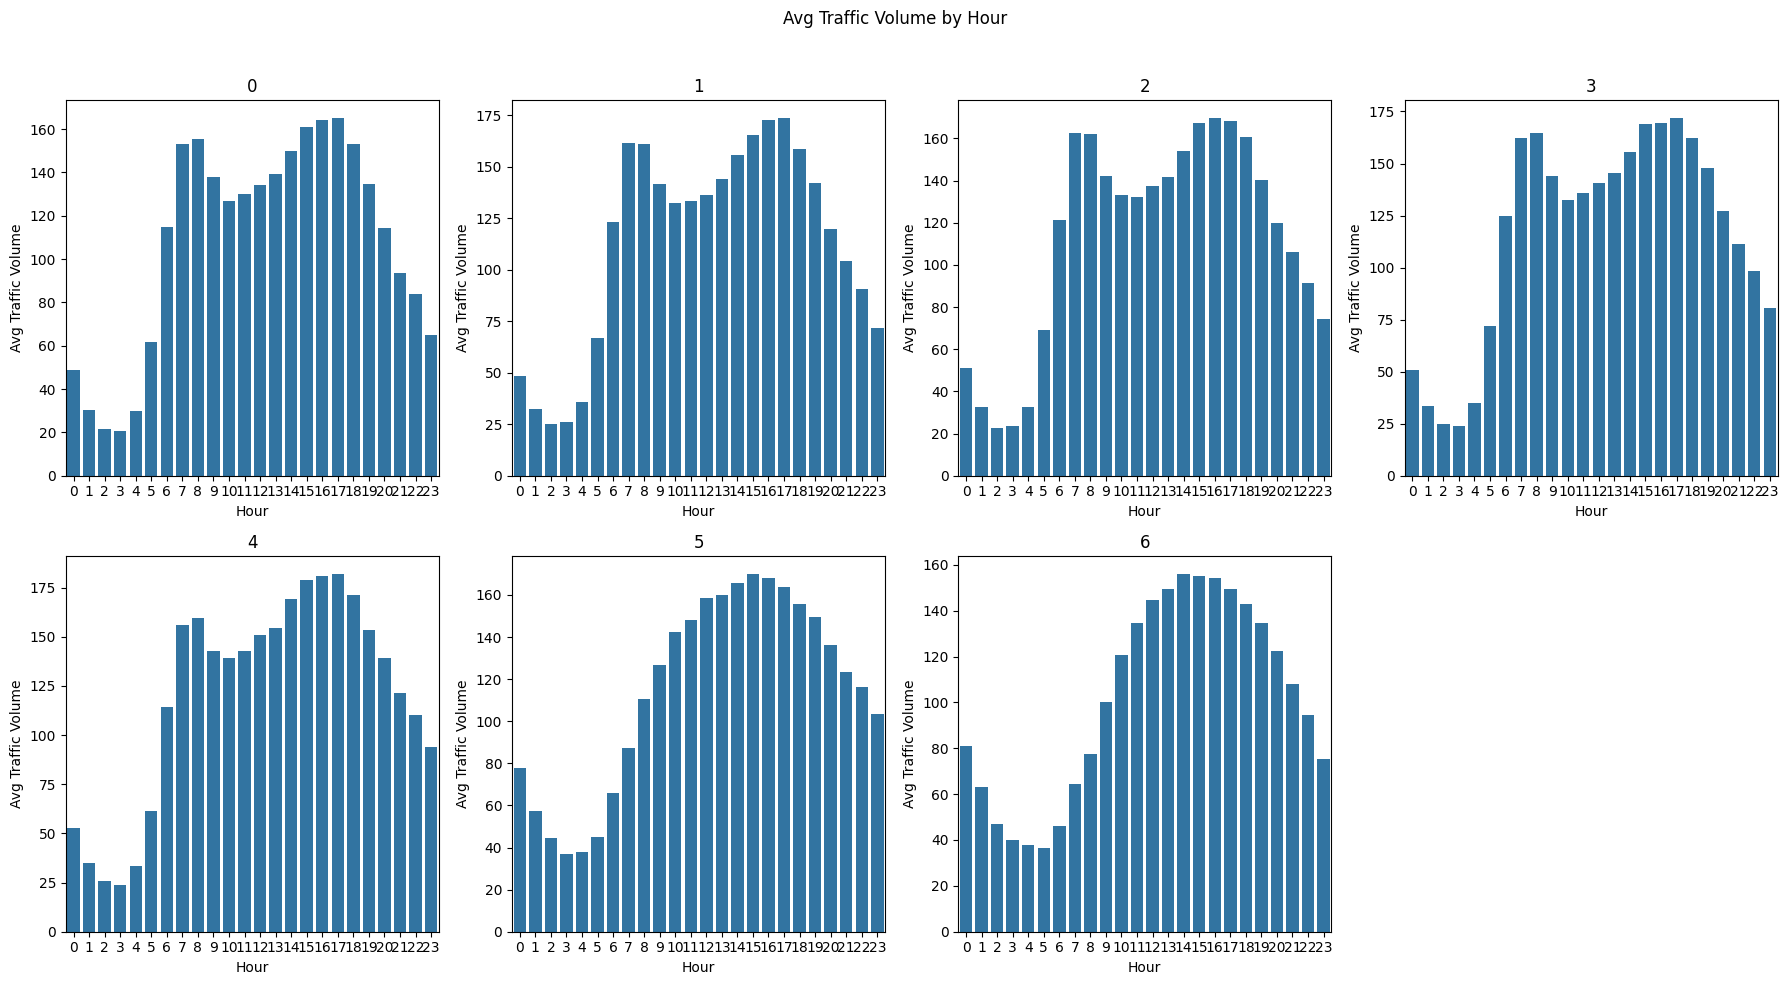

In [ ]:
traffic_check = df_full[~df_full['AVG TRAFFIC VOLUME'].isna()]
traffic_check = traffic_check.groupby(['DAY OF WEEK', 'CRASH TIME'])['AVG TRAFFIC VOLUME'].mean().reset_index()
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()
days = sorted(traffic_check['DAY OF WEEK'].unique())
for i, d in enumerate(days):
    ax = axes[i]
    df_d = traffic_check[traffic_check['DAY OF WEEK'] == d]
    injury_by_hour_d = (df_d.groupby('CRASH TIME')['AVG TRAFFIC VOLUME'].mean().sort_index())
    sns.barplot(x=injury_by_hour_d.index,y=injury_by_hour_d.values,ax=ax)
    ax.set_title(f"{d}")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Avg Traffic Volume")
for j in range(len(days), len(axes)):
    fig.delaxes(axes[j])
plt.suptitle("Avg Traffic Volume by Hour")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

We notice that weekdays (Monday to Friday) shares similar peak hour from 7 a.m to 9 a.m and 4 p.m to 6 p.m, while weekend is 2 p.m to 6 p.m

In [ ]:
df_full[df_full['AVG TRAFFIC VOLUME'].isnull()]['COLLISION_ID'].nunique()/df_full['COLLISION_ID'].nunique()

0.17119020984067987

17% of the collisions miss traffic volume values

In [ ]:
traffic_volume = pd.read_csv("Automated_Traffic_Volume_Counts.csv")
traffic_volume["Date"] = pd.to_datetime(
    traffic_volume["Yr"].astype(str) + "-" +
    traffic_volume["M"].astype(str) + "-" +
    traffic_volume["D"].astype(str)
)
traffic_volume['DAY OF WEEK'] = traffic_volume['Date'].dt.dayofweek
traffic_volume = traffic_volume.rename(columns={'HH':'CRASH TIME'})
traffic_volume["CRASH DATE"] = pd.to_datetime(
    traffic_volume["Yr"].astype(str) + "-" +
    traffic_volume["M"].astype(str) + "-" +
    traffic_volume["D"].astype(str))

traffic_volume_avg = traffic_volume[traffic_volume.Yr >= 2012].groupby(['Yr', 'M', 'DAY OF WEEK', 'CRASH TIME'])['Vol'].mean().reset_index()
traffic_volume_avg = traffic_volume_avg.rename(columns={'Vol': 'AVG TRAFFIC VOLUME'})


In [ ]:
df_full = df_full.drop(columns={'AVG TRAFFIC VOLUME'})
df_full['CRASH_YEAR'] = df_full['CRASH DATE'].dt.year
df_full['CRASH_MONTH'] = df_full['CRASH DATE'].dt.month
df_full[['CRASH_YEAR', 'CRASH_MONTH', 'DAY OF WEEK', 'CRASH TIME']] = df_full[['CRASH_YEAR', 'CRASH_MONTH', 'DAY OF WEEK', 'CRASH TIME']].astype('int')
traffic_volume_avg = traffic_volume_avg.rename(columns={'Yr':'CRASH_YEAR', 'M': "CRASH_MONTH"})
traffic_volume_avg[['CRASH_YEAR', 'CRASH_MONTH', 'DAY OF WEEK', 'CRASH TIME']] = traffic_volume_avg[['CRASH_YEAR', 'CRASH_MONTH', 'DAY OF WEEK', 'CRASH TIME']].astype('int')
df_full = df_full.merge(traffic_volume_avg, on = ['CRASH_YEAR', 'CRASH_MONTH', 'DAY OF WEEK', 'CRASH TIME'], how='left')
group_means = (
    df_full
    .groupby(['CRASH_YEAR', 'CRASH_MONTH', 'IS_WEEKEND', 'CRASH TIME'])['AVG TRAFFIC VOLUME']
    .mean())

df_full['group_mean'] = df_full.set_index(
    ['CRASH_YEAR', 'CRASH_MONTH', 'IS_WEEKEND', 'CRASH TIME']).index.map(group_means)

df_full['AVG TRAFFIC VOLUME'] = df_full['AVG TRAFFIC VOLUME'].fillna(df_full['group_mean'])

df_full['AVG TRAFFIC VOLUME'] = (
    df_full['AVG TRAFFIC VOLUME']
        .fillna(method='ffill')
        .fillna(method='bfill'))

/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_23761/2222069890.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_23761/2222069890.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill'))


In [ ]:
df_full['BUSY HOUR'] = (
    # weekday
    ((df_full['IS_WEEKEND'] == False) &
        (((df_full['CRASH TIME'] >= 7) & (df_full['CRASH TIME'] <= 9)) |
        ((df_full['CRASH TIME'] >= 16) & (df_full['CRASH TIME'] <= 18)))) |
        ((df_full['IS_WEEKEND'] == True) & ((df_full['CRASH TIME'] >= 14) & (df_full['CRASH TIME'] <= 18))))

<Axes: xlabel='BUSY HOUR', ylabel='is_injured'>

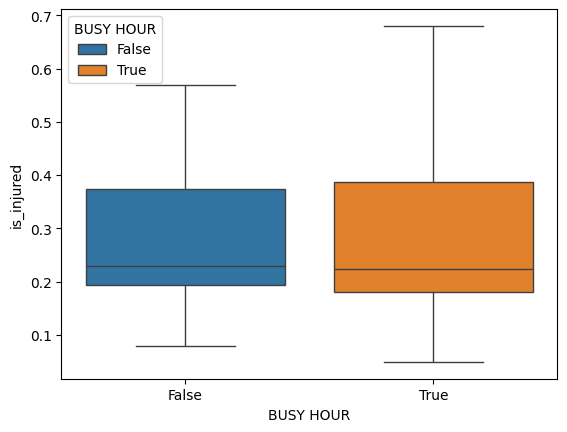

In [ ]:
injury_prob = df_full.groupby(['CRASH DATE', 'BUSY HOUR'])['is_injured'].mean().reset_index()
sns.boxplot(
    data=injury_prob,
    x="BUSY HOUR",
    y="is_injured",
    hue = 'BUSY HOUR'
)

In [ ]:
contingency("BUSY HOUR")

is_injured    False   True 
BUSY HOUR                  
False       1081394  355027
True         596478  184021

P(Injury|BUSY HOUR = True): 0.2358
P(Injury|BUSY HOUR = False): 0.2472

Chi-square: 356.2739245343247
p-value: 1.823634308979705e-79
Degrees of freedom: 1
Expected frequencies: [[1087152.70560598  349268.29439402]
 [ 590719.29439402  189779.70560598]]

pvalue <= 0.05: Enough evidence for BUSY HOUR


### Traffic

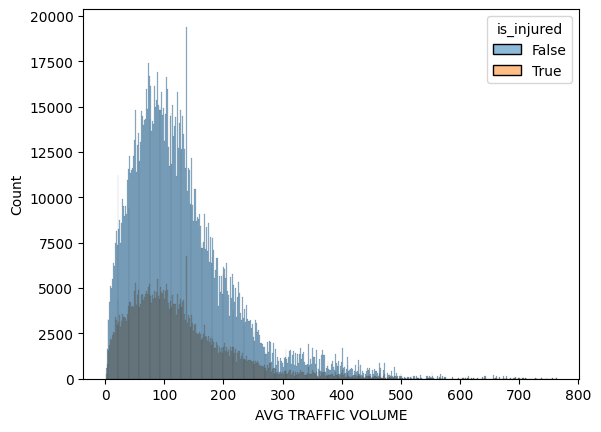

In [ ]:
# Is probability of injury higher in lower traffic volume or higher traffic volume?
injury_prob = df_full.groupby('is_injured')['AVG TRAFFIC VOLUME'].mean().reset_index()
sns.histplot(data=df_full, x='AVG TRAFFIC VOLUME', hue = 'is_injured')
plt.show()

In [ ]:
# Independent t-test
group1 = df_full[df_full['is_injured'] == True]['AVG TRAFFIC VOLUME']
group0 = df_full[df_full['is_injured'] == False]['AVG TRAFFIC VOLUME']
t_stat, p_value = ttest_ind(group1, group0, equal_var=False)
print(t_stat)
print(p_value)
if p_value < 0.05:
  print("There is evidence for difference between 2 group")
else:
  print("Not enough evidence")

-26.02148892799754
3.213202684000935e-149
There is evidence for difference between 2 group


### Environment Factors
* Borough
* Environment/Roadway as contributing factor

#### **Borough**

In [ ]:
injury_by_borough = df.groupby('BOROUGH')['is_injured'].mean().sort_values(ascending=False)
print(injury_by_borough)

BOROUGH
BROOKLYN         0.263611
BRONX            0.254870
QUEENS           0.239767
STATEN ISLAND    0.220660
MANHATTAN        0.191135
Name: is_injured, dtype: float64


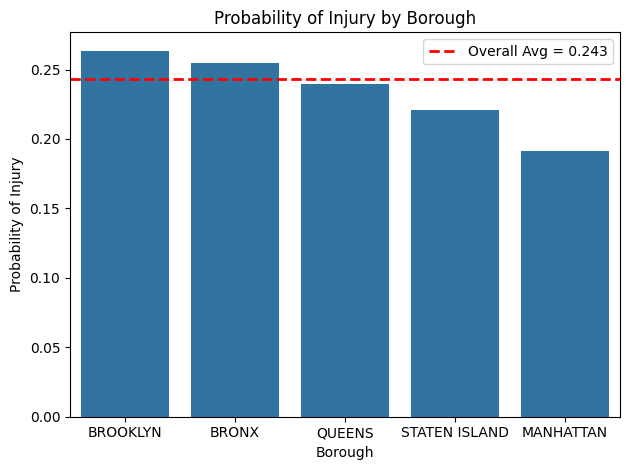

In [ ]:
sns.barplot(x=injury_by_borough.index,y=injury_by_borough.values)
plt.axhline(overall_prob, color='red', linestyle='--', linewidth=2, label=f'Overall Avg = {overall_prob:.3f}')
plt.title("Probability of Injury by Borough")
plt.xlabel("Borough")
plt.ylabel("Probability of Injury")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
prob_boro_hour = (df.groupby(['BOROUGH', 'CRASH TIME'])['is_injured'].mean().unstack())
prob_boro_hour

CRASH TIME           0         1         2         3         4         5   \
BOROUGH                                                                     
BRONX          0.270378  0.247666  0.264706  0.259848  0.260400  0.254041   
BROOKLYN       0.292267  0.288619  0.279058  0.288676  0.281126  0.272713   
MANHATTAN      0.208540  0.201079  0.220989  0.234478  0.241634  0.244289   
QUEENS         0.249269  0.237099  0.227751  0.224288  0.249406  0.248292   
STATEN ISLAND  0.248684  0.205314  0.221154  0.215839  0.209106  0.250712   

CRASH TIME           6         7         8         9   ...        14  \
BOROUGH                                                ...             
BRONX          0.250755  0.236626  0.220229  0.200131  ...  0.238994   
BROOKLYN       0.274334  0.275733  0.234624  0.214278  ...  0.238980   
MANHATTAN      0.227376  0.203976  0.172121  0.156241  ...  0.170637   
QUEENS         0.252743  0.256462  0.224410  0.200779  ...  0.219664   
STATEN ISLAND  0.263158  0.293397  0.213960  0.171482  ...  0.206889   

CRASH TIME           15        16        17        18        19        20  \
BOROUGH                                                                     
BRONX          0.265266  0.251225  0.265680  0.287291  0.298810  0.309538   
BROOKLYN       0.267447  0.251939  0.272704  0.299429  0.313457  0.325396   
MANHATTAN      0.193033  0.184386  0.190963  0.202997  0.219758  0.229830   
QUEENS         0.247698  0.236343  0.246879  0.268808  0.273021  0.282305   
STATEN ISLAND  0.234592  0.215379  0.226202  0.235931  0.239677  0.238918   

CRASH TIME           21        22        23  
BOROUGH                                      
BRONX          0.312962  0.303192  0.306189  
BROOKLYN       0.331757  0.319787  0.319944  
MANHATTAN      0.236491  0.222029  0.219173  
QUEENS         0.280474  0.284249  0.276661  
STATEN ISLAND  0.259598  0.230055  0.251673  

[5 rows x 24 columns]

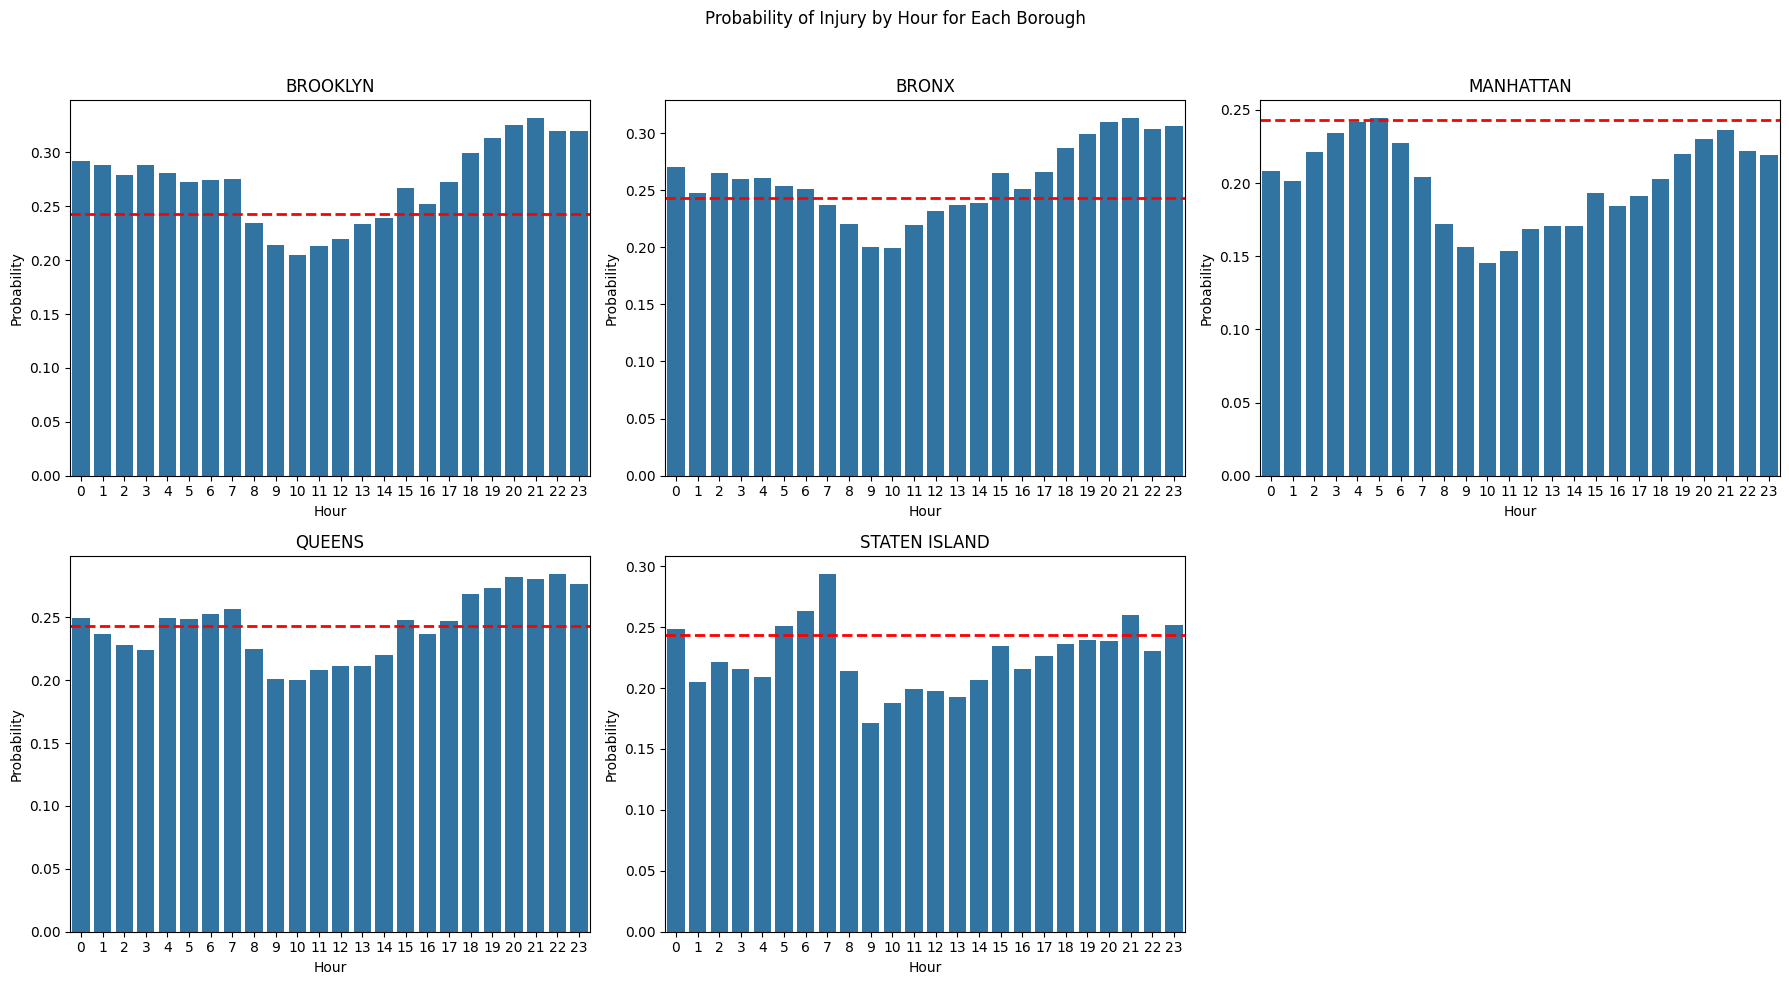

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
boroughs = df['BOROUGH'].dropna().unique()
for i, b in enumerate(boroughs):
    ax = axes[i]
    df_b = df[df['BOROUGH'] == b]
    injury_by_hour_b = (df_b.groupby('CRASH TIME')['is_injured'].mean().sort_index())
    sns.barplot(x=injury_by_hour_b.index,y=injury_by_hour_b.values,ax=ax)
    ax.axhline(overall_prob, color='red', linestyle='--', linewidth=2)
    ax.set_title(f"{b}")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Probability")
for j in range(len(boroughs), 6):
    fig.delaxes(axes[j])
plt.suptitle("Probability of Injury by Hour for Each Borough")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
df[df['BOROUGH'].isnull()]['COLLISION_ID'].nunique()/df['COLLISION_ID'].nunique()

0.30653474189415947

Although boroughs can be meaningful in p(injury) pattern but 30.6% of boroughs data is missing, this should be carefully considered in the model

#### **Environment/Roadway**
There's no distinctive attribute for Environment/Roadway factors from the data, but there is 5 possible contributing factors, many of which can be categorized as Environment/Roadway; the rest can be categorized into categories under Human Factors.

In [ ]:
factor_cols = ['CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2','CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5']
df_factors = (
    df_full.melt(
        id_vars=['COLLISION_ID', 'TOTAL INJURIES'],
        value_vars=factor_cols,
        var_name='FACTOR_COL',
        value_name='FACTOR'))
df_factors = df_factors[df_factors['FACTOR'].notna()]
injury_by_factor = df_factors.groupby('FACTOR')['TOTAL INJURIES'].sum().sort_values(ascending=False).reset_index()
injury_by_factor = injury_by_factor[injury_by_factor['FACTOR'] != 'Unspecified']
df_factors_present = df_factors[df_factors['FACTOR'] != 'Unspecified']
df_factors_present['IS_HUMAN'] = True
df_factors_present = df_factors_present[['COLLISION_ID', 'IS_HUMAN']].drop_duplicates()
df_full = df_full.merge(df_factors_present, on='COLLISION_ID', how='left')
df_full['IS_HUMAN'] = df_full['IS_HUMAN'].fillna(False)

factor_ls = injury_by_factor['FACTOR'].unique().tolist()


/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_23761/2689123651.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_factors_present['IS_HUMAN'] = True
/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_23761/2689123651.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_full['IS_HUMAN'] = df_full['IS_HUMAN'].fillna(False)


In [ ]:
driver_distraction = [
    'Driver Inattention/Distraction','Passenger Distraction','Outside Car Distraction',
    'Cell Phone (hand-Held)','Cell Phone (hand-held)','Cell Phone (hands-free)',
    'Texting','Using On Board Navigation Device','Listening/Using Headphones',
    'Eating or Drinking','Other Electronic Device','Reaction to Uninvolved Vehicle',
    'Reaction to Other Uninvolved Vehicle','View Obstructed/Limited','Glare']

driver_impairment = [
    'Fatigued/Drowsy','Fell Asleep','Lost Consciousness','Illness','Illnes',
    'Physical Disability','Alcohol Involvement','Drugs (illegal)',
    'Drugs (Illegal)','Prescription Medication']

driver_behavior = [
    'Failure to Yield Right-of-Way','Following Too Closely','Unsafe Speed',
    'Passing or Lane Usage Improper','Unsafe Lane Changing','Turning Improperly',
    'Driver Inexperience','Passing Too Closely','Aggressive Driving/Road Rage',
    'Backing Unsafely','Failure to Keep Right',
    'Traffic Control Disregarded','Traffic Control Device Improper/Non-Working',
    'Lane Marking Improper/Inadequate','Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
    'Oversized Vehicle']

vehicle_defect = [
    'Brakes Defective','Accelerator Defective','Steering Failure',
    'Tire Failure/Inadequate','Headlights Defective','Other Lighting Defects',
    'Tinted Windows','Windshield Inadequate','Tow Hitch Defective',
    'Vehicle Vandalism','Driverless/Runaway Vehicle','Other Vehicular']

environment_roadway = [
    'Pavement Slippery','Pavement Defective','Obstruction/Debris',
    'Shoulders Defective/Improper','Animals Action']

# Combine into a dictionary for lookup
factor_map = {}

for f in driver_distraction:
    factor_map[f] = 'Driver_Distraction'

for f in driver_impairment:
    factor_map[f] = 'Driver_Impairment'

for f in driver_behavior:
    factor_map[f] = 'Driver_Behavior'

for f in vehicle_defect:
    factor_map[f] = 'Vehicle_Defect'

for f in environment_roadway:
    factor_map[f] = 'Environment_Roadway'

In [ ]:
injury_by_factor['FACTOR_CATEGORY'] = injury_by_factor['FACTOR'].map(factor_map)
df_factors['FACTOR_CATEGORY'] = df_factors['FACTOR'].map(factor_map)

In [ ]:
df_factor_flags = (
    df_factors
    .assign(value=True)
    .pivot_table(
        index='COLLISION_ID',
        columns='FACTOR_CATEGORY',
        values='value',
        aggfunc='max',   # True if ANY row has that category
        fill_value=False
    )
    .reset_index()
)
df_factor_flags = df_factor_flags.reset_index()
df_factor_flags = df_factor_flags[['COLLISION_ID', 'Driver_Behavior', 'Driver_Distraction', 'Driver_Impairment', 'Environment_Roadway', 'Vehicle_Defect']]
df_full = df_full.merge(df_factor_flags, on=['COLLISION_ID'], how='left')

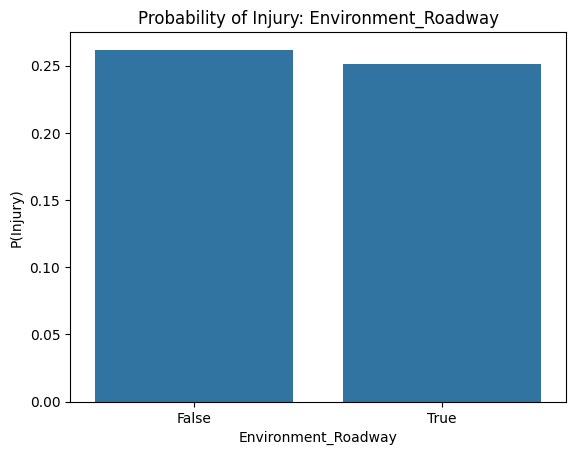

In [ ]:
injury_prob = df_full.groupby('Environment_Roadway')['is_injured'].mean().reset_index()
sns.barplot(data=injury_prob, x='Environment_Roadway', y='is_injured')
plt.title('Probability of Injury: Environment_Roadway')
plt.ylabel('P(Injury)')
plt.show()

In [ ]:
contingency("Environment_Roadway")

is_injured             False   True 
Environment_Roadway                 
False                1059165  375881
True                   23693    7957

P(Injury|Environment_Roadway = True): 0.2514
P(Injury|Environment_Roadway = False): 0.2619

Chi-square: 17.695117763375634
p-value: 2.592912566934164e-05
Degrees of freedom: 1
Expected frequencies: [[1059490.8839105  375555.1160895]
 [  23367.1160895    8282.8839105]]

pvalue <= 0.05: Enough evidence for Environment_Roadway


### Human Factors
* driver_distraction = Driver Inattention/Distraction','Passenger Distraction','Outside Car Distraction', 'Cell Phone (hand-Held)','Cell Phone (hand-held)','Cell Phone (hands-free)', 'Texting','Using On Board Navigation Device','Listening/Using Headphones', 'Eating or Drinking','Other Electronic Device','Reaction to Uninvolved Vehicle','Reaction to Other Uninvolved Vehicle','View Obstructed/Limited','Glare'

* driver_impairment = 'Fatigued/Drowsy','Fell Asleep','Lost Consciousness','Illness','Illnes', 'Physical Disability','Alcohol Involvement','Drugs (illegal)', 'Drugs (Illegal)','Prescription Medication'

* driver_behavior = 'Failure to Yield Right-of-Way','Following Too Closely','Unsafe Speed', 'Passing or Lane Usage Improper','Unsafe Lane Changing','Turning Improperly', 'Driver Inexperience','Passing Too Closely','Aggressive Driving/Road Rage', 'Backing Unsafely','Failure to Keep Right', 'Traffic Control Disregarded','Traffic Control Device Improper/Non-Working', 'Lane Marking Improper/Inadequate','Pedestrian/Bicyclist/Other Pedestrian Error/Confusion', 'Oversized Vehicle'

* vehicle_defect = 'Brakes Defective','Accelerator Defective','Steering Failure','Tire Failure/Inadequate','Headlights Defective','Other Lighting Defects','Tinted Windows','Windshield Inadequate','Tow Hitch Defective','Vehicle Vandalism','Driverless/Runaway Vehicle','Other Vehicular'


In [ ]:
human_factors = df_factors[df_factors['FACTOR_CATEGORY']!='Environment_Roadway']

In [ ]:
human_factors['is_injured'] = human_factors['TOTAL INJURIES'] > 0

/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_23761/4162490992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_factors['is_injured'] = human_factors['TOTAL INJURIES'] > 0


In [ ]:
# average injury probability for each contributing factor
factor_mean = human_factors['is_injured'].mean()
print("Probability of injury per contributing factor (baseline):", round(factor_mean,3))

Probability of injury per contributing factor (baseline): 0.233


In [ ]:
injury_by_factor = human_factors.groupby('FACTOR')['is_injured'].mean().sort_values(ascending=False)
injury_by_factor.describe()

count    56.000000
mean      0.293364
std       0.145710
min       0.072427
25%       0.182321
50%       0.269007
75%       0.359497
max       0.770836
Name: is_injured, dtype: float64

<Axes: >

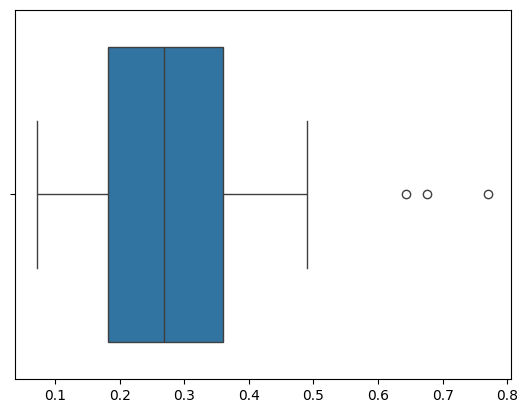

In [ ]:
sns.boxplot(x=injury_by_factor.values)

=> **Human Factors** (Driver Distraction, Behavior, Impairment, Vehicle Defect) may be an indicator for probability of injury prediction

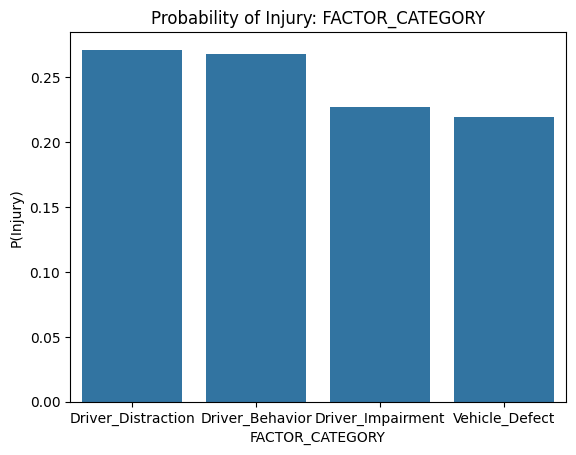

In [ ]:
injury_prob = human_factors[['COLLISION_ID', 'TOTAL INJURIES', 'FACTOR_CATEGORY', 'is_injured']].drop_duplicates()
injury_prob = injury_prob.groupby('FACTOR_CATEGORY')['is_injured'].mean().reset_index().sort_values(by='is_injured', ascending=False)
sns.barplot(data=injury_prob, x='FACTOR_CATEGORY', y='is_injured')
plt.title('Probability of Injury: FACTOR_CATEGORY')
plt.ylabel('P(Injury)')
plt.show()

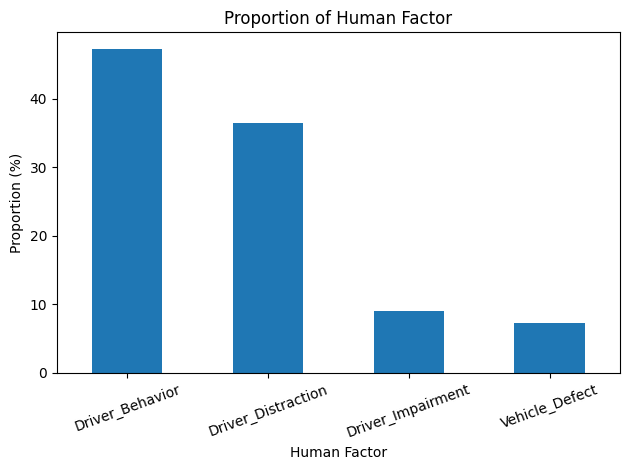

In [ ]:
prop = human_factors['FACTOR_CATEGORY'].value_counts(normalize=True).sort_values(ascending=False)

(prop * 100).plot(kind='bar')

plt.title("Proportion of Human Factor")
plt.xlabel("Human Factor")
plt.ylabel("Proportion (%)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

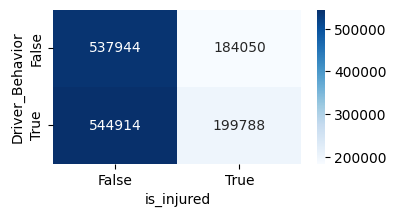

In [ ]:
ct = pd.crosstab(df_full['Driver_Behavior'], df_full['is_injured'])

plt.figure(figsize=(4,2))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.show()

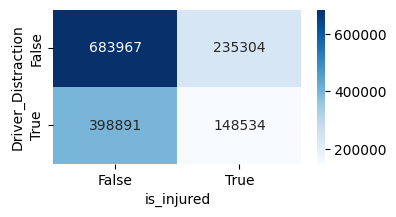

In [ ]:
ct = pd.crosstab(df_full['Driver_Distraction'], df_full['is_injured'])

plt.figure(figsize=(4,2))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.show()

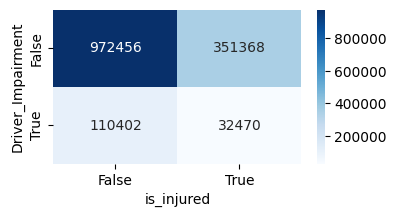

In [ ]:
ct = pd.crosstab(df_full['Driver_Impairment'], df_full['is_injured'])

plt.figure(figsize=(4,2))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.show()

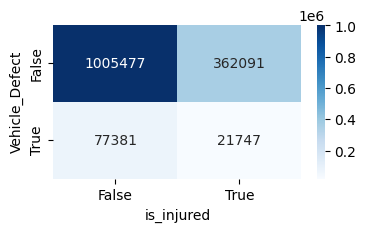

In [ ]:
ct = pd.crosstab(df_full['Vehicle_Defect'], df_full['is_injured'])

plt.figure(figsize=(4,2))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
factor_ls = human_factors['FACTOR_CATEGORY'].dropna().unique().tolist()
for cat in factor_ls:

    cat_str = str(cat)
    contingency(f'{cat_str}')
    print("__________")

is_injured        False   True 
Driver_Behavior                
False            537944  184050
True             544914  199788

P(Injury|Driver_Behavior = True): 0.2683
P(Injury|Driver_Behavior = False): 0.2549

Chi-square: 338.58521029441346
p-value: 1.2971448887192057e-75
Degrees of freedom: 1
Expected frequencies: [[533046.37010805 188947.62989195]
 [549811.62989195 194890.37010805]]

pvalue <= 0.05: Enough evidence for Driver_Behavior
__________
is_injured           False   True 
Driver_Distraction                
False               683967  235304
True                398891  148534

P(Injury|Driver_Distraction = True): 0.2713
P(Injury|Driver_Distraction = False): 0.256

Chi-square: 419.10300556486965
p-value: 3.825499971482223e-93
Degrees of freedom: 1
Expected frequencies: [[678695.48735253 240575.51264747]
 [404162.51264747 143262.48735253]]

pvalue <= 0.05: Enough evidence for Driver_Distraction
__________
is_injured        False   True 
Vehicle_Defect                 
False  

### Vehicle Factors

Overview of vehicles in the crash dataset

In [ ]:
vehicle_cols = ['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']
df_vehicles = (df.melt(
        id_vars=['COLLISION_ID', 'is_injured'],
        value_vars=vehicle_cols,
        var_name='VEHICLE_COL',
        value_name='VEHICLE_TYPE'))
injury_by_vehicle = (df_vehicles[~df_vehicles['VEHICLE_TYPE'].isna()].groupby('VEHICLE_TYPE')['is_injured'].mean().sort_values(ascending=False))
injury_by_vehicle.describe()

count    3034.000000
mean        0.269981
std         0.390021
min         0.000000
25%         0.000000
50%         0.000000
75%         0.500000
max         1.000000
Name: is_injured, dtype: float64

<Axes: xlabel='is_injured'>

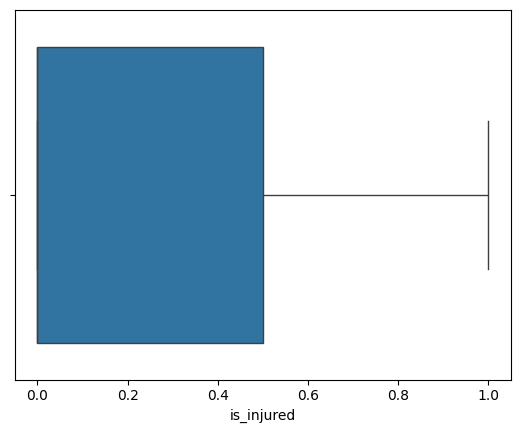

In [ ]:
sns.boxplot(x= injury_by_vehicle)

In [ ]:
df_vehicles2 = (df.melt(
        id_vars=['COLLISION_ID', 'NUMBER OF PERSONS INJURED'],
        value_vars=vehicle_cols,
        var_name='VEHICLE_COL',
        value_name='VEHICLE_TYPE'))
injury_by_vehicle_count = (df_vehicles2[~df_vehicles2['VEHICLE_TYPE'].isna()].groupby('VEHICLE_TYPE')['NUMBER OF PERSONS INJURED'].sum().sort_values(ascending=False))
injury_by_vehicle_count.describe()

count      3034.000000
mean        464.516809
std       11159.117630
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max      448801.000000
Name: NUMBER OF PERSONS INJURED, dtype: float64

In [ ]:
# fraction of (total injuries by each vehicle type/ total injuries) --> probability of injuries happen in each vehicle
vehicle_agg = df_vehicles2[~df_vehicles2['VEHICLE_TYPE'].isna()].groupby('VEHICLE_TYPE')['NUMBER OF PERSONS INJURED'].sum().sort_values(ascending=False).reset_index()
total_injury = df['NUMBER OF PERSONS INJURED'].sum()
vehicle_agg['FRACTION'] = vehicle_agg['NUMBER OF PERSONS INJURED']/total_injury
vehicle_agg

VEHICLE_TYPE  NUMBER OF PERSONS INJURED  FRACTION
0                                   Sedan                   448801.0  0.617498
1     Station Wagon/Sport Utility Vehicle                   348948.0  0.480112
2                       PASSENGER VEHICLE                   202923.0  0.279198
3           SPORT UTILITY / STATION WAGON                    87267.0  0.120069
4                                    Bike                    48338.0  0.066507
...                                   ...                        ...       ...
3029                                SANTI                        0.0  0.000000
3030                                EXPRE                        0.0  0.000000
3031                           SAND TRUCK                        0.0  0.000000
3032                                SANAT                        0.0  0.000000
3033                                 �MBU                        0.0  0.000000

[3034 rows x 3 columns]

In [ ]:
vehicle_agg['VEHICLE_TYPE'].nunique()

3034

In [ ]:
vehicle_agg[vehicle_agg['FRACTION'] > 0.01]['VEHICLE_TYPE'].nunique()/vehicle_agg['VEHICLE_TYPE'].nunique()

0.005603164139749505

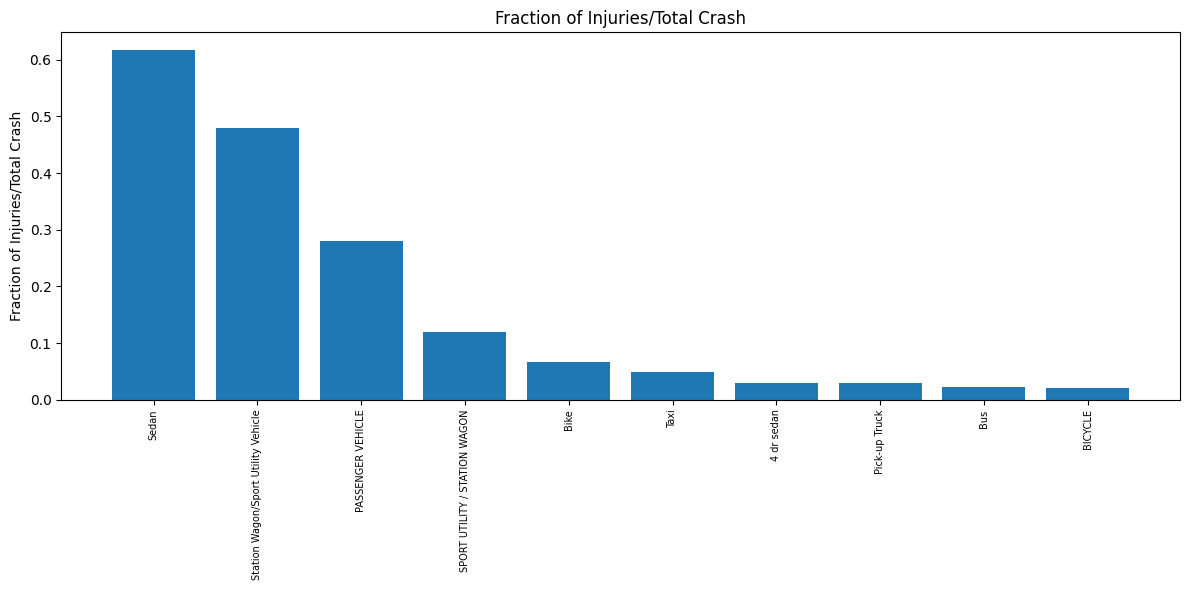

In [ ]:
vehicle_agg = vehicle_agg.sort_values(by=['FRACTION'], ascending=False)
vehicle_agg = vehicle_agg.head(10)
plt.figure(figsize=(12,6))
plt.bar(vehicle_agg['VEHICLE_TYPE'],vehicle_agg['FRACTION'])
plt.xticks(rotation=90, fontsize=7)
plt.ylabel('Fraction of Injuries/Total Crash')
plt.title('Fraction of Injuries/Total Crash')
plt.tight_layout()
plt.show()

==> Sedan is the most popular vehicles having injuries (Total Injuries caused by a Sedan/Total Injuries = 60%), followed by Station Wagon/Sport Utility Vehicle (50%) and Passenger Vehicle (28%).

However, we cannot access 3034 different vehicle types recorded in the dataset. We'll divide into the following categories for better interpretation

In [ ]:
vehicle_cols = ['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']
df_vehicles = (df_full.melt(
        id_vars=['COLLISION_ID', 'TOTAL INJURIES'],
        value_vars=vehicle_cols,
        var_name='VEHICLE_COL',
        value_name='VEHICLE_TYPE'))
df_vehicles = df_vehicles[~df_vehicles['VEHICLE_TYPE'].isna()]
df_vehicles = df_vehicles[~df_vehicles['VEHICLE_TYPE'].isnull()]
def categorize_vehicle(v):
    if not isinstance(v, str) or v.strip() == "" or v.lower() in ["nan"]:
        return "Unknown"
    v = v.lower()
    # Car (Sedan, Coupe, SUV_Jeep)
    if any(k in v for k in [
        "sedan", "4 dr", "car", "coupe", "subn", "suburban", "station wa",
        "wagon", "smart"
    ]):
        return "Sedan"
    if any(k in v for k in [
        "2 dr", "coupe","convertible"
    ]):
        return "Coupe"
    if any(k in v for k in [
        "suv", "jeep", "hrv"
    ]):
        return "Suv_Jeep"

    # Truck and Van
    if any(k in v for k in [
        "van", "sprinter", "econoline", "cargo van", "minivan", "work van",
        "vanette", "van bus",  "truck", "pick", "pickup", "box truck", "tractor tr", "semi", "freight",
        "flatbed", "dump", "tanker", "cement", "mixer", "stake", "garbage",
        "refuse", "rolloff", "tow", "utility tr", "u-haul", "uhaul"
    ]):
        return "Truck_Van"
    # Public transport
    if any(k in v for k in [
        "bus", "mta", "school bus", "shuttle", "coach", "omni", "trolley",
        "access-a-r", "access a r"
    ]):
        return "Public"
    # Emergency vehicle
    if any(k in v for k in [
        "ambul", "ambu", "ems", "fdny", "fire", "ladder", "rescue", "police",
        "nypd", "fd", "emt"
    ]):
        return "Emergency"
    # Motorcycle, Scooter
    if any(k in v for k in [
        "motorcycle", "motorbike", "moped", "mo ped", "scooter", "bike", "dirt bike",
        "motorscoot", "e-scooter", "e scooter", "kick scoot", "vespa"
    ]):
        return "Motorcycle_Scooter"
    # Bicycles
    if any(k in v for k in ["bicycle", "pedal bike", "citibike", "bike", "e-bike"]):
        return "Bicycle"
    # Heavy equipment
    if any(k in v for k in [
        "fork", "bobcat", "backhoe", "loader", "bulldozer", "excav", "payloader",
        "tractor", "skid", "roller", "crane", "construction"
    ]):
        return "Heavy_Industrial"
    # Personal Mobility
    if any(k in v for k in ["hoverboard", "unicycle", "one wheel", "segway"]):
        return "Personal_Mobility"
    return "Other"
df_vehicles['VEHICLE_CATEGORY'] = df_vehicles['VEHICLE_TYPE'].apply(categorize_vehicle)
vehicle_cat_ls = df_vehicles['VEHICLE_CATEGORY'].unique().tolist()
for cat in vehicle_cat_ls:
    cat_str = str(cat)
    # Filter df_vehicles for this category
    filter_vehicle = (
        df_vehicles[df_vehicles['VEHICLE_CATEGORY'] == cat_str]
        [['COLLISION_ID', 'VEHICLE_CATEGORY']]
        .drop_duplicates()
    )
    # Merge to mark collisions containing this category
    df_full = df_full.merge(filter_vehicle,
                            on='COLLISION_ID', how='left')
    # Create indicator column
    df_full[f'Is_{cat_str}'] = (df_full['VEHICLE_CATEGORY'] == f'{cat_str}')
    # Remove temp column
    df_full = df_full.drop(columns=['VEHICLE_CATEGORY'])

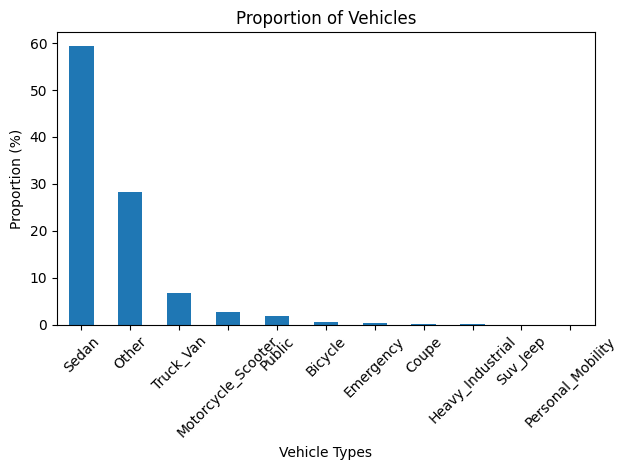

In [ ]:
# Compute proportions
prop = df_vehicles['VEHICLE_CATEGORY'].value_counts(normalize=True).sort_values(ascending=False)

(prop * 100).plot(kind='bar')

plt.title("Proportion of Vehicles")
plt.xlabel("Vehicle Types")
plt.ylabel("Proportion (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


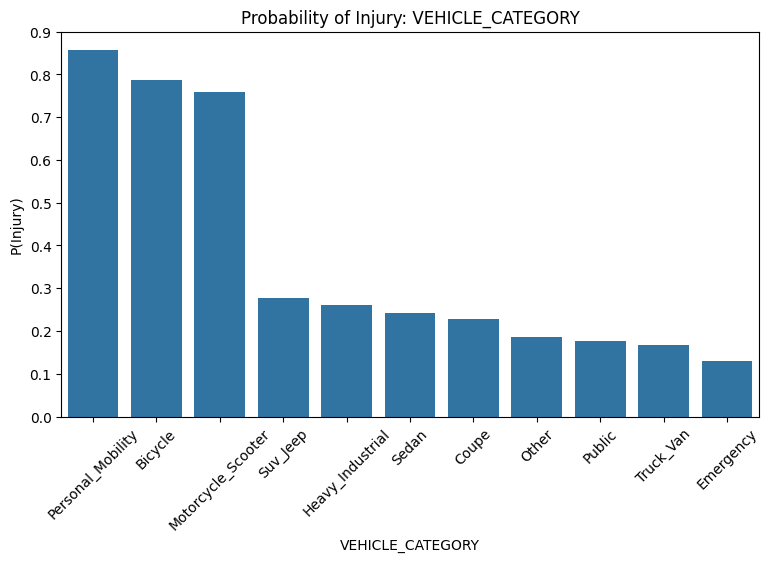

In [ ]:
df_vehicles['is_injured'] = df_vehicles['TOTAL INJURIES'] > 0
injury_prob = df_vehicles[['COLLISION_ID', 'TOTAL INJURIES', 'VEHICLE_CATEGORY', 'is_injured']].drop_duplicates()
injury_prob = injury_prob.groupby('VEHICLE_CATEGORY')['is_injured'].mean().reset_index().sort_values(by='is_injured', ascending=False)
plt.figure(figsize=(9,5))
sns.barplot(data=injury_prob, x='VEHICLE_CATEGORY', y='is_injured')
plt.title('Probability of Injury: VEHICLE_CATEGORY')
plt.ylabel('P(Injury)')
plt.xticks(rotation=45)
plt.show()

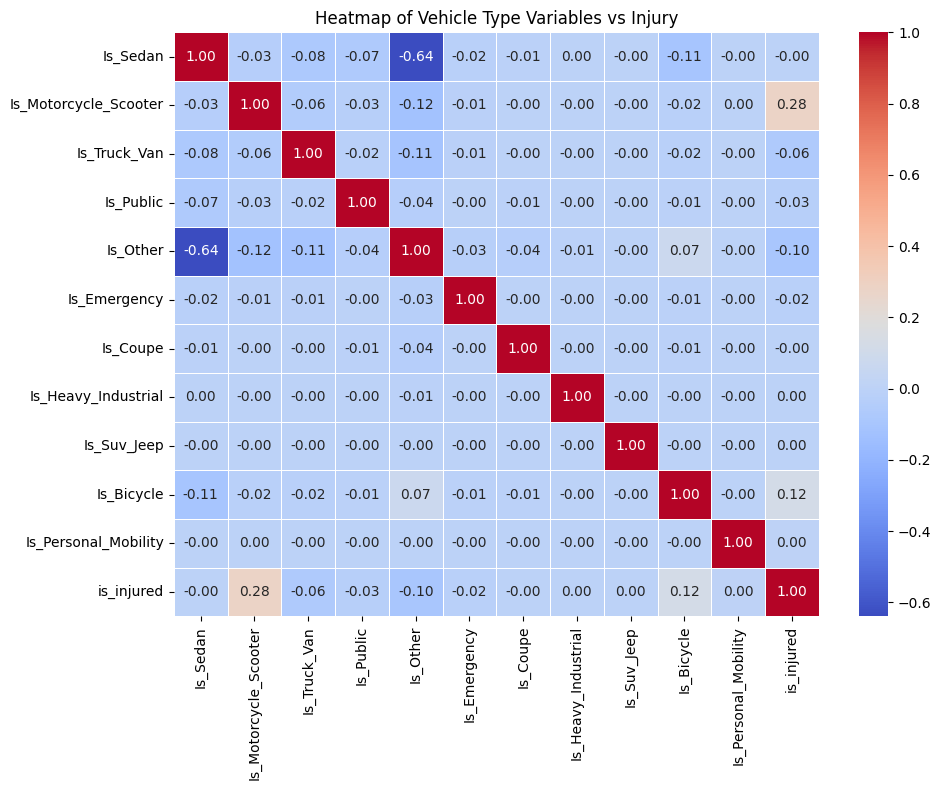

In [ ]:
vehicle_vars = [
    'Is_Sedan', 'Is_Motorcycle_Scooter', 'Is_Truck_Van', 'Is_Public', 'Is_Other',
    'Is_Emergency', 'Is_Coupe', 'Is_Heavy_Industrial', 'Is_Suv_Jeep',
    'Is_Bicycle', 'Is_Personal_Mobility'
]
corr_df = df_full[vehicle_vars + ['is_injured']].corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=.5
)

plt.title("Heatmap of Vehicle Type Variables vs Injury")
plt.tight_layout()
plt.show()

In [ ]:
for cat in vehicle_cat_ls:
  cat_str = str(cat)
  contingency(f'Is_{cat_str}')
  print("_________")

is_injured    False   True 
Is_Sedan                   
False        464914  150586
True        1212958  388462

P(Injury|Is_Sedan = True): 0.2426
P(Injury|Is_Sedan = False): 0.2447

Chi-square: 10.470546683532723
p-value: 0.0012129282005151943
Degrees of freedom: 1
Expected frequencies: [[ 465840.0916587  149659.9083413]
 [1212031.9083413  389388.0916587]]

pvalue <= 0.05: Enough evidence for Is_Sedan
_________
is_injured               False   True 
Is_Motorcycle_Scooter                 
False                  1650558  453540
True                     27314   85508

P(Injury|Is_Motorcycle_Scooter = True): 0.7579
P(Injury|Is_Motorcycle_Scooter = False): 0.2156

Chi-square: 171150.02839804097
p-value: 0.0
Degrees of freedom: 1
Expected frequencies: [[1592482.86787796  511615.13212204]
 [  85389.13212204   27432.86787796]]

pvalue <= 0.05: Enough evidence for Is_Motorcycle_Scooter
_________
is_injured      False   True 
Is_Truck_Van                 
False         1456747  494379
True     

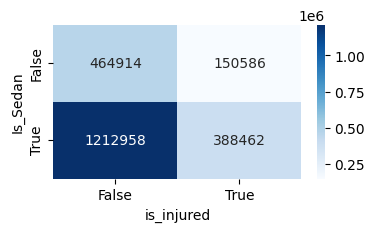

In [ ]:
ct = pd.crosstab(df_full['Is_Sedan'], df_full['is_injured'])

plt.figure(figsize=(4,2))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.show()

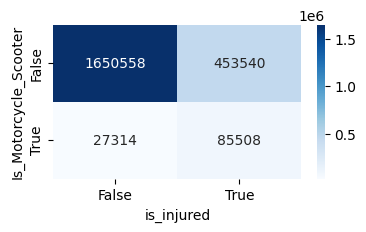

In [ ]:
ct = pd.crosstab(df_full['Is_Motorcycle_Scooter'], df_full['is_injured'])

plt.figure(figsize=(4,2))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.show()

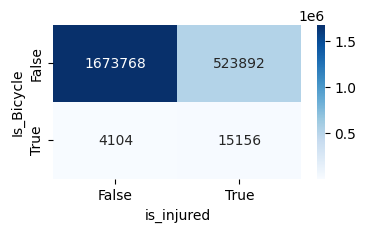

In [ ]:
ct = pd.crosstab(df_full['Is_Bicycle'], df_full['is_injured'])

plt.figure(figsize=(4,2))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.show()

### Crash Details (Involved Vehicles)

In [ ]:
vehicle_cols = [
    'VEHICLE TYPE CODE 1',
    'VEHICLE TYPE CODE 2',
    'VEHICLE TYPE CODE 3',
    'VEHICLE TYPE CODE 4',
    'VEHICLE TYPE CODE 5'
]

df_full['Involved Vehicles'] = df_full[vehicle_cols].notna().sum(axis=1)

In [ ]:
group1 = df_full[df_full['is_injured'] == True]['Involved Vehicles']
group0 = df_full[df_full['is_injured'] == False]['Involved Vehicles']
t_stat, p_value = ttest_ind(group1, group0, equal_var=False)
print(t_stat)
print(p_value)
if p_value < 0.05:
  print("There's difference between 2 groups")
else:
  print("Not enough evidence")

-78.9975656445868
0.0
There's difference between 2 groups


In [ ]:
df_full.groupby(['Involved Vehicles'])['COLLISION_ID'].nunique()/df_full['COLLISION_ID'].nunique()

Involved Vehicles
0    0.007253
1    0.193087
2    0.730113
3    0.053628
4    0.011536
5    0.004382
Name: COLLISION_ID, dtype: float64

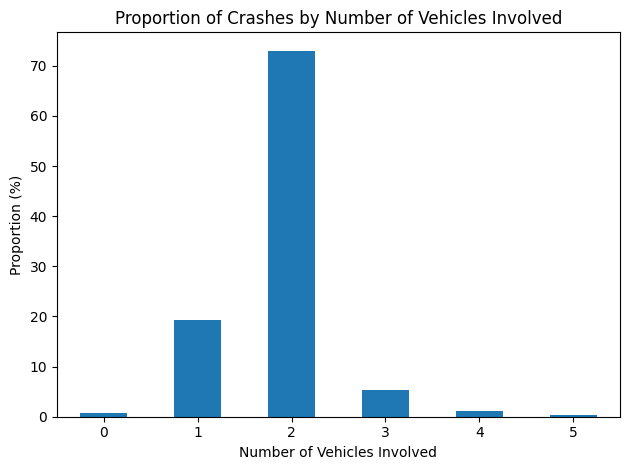

In [ ]:
prop = df_full['Involved Vehicles'].value_counts(normalize=True).sort_index()

(prop * 100).plot(kind='bar')

plt.title("Proportion of Crashes by Number of Vehicles Involved")
plt.xlabel("Number of Vehicles Involved")
plt.ylabel("Proportion (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

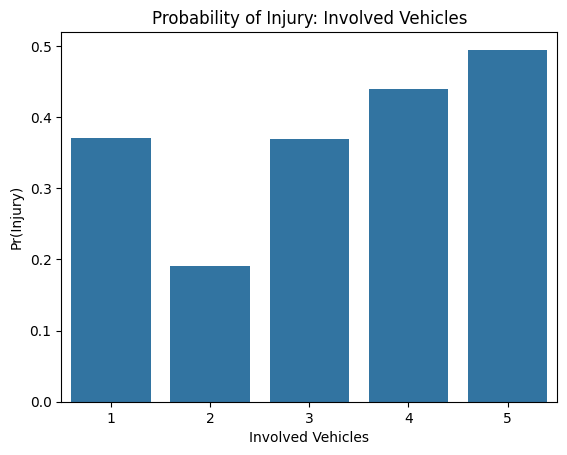

In [ ]:
injury_prob = df_full.groupby('Involved Vehicles')['is_injured'].mean().reset_index()
sns.barplot(data=injury_prob[injury_prob['Involved Vehicles'] > 0], x='Involved Vehicles', y='is_injured')
plt.title('Probability of Injury: Involved Vehicles')
plt.ylabel('Pr(Injury)')
plt.show()

In [ ]:
df_full['Involved_Vehicle_Category'] = (
    df_full['Involved Vehicles']
    .apply(lambda x: '1' if x == 1
                     else ('2' if x == 2
                          else ('1' if x==0 else ('>2')))))

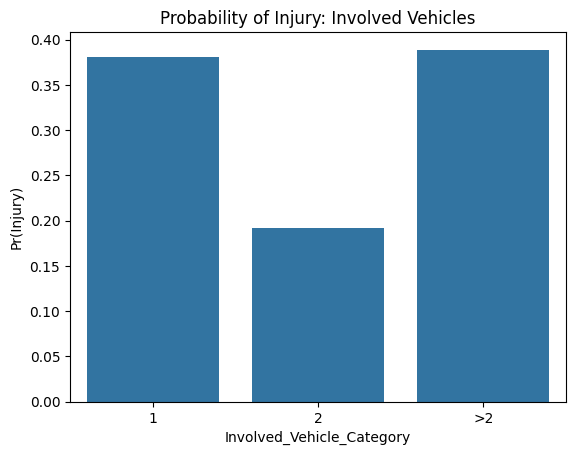

In [ ]:
injury_prob = df_full.groupby('Involved_Vehicle_Category')['is_injured'].mean().reset_index()
sns.barplot(data=injury_prob, x='Involved_Vehicle_Category', y='is_injured')
plt.title('Probability of Injury: Involved Vehicles')
plt.ylabel('Pr(Injury)')
plt.show()

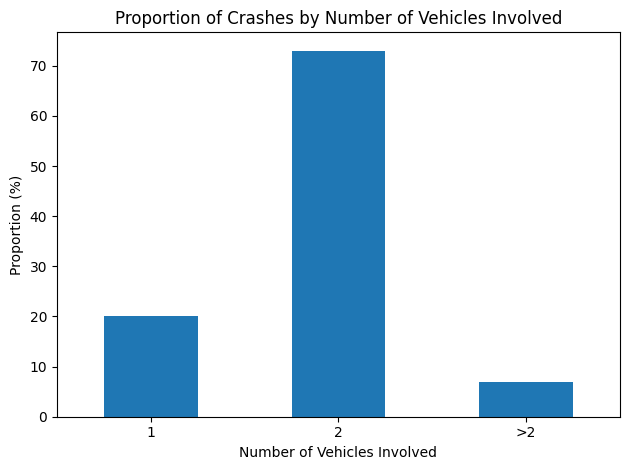

In [ ]:
prop = df_full['Involved_Vehicle_Category'].value_counts(normalize=True).sort_index()

(prop * 100).plot(kind='bar')

plt.title("Proportion of Crashes by Number of Vehicles Involved")
plt.xlabel("Number of Vehicles Involved")
plt.ylabel("Proportion (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
contingency_table = pd.crosstab(df_full['Involved_Vehicle_Category'], df_full['is_injured'])

chi2, p, dof, ex = chi2_contingency(contingency_table)
print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 87539.93866776292
p-value: 0.0


### COVID

In [ ]:
df_full['PRECOVID'] = df_full['CRASH DATE'] < '2020-03-21'

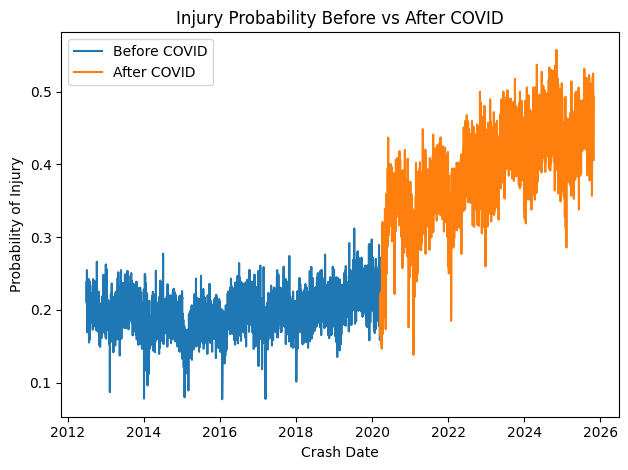

In [ ]:
covid_prob = df_full.groupby(['CRASH DATE', 'PRECOVID'])['is_injured'].mean().reset_index()
pre = covid_prob[covid_prob['PRECOVID'] == 1]
post = covid_prob[covid_prob['PRECOVID'] == 0]
# plot both in one chart
plt.plot(pre['CRASH DATE'], pre['is_injured'], label='Before COVID', linewidth=1.5)
plt.plot(post['CRASH DATE'], post['is_injured'], label='After COVID', linewidth=1.5)

plt.title("Injury Probability Before vs After COVID")
plt.xlabel("Crash Date")
plt.ylabel("Probability of Injury")
plt.legend()
plt.tight_layout()
plt.show()

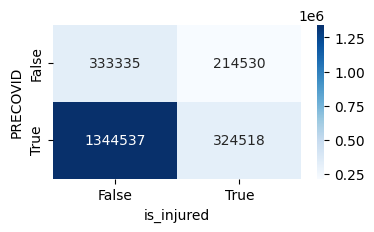

In [ ]:
ct = pd.crosstab(df_full['PRECOVID'], df_full['is_injured'])

plt.figure(figsize=(4,2))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
contingency('PRECOVID')

is_injured    False   True 
PRECOVID                   
False        333335  214530
True        1344537  324518

P(Injury|PRECOVID = True): 0.1944
P(Injury|PRECOVID = False): 0.3916

Chi-square: 87108.92327330103
p-value: 0.0
Degrees of freedom: 1
Expected frequencies: [[ 414650.66095303  133214.33904697]
 [1263221.33904697  405833.66095303]]

pvalue <= 0.05: Enough evidence for PRECOVID


### Interaction Effect

#### **Is there possible interaction between high-risk vehicles?**

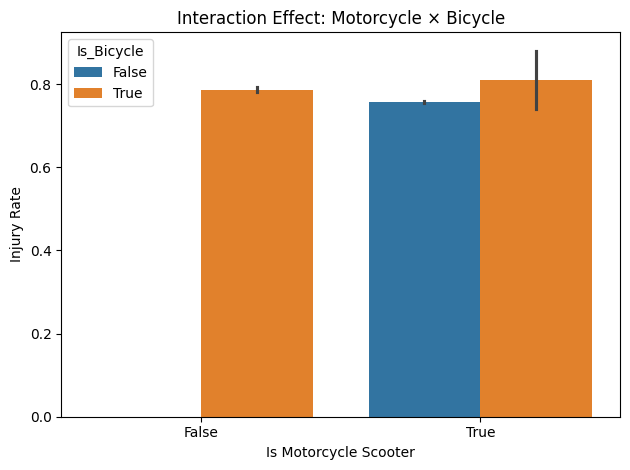

In [ ]:
df_inter = df_full[df_full['Is_Motorcycle_Scooter'] | df_full['Is_Bicycle']]

sns.barplot(
    data=df_inter,
    x="Is_Motorcycle_Scooter",
    y="is_injured",
    hue="Is_Bicycle"
)

plt.title("Interaction Effect: Motorcycle × Bicycle")
plt.xlabel("Is Motorcycle Scooter")
plt.ylabel("Injury Rate")
plt.tight_layout()
plt.show()

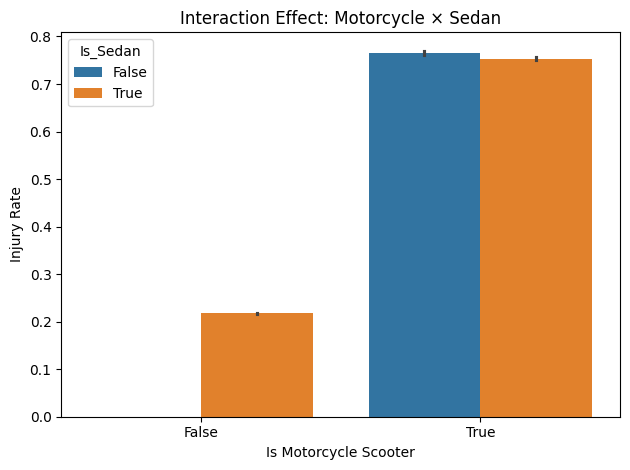

In [ ]:
df_inter = df_full[df_full['Is_Motorcycle_Scooter'] | df_full['Is_Sedan']]

sns.barplot(
    data=df_inter,
    x="Is_Motorcycle_Scooter",
    y="is_injured",
    hue="Is_Sedan"
)

plt.title("Interaction Effect: Motorcycle × Sedan")
plt.xlabel("Is Motorcycle Scooter")
plt.ylabel("Injury Rate")
plt.tight_layout()
plt.show()

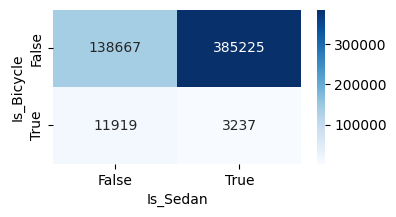

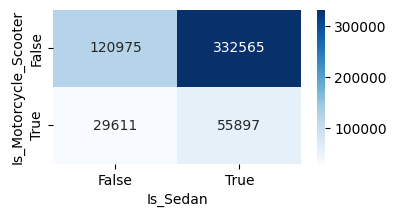

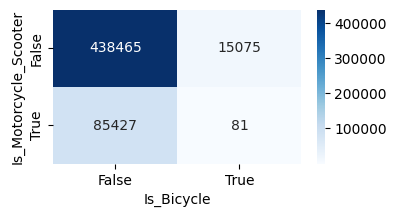

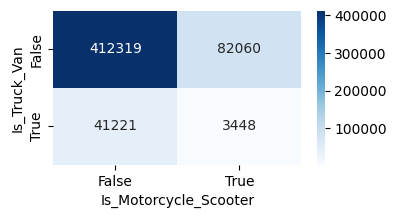

In [ ]:
# Bicycle x Sedan
ct = pd.crosstab(df_full[df_full.is_injured > 0]['Is_Bicycle'], df_full[df_full.is_injured > 0]['Is_Sedan'])
plt.figure(figsize=(4,2))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.show()

# Motorcycle x Sedan
ct = pd.crosstab(df_full[df_full.is_injured > 0]['Is_Motorcycle_Scooter'], df_full[df_full.is_injured > 0]['Is_Sedan'])
plt.figure(figsize=(4,2))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.show()

# Motorcycle x Bicycle
ct = pd.crosstab(df_full[df_full.is_injured > 0]['Is_Motorcycle_Scooter'], df_full[df_full.is_injured > 0]['Is_Bicycle'])
plt.figure(figsize=(4,2))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.show()

# Truck Van & Bicycle
ct = pd.crosstab(df_full[df_full.is_injured > 0]['Is_Truck_Van'], df_full[df_full.is_injured > 0]['Is_Motorcycle_Scooter'])

plt.figure(figsize=(4,2))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# Is any pair of vehicle more likely to cause injury?
veh_per_collision = (
    df_vehicles[['COLLISION_ID', 'VEHICLE_CATEGORY']]
    .drop_duplicates()
    .groupby('COLLISION_ID')['VEHICLE_CATEGORY']
    .apply(list)
    .reset_index()
)
df_pairs = veh_per_collision.merge(df_full[['COLLISION_ID', 'is_injured']],
                                   on='COLLISION_ID', how='left')
from itertools import combinations

rows = []
for _, row in df_pairs.iterrows():
    vehs = row['VEHICLE_CATEGORY']
    injured = row['is_injured']
    # Only meaningful if at least 2 vehicles
    if len(vehs) >= 2:
        for a, b in combinations(sorted(vehs), 2):
            rows.append((a, b, injured))

pairs_df = pd.DataFrame(rows, columns=['VehA', 'VehB', 'is_injured'])
pair_injury_count = (
    pairs_df.groupby(['VehA', 'VehB'])['is_injured']
    .sum()
    .sort_values(ascending=False))
pair_injury_count = pair_injury_count.reset_index()
pair_df = pair_injury_count[~((pair_injury_count['VehA']== 'Other') | (pair_injury_count['VehB']== 'Other'))]
pair_df['colA'] = 'Is_' + pair_df['VehA']
pair_df['colB'] = 'Is_' + pair_df['VehB']
def check_pair(row):
    colA, colB = row['colA'], row['colB']
    # If either column does not exist → cannot be True
    if colA not in df_full.columns or colB not in df_full.columns:
        return False
    return ((df_full[colA] & df_full[colB]).any())
pair_df['Is VehA - VehB'] = pair_df.apply(check_pair, axis=1)


for idx, row in pair_df.iterrows():
    A = row['VehA']
    B = row['VehB']

    colA = f'Is_{A}'
    colB = f'Is_{B}'

    # Name of new pair column
    pair_col = f'Is_{A}&{B}'

    # If either vehicle type doesn't exist in df_full, fill with False
    if colA not in df_full.columns or colB not in df_full.columns:
        df_full[pair_col] = False
        continue

    # True if both vehicle indicators are True in that crash
    df_full[pair_col] = df_full[colA] & df_full[colB]

pairs = [ col for col in df_full.columns if col.startswith("Is_") and col.count("&") == 1]
for cat in pairs:
    cat_str = str(cat)
    contingency(f'{cat_str}')

/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_23761/224349893.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_df['colA'] = 'Is_' + pair_df['VehA']
/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_23761/224349893.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_df['colB'] = 'Is_' + pair_df['VehB']
/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_23761/224349893.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

is_injured                     False   True 
Is_Motorcycle_Scooter&Sedan                 
False                        1659596  483151
True                           18276   55897

P(Injury|Is_Motorcycle_Scooter&Sedan = True): 0.7536
P(Injury|Is_Motorcycle_Scooter&Sedan = False): 0.2255

Chi-square: 108651.54605384797
p-value: 0.0
Degrees of freedom: 1
Expected frequencies: [[1621734.29550187  521012.70449813]
 [  56137.70449813   18035.29550187]]

pvalue <= 0.05: Enough evidence for Is_Motorcycle_Scooter&Sedan
is_injured            False   True 
Is_Sedan&Truck_Van                 
False               1537710  511980
True                 140162   27068

P(Injury|Is_Sedan&Truck_Van = True): 0.1619
P(Injury|Is_Sedan&Truck_Van = False): 0.2498

Chi-square: 6494.4322051050385
p-value: 0.0
Degrees of freedom: 1
Expected frequencies: [[1551304.26884146  498385.73115854]
 [ 126567.73115854   40662.26884146]]

pvalue <= 0.05: Enough evidence for Is_Sedan&Truck_Van
is_injured         False   Tr

In [ ]:
for cat in pairs:
    cat_str = str(cat)
    df_full = df_full.drop(columns={f'{cat_str}'})

#### **Covid and temporal factor**

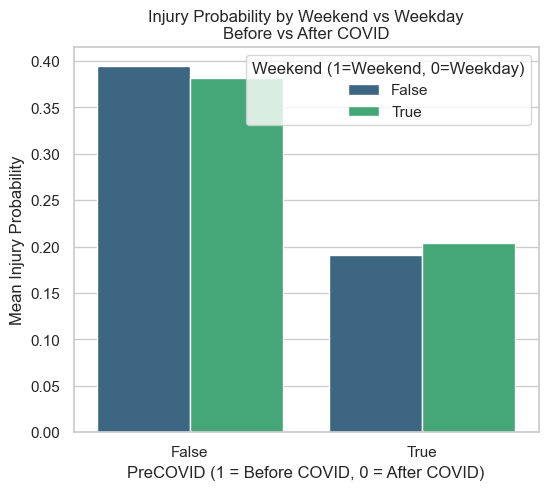

In [ ]:
# group by weekend + precovid
g = df_full.groupby(["IS_WEEKEND", "PRECOVID"])["is_injured"].mean().reset_index()
sns.set(style="whitegrid")
plt.figure(figsize=(6,5))
sns.barplot(
    data=g,
    x="PRECOVID",
    y="is_injured",
    hue="IS_WEEKEND",
    palette="viridis"
)
plt.title("Injury Probability by Weekend vs Weekday\nBefore vs After COVID")
plt.xlabel("PreCOVID (1 = Before COVID, 0 = After COVID)")
plt.ylabel("Mean Injury Probability")
plt.legend(title="Weekend (1=Weekend, 0=Weekday)")
plt.show()

<Axes: xlabel='PRECOVID', ylabel='is_injured'>

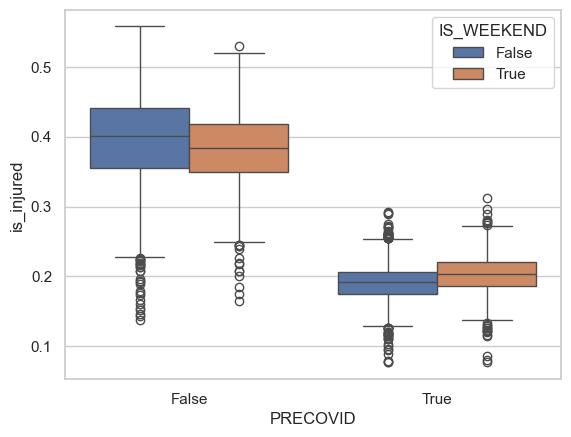

In [ ]:
g = df_full.groupby(["CRASH DATE", "IS_WEEKEND", "PRECOVID"])["is_injured"].mean().reset_index()
sns.boxplot(
    data=g,
    x="PRECOVID",
    y="is_injured",
    hue="IS_WEEKEND",
)


In [ ]:
contingency_table = pd.crosstab(df_full[df_full['PRECOVID'] ==0]['IS_WEEKEND'], df_full[df_full['PRECOVID'] ==0]['is_injured'])

chi2, p, dof, ex = chi2_contingency(contingency_table)
print("Chi-square:", chi2)
print("p-value:", p)
p<0.05

Chi-square: 77.31389043651447
p-value: 1.4583676503920775e-18


np.True_

<Axes: xlabel='Involved_Vehicle_Category', ylabel='is_injured'>

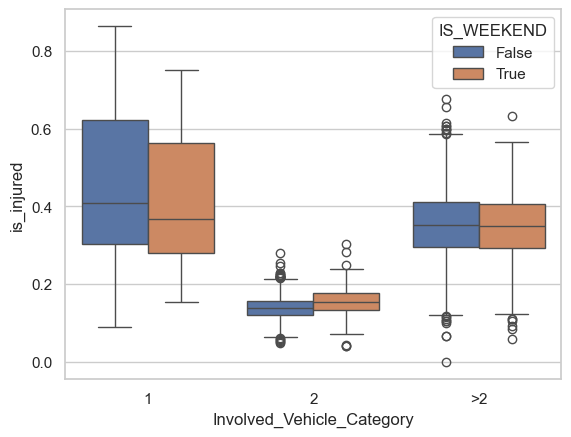

In [ ]:
g = df_full.groupby(["CRASH DATE","Involved_Vehicle_Category", "IS_WEEKEND", "PRECOVID"])["is_injured"].mean().reset_index()
sns.boxplot(
    data=g[g['PRECOVID']==1],
    x="Involved_Vehicle_Category",
    y="is_injured",
    hue="IS_WEEKEND",
)


<Axes: xlabel='Involved_Vehicle_Category', ylabel='is_injured'>

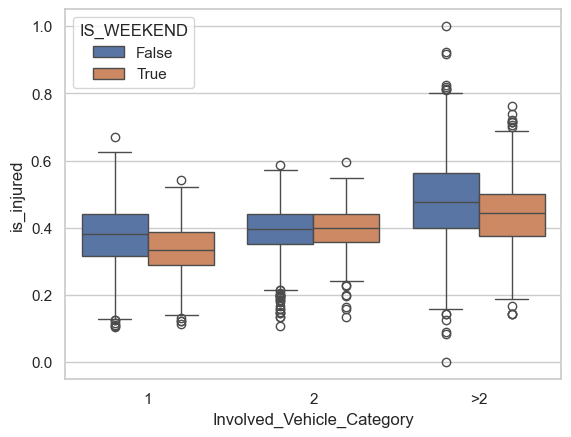

In [ ]:
sns.boxplot(
    data=g[g['PRECOVID']==0],
    x="Involved_Vehicle_Category",
    y="is_injured",
    hue="IS_WEEKEND",
)

# Research Question 1 (Crash Frequency)

### Variable Selection

#### Check feasibility of Poisson distribution by comparing mean and variance

36.546052631578945
7148.94176654508


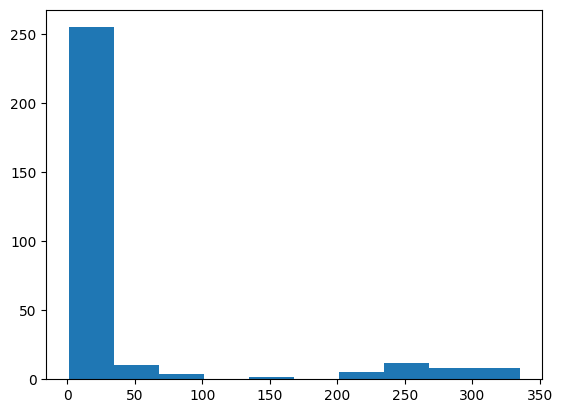

In [115]:
#This is bimodal, likely because of the huge shift between preCOVID and post-COVID
plt.hist(daily_crashes['COLLISION COUNT'])
print(daily_crashes['COLLISION COUNT'].mean())
print(daily_crashes['COLLISION COUNT'].var())

1.0
0.0


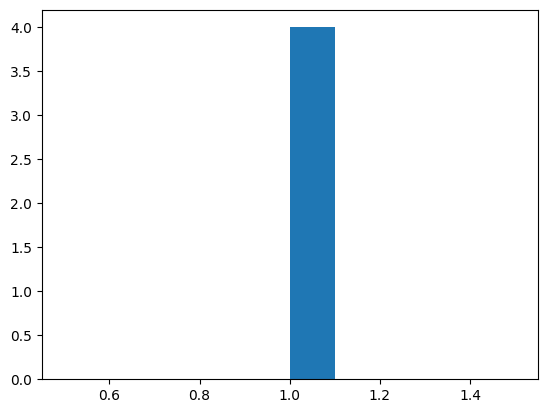

In [116]:
#Check what the histogram looks like for just pre-COVID and post-COVID by themselves
plt.hist(daily_crashes[daily_crashes['PRECOVID']==1]['COLLISION COUNT'])
print(daily_crashes[daily_crashes['PRECOVID']==1]['COLLISION COUNT'].mean())
print(daily_crashes[daily_crashes['PRECOVID']==1]['COLLISION COUNT'].var())

37.02
7227.451103678931


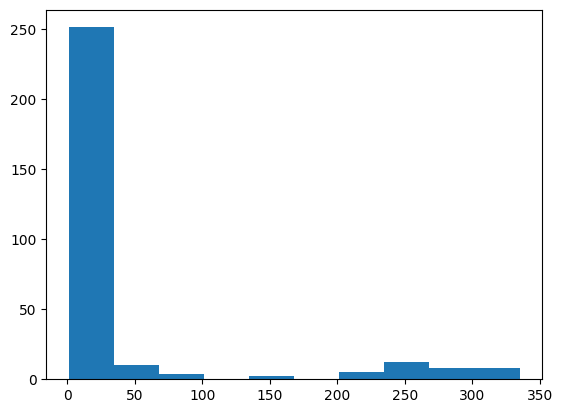

In [117]:
plt.hist(daily_crashes[daily_crashes['PRECOVID']==0]['COLLISION COUNT'])
print(daily_crashes[daily_crashes['PRECOVID']==0]['COLLISION COUNT'].mean())
print(daily_crashes[daily_crashes['PRECOVID']==0]['COLLISION COUNT'].var())

#### Forward Stepwise Variable Selection with Log-Linear Model

Add variables that had the highest correlation with log of daily crash count (among other exogenous variables) and/or categorical variables with interesting observations from EDA graphs.

In [118]:
#PRECOVD has the highest correlation, so start with this
model_fwd_1 = ols(formula = 'LOG_COLLISION_COUNT ~  PRECOVID', data=daily_crashes).fit()
print(model_fwd_1.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.009
Model:                             OLS   Adj. R-squared:                  0.006
Method:                  Least Squares   F-statistic:                     2.879
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):             0.0908
Time:                         00:06:09   Log-Likelihood:                -613.12
No. Observations:                  304   AIC:                             1230.
Df Residuals:                      302   BIC:                             1238.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5580      0.105     14.79

In [119]:
#Day of week showed a definite visual distinction for some days, so add that next
model_fwd_2 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID + DAY_OF_WEEK', data=daily_crashes).fit()
print(model_fwd_2.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.012
Model:                             OLS   Adj. R-squared:                 -0.012
Method:                  Least Squares   F-statistic:                    0.5014
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):              0.833
Time:                         00:06:09   Log-Likelihood:                -612.77
No. Observations:                  304   AIC:                             1242.
Df Residuals:                      296   BIC:                             1271.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4783   

In [120]:
#Visually, we saw Saturdays and Sundays having lower collisions, so let's see whether the IS_WEEKEND variable results in a better model.
model_fwd_3 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID + IS_WEEKEND', data=daily_crashes).fit()
print(model_fwd_3.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.010
Model:                             OLS   Adj. R-squared:                  0.003
Method:                  Least Squares   F-statistic:                     1.524
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):              0.220
Time:                         00:06:09   Log-Likelihood:                -613.03
No. Observations:                  304   AIC:                             1232.
Df Residuals:                      301   BIC:                             1243.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5299      0.125     12.24

In [121]:
#This had a higher AIC and lower R-squared, but does also include fewer variables, so we will consider it.
#Does day of week interact with our COVID indicator?


model_fwd_4 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*DAY_OF_WEEK', data=daily_crashes).fit()
print(model_fwd_4.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.012
Model:                             OLS   Adj. R-squared:                 -0.018
Method:                  Least Squares   F-statistic:                    0.3888
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):              0.940
Time:                         00:06:09   Log-Likelihood:                -612.77
No. Observations:                  304   AIC:                             1246.
Df Residuals:                      294   BIC:                             1283.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [122]:
#Some of the interactions weren't significant at all. Let's try the interaction between the COVID indicator and IS_WEEKEND
model_fwd_5 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND', data=daily_crashes).fit()
print(model_fwd_5.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.010
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     1.013
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):              0.387
Time:                         00:06:09   Log-Likelihood:                -613.03
No. Observations:                  304   AIC:                             1234.
Df Residuals:                      300   BIC:                             1249.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

In [123]:
#This interaction was significant, and the model is simpler, so we will keep these variables going forward.
#Now try adding in TAVG, which had a high correlation with daily crashes when separating out pre- vs post-COVID.
model_fwd_6 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + TAVG', data=daily_crashes).fit()
print(model_fwd_6.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.021
Model:                             OLS   Adj. R-squared:                  0.008
Method:                  Least Squares   F-statistic:                     1.576
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):              0.181
Time:                         00:06:09   Log-Likelihood:                -611.39
No. Observations:                  304   AIC:                             1233.
Df Residuals:                      299   BIC:                             1251.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

In [124]:
#Let's try adding interaction, especially with the correlation increase we saw when splitting by PRECOVID.
model_fwd_7 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + PRECOVID*TAVG', data=daily_crashes).fit()
print(model_fwd_7.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.021
Model:                             OLS   Adj. R-squared:                  0.004
Method:                  Least Squares   F-statistic:                     1.264
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):              0.279
Time:                         00:06:09   Log-Likelihood:                -611.37
No. Observations:                  304   AIC:                             1235.
Df Residuals:                      298   BIC:                             1257.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

In [125]:
#Try using temperature squared, which had slightly higher correlation with log of crashes
model_fwd_8 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + PRECOVID*TAVG_SQ', data=daily_crashes).fit()
print(model_fwd_8.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.015
Model:                             OLS   Adj. R-squared:                 -0.002
Method:                  Least Squares   F-statistic:                    0.9044
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):              0.478
Time:                         00:06:09   Log-Likelihood:                -612.28
No. Observations:                  304   AIC:                             1237.
Df Residuals:                      298   BIC:                             1259.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

In [126]:
#This made the AIC and R-squared (and adjusted R-squared) slightly worse, so use unadjusted TAVG instead
#Now try adding month, which had one of the higher coefficients with log of crash count
model_fwd_9 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + TAVG + MONTH', data=daily_crashes).fit()
print(model_fwd_9.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.261
Model:                             OLS   Adj. R-squared:                  0.223
Method:                  Least Squares   F-statistic:                     6.796
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):           1.40e-12
Time:                         00:06:09   Log-Likelihood:                -568.50
No. Observations:                  304   AIC:                             1169.
Df Residuals:                      288   BIC:                             1228.
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -

In [127]:
#Most months were significant. Does monthly difference interact with the COVID indicator? EDA suggests April especially may be different post-COVID
model_fwd_10 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + TAVG + PRECOVID*MONTH', data=daily_crashes).fit()
print(model_fwd_10.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.264
Model:                             OLS   Adj. R-squared:                  0.221
Method:                  Least Squares   F-statistic:                     6.042
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):           6.13e-12
Time:                         00:06:09   Log-Likelihood:                -567.92
No. Observations:                  304   AIC:                             1172.
Df Residuals:                      286   BIC:                             1239.
Df Model:                           17                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

In [128]:
#Some interactions were significant, but many weren't, and this introduces 12 new variables, so let's leave out interaction.
#Next try adding in IS_FOG, which had one of the higher correlations
model_fwd_11 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + TAVG + IS_FOG + MONTH', data=daily_crashes).fit()
print(model_fwd_11.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.261
Model:                             OLS   Adj. R-squared:                  0.220
Method:                  Least Squares   F-statistic:                     6.350
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):           3.76e-12
Time:                         00:06:09   Log-Likelihood:                -568.50
No. Observations:                  304   AIC:                             1171.
Df Residuals:                      287   BIC:                             1234.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -

In [129]:
#IS_FOG was not significant, try adding IS_HAZE instead, which had a similar correlation with log of crash count
model_fwd_12 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + TAVG + IS_HAZE + MONTH', data=daily_crashes).fit()
print(model_fwd_12.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.261
Model:                             OLS   Adj. R-squared:                  0.220
Method:                  Least Squares   F-statistic:                     6.351
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):           3.73e-12
Time:                         00:06:09   Log-Likelihood:                -568.49
No. Observations:                  304   AIC:                             1171.
Df Residuals:                      287   BIC:                             1234.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -

In [130]:
#IS_HAZE was not significant.
#Average traffic volume was added later in the project development, but the literature review suggests it could be significant.
model_fwd_13 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + TAVG + AVG_TRAFFIC_VOL + MONTH', data=daily_crashes).fit()
print(model_fwd_13.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.285
Model:                             OLS   Adj. R-squared:                  0.245
Method:                  Least Squares   F-statistic:                     7.146
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):           6.61e-14
Time:                         00:06:09   Log-Likelihood:                -563.60
No. Observations:                  304   AIC:                             1161.
Df Residuals:                      287   BIC:                             1224.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -

In [131]:
#Traffic was statistically significant, but didn't improve R-squared much. Will try adding interaction term with the COVID indicator
model_fwd_14 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + TAVG + PRECOVID*AVG_TRAFFIC_VOL + MONTH', data=daily_crashes).fit()
print(model_fwd_14.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.287
Model:                             OLS   Adj. R-squared:                  0.244
Method:                  Least Squares   F-statistic:                     6.766
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):           1.29e-13
Time:                         00:06:09   Log-Likelihood:                -563.19
No. Observations:                  304   AIC:                             1162.
Df Residuals:                      286   BIC:                             1229.
Df Model:                           17                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept     

In [132]:
#The interaction was significant, but the coefficient is very small because the scale is much different
#Try transformation of average traffic vol (square root to rescale; scatter plot lookwed better in EDA)
model_fwd_15 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + TAVG + AVG_TRAFFIC_VOL_SQRT + MONTH', data=daily_crashes).fit()
print(model_fwd_15.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.285
Model:                             OLS   Adj. R-squared:                  0.245
Method:                  Least Squares   F-statistic:                     7.148
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):           6.54e-14
Time:                         00:06:09   Log-Likelihood:                -563.59
No. Observations:                  304   AIC:                             1161.
Df Residuals:                      287   BIC:                             1224.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

In [133]:
#That had worse AIC - try interaction of transformed var
model_fwd_16 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + TAVG + PRECOVID*AVG_TRAFFIC_VOL_SQRT + MONTH', data=daily_crashes).fit()
print(model_fwd_16.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.286
Model:                             OLS   Adj. R-squared:                  0.244
Method:                  Least Squares   F-statistic:                     6.747
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):           1.43e-13
Time:                         00:06:09   Log-Likelihood:                -563.31
No. Observations:                  304   AIC:                             1163.
Df Residuals:                      286   BIC:                             1230.
Df Model:                           17                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Inte

In [134]:
#The AIC improved again after adding interaction. This looks like a good potential model, but let's check VIF.
#Python code to calculate VIF taken from https://www.geeksforgeeks.org/python/detecting-multicollinearity-with-vif-python/

X_vars = daily_crashes[['PRECOVID', 'IS_WEEKEND',  'TAVG', 'AVG_TRAFFIC_VOL_SQRT','MONTH']]


vif_data = pd.DataFrame()
vif_data["feature"] = X_vars.columns

vif_data["VIF"] = [variance_inflation_factor(X_vars.values, i)
                          for i in range(len(X_vars.columns))]
print(vif_data)

                feature       VIF
0              PRECOVID  1.014294
1            IS_WEEKEND  1.385551
2                  TAVG  7.633330
3  AVG_TRAFFIC_VOL_SQRT  4.098695
4                 MONTH  4.112288


In [135]:
#TAVG and MONTH appear to be correlated - drop MONTH for simpler model (and because of the weirdness with post-COVID April )
model_fwd_17 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + TAVG + PRECOVID*AVG_TRAFFIC_VOL_SQRT', data=daily_crashes).fit()
print(model_fwd_17.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.057
Model:                             OLS   Adj. R-squared:                  0.038
Method:                  Least Squares   F-statistic:                     2.984
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):            0.00760
Time:                         00:06:09   Log-Likelihood:                -605.67
No. Observations:                  304   AIC:                             1225.
Df Residuals:                      297   BIC:                             1251.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Inte

In [136]:
#and check the VIF for the new model
X_vars = daily_crashes[['PRECOVID', 'IS_WEEKEND',  'TAVG', 'AVG_TRAFFIC_VOL_SQRT']]


vif_data = pd.DataFrame()
vif_data["feature"] = X_vars.columns

vif_data["VIF"] = [variance_inflation_factor(X_vars.values, i)
                          for i in range(len(X_vars.columns))]
print(vif_data)

                feature       VIF
0              PRECOVID  1.010549
1            IS_WEEKEND  1.380447
2                  TAVG  4.329115
3  AVG_TRAFFIC_VOL_SQRT  4.088541


In [137]:
#Of temperature and traffic, traffic tells a better story, so let's try dropping temperature.
model_fwd_18 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND +  PRECOVID*AVG_TRAFFIC_VOL_SQRT', data=daily_crashes).fit()
print(model_fwd_18.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.049
Model:                             OLS   Adj. R-squared:                  0.033
Method:                  Least Squares   F-statistic:                     3.079
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):             0.0100
Time:                         00:06:09   Log-Likelihood:                -606.91
No. Observations:                  304   AIC:                             1226.
Df Residuals:                      298   BIC:                             1248.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Inte

In [138]:
#Check VIF
X_vars = daily_crashes[['PRECOVID', 'IS_WEEKEND', 'AVG_TRAFFIC_VOL_SQRT']]


vif_data = pd.DataFrame()
vif_data["feature"] = X_vars.columns

vif_data["VIF"] = [variance_inflation_factor(X_vars.values, i)
                          for i in range(len(X_vars.columns))]
print(vif_data)

                feature       VIF
0              PRECOVID  1.009622
1            IS_WEEKEND  1.299353
2  AVG_TRAFFIC_VOL_SQRT  1.308054


#### Backwards Stepwise Variable Selection

In [139]:
#This model has appropriate VIF values, but only two variables.
#Let's see if backwards stepwise variable selection will help us identify any more variables.
#We'll include all other variables in our dataset besides MONTH and temperature-related variables, which were already proven to have too high of correlation with traffic.
model_bckwd_1 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND +  PRECOVID*AVG_TRAFFIC_VOL_SQRT + PRCP + SNOW + SNWD + AWND + IS_FOG + IS_HEAVY_FOG + \
                              IS_THUNDER + IS_SLEET + IS_HAIL + IS_GLAZE + IS_HAZE + IS_DRIFT_SNOW + IS_HIGH_WIND + PRECIP_GT_ONE_TENTH_IN + \
                              BELOW_FREEZING + SNOW_ACCUM_2_IN + IS_HOLIDAY', data=daily_crashes).fit()
print(model_bckwd_1.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.113
Model:                             OLS   Adj. R-squared:                  0.043
Method:                  Least Squares   F-statistic:                     1.625
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):             0.0404
Time:                         00:06:09   Log-Likelihood:                -596.36
No. Observations:                  304   AIC:                             1239.
Df Residuals:                      281   BIC:                             1324.
Df Model:                           22                                         
Covariance Type:             nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
In

In [140]:
#Remove the two variables with highest p-values and try again.
model_bckwd_2 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND +  PRECOVID*AVG_TRAFFIC_VOL_SQRT + PRCP + SNOW + AWND + \
                                IS_FOG + IS_HEAVY_FOG + IS_THUNDER + IS_SLEET + IS_GLAZE + IS_HAZE + IS_DRIFT_SNOW + \
                                IS_HIGH_WIND + PRECIP_GT_ONE_TENTH_IN + BELOW_FREEZING + SNOW_ACCUM_2_IN  + IS_HOLIDAY',
                    data=daily_crashes).fit()
print(model_bckwd_2.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.110
Model:                             OLS   Adj. R-squared:                  0.047
Method:                  Least Squares   F-statistic:                     1.755
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):             0.0253
Time:                         00:06:09   Log-Likelihood:                -596.80
No. Observations:                  304   AIC:                             1236.
Df Residuals:                      283   BIC:                             1314.
Df Model:                           20                                         
Covariance Type:             nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
In

In [141]:
#Remove the two variables with highest p-values and try again.
model_bckwd_3 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND +  PRECOVID*AVG_TRAFFIC_VOL_SQRT + PRCP + SNOW + AWND + \
                                IS_HEAVY_FOG + IS_THUNDER + IS_SLEET + IS_HAZE + IS_DRIFT_SNOW + IS_HIGH_WIND + \
                                PRECIP_GT_ONE_TENTH_IN + BELOW_FREEZING + SNOW_ACCUM_2_IN  + IS_HOLIDAY',
                                data=daily_crashes).fit()
print(model_bckwd_3.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.107
Model:                             OLS   Adj. R-squared:                  0.051
Method:                  Least Squares   F-statistic:                     1.902
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):             0.0157
Time:                         00:06:09   Log-Likelihood:                -597.32
No. Observations:                  304   AIC:                             1233.
Df Residuals:                      285   BIC:                             1303.
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
In

In [142]:
#Remove the two variables with highest p-values and try again.
model_bckwd_4 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND +  PRECOVID*AVG_TRAFFIC_VOL_SQRT + PRCP + AWND + \
                                IS_HEAVY_FOG + IS_THUNDER + IS_SLEET + IS_HAZE + IS_DRIFT_SNOW + IS_HIGH_WIND + \
                               BELOW_FREEZING + SNOW_ACCUM_2_IN  + IS_HOLIDAY', data=daily_crashes).fit()
print(model_bckwd_4.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.097
Model:                             OLS   Adj. R-squared:                  0.047
Method:                  Least Squares   F-statistic:                     1.935
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):             0.0175
Time:                         00:06:10   Log-Likelihood:                -599.00
No. Observations:                  304   AIC:                             1232.
Df Residuals:                      287   BIC:                             1295.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Inte

In [143]:
#Remove the two variables with highest p-values and try again.
model_bckwd_5 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND +  PRECOVID*AVG_TRAFFIC_VOL_SQRT + PRCP + AWND + \
                                IS_HEAVY_FOG + IS_THUNDER + IS_SLEET + IS_HAZE + IS_HIGH_WIND + BELOW_FREEZING + IS_HOLIDAY',
                      data=daily_crashes).fit()
print(model_bckwd_5.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.091
Model:                             OLS   Adj. R-squared:                  0.047
Method:                  Least Squares   F-statistic:                     2.073
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):             0.0133
Time:                         00:06:10   Log-Likelihood:                -600.02
No. Observations:                  304   AIC:                             1230.
Df Residuals:                      289   BIC:                             1286.
Df Model:                           14                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Inte

In [144]:
#Remove the two variables with highest p-values and try again.
model_bckwd_6 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND +  PRECOVID*AVG_TRAFFIC_VOL_SQRT + PRCP + AWND + \
                                IS_HEAVY_FOG + IS_THUNDER + IS_SLEET + BELOW_FREEZING + IS_HOLIDAY',
                     data=daily_crashes).fit()
print(model_bckwd_6.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.088
Model:                             OLS   Adj. R-squared:                  0.050
Method:                  Least Squares   F-statistic:                     2.339
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):            0.00711
Time:                         00:06:10   Log-Likelihood:                -600.57
No. Observations:                  304   AIC:                             1227.
Df Residuals:                      291   BIC:                             1275.
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Inte

In [145]:
#Now that all variables are significant, check VIF
X_vars = daily_crashes[['PRECOVID', 'IS_WEEKEND', 'AVG_TRAFFIC_VOL_SQRT', 'PRCP',  'AWND', 'IS_HEAVY_FOG', 'IS_THUNDER',
                        'IS_SLEET', 'BELOW_FREEZING', 'IS_HOLIDAY']]

vif_data = pd.DataFrame()
vif_data["feature"] = X_vars.columns

vif_data["VIF"] = [variance_inflation_factor(X_vars.values, i)
                          for i in range(len(X_vars.columns))]
print(vif_data)

                feature       VIF
0              PRECOVID  1.030113
1            IS_WEEKEND  1.366324
2  AVG_TRAFFIC_VOL_SQRT  3.766079
3                  PRCP  1.502531
4                  AWND  4.389984
5          IS_HEAVY_FOG  1.229875
6            IS_THUNDER  1.470745
7              IS_SLEET  1.117879
8        BELOW_FREEZING  1.135314
9            IS_HOLIDAY  1.125964


In [146]:
#remove AWND b/c VIF is above 4
model_bckwd_7 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND +  PRECOVID*AVG_TRAFFIC_VOL_SQRT + PRCP + \
                              IS_HEAVY_FOG + IS_THUNDER + IS_SLEET +  BELOW_FREEZING + IS_HOLIDAY', data=daily_crashes).fit()
print(model_bckwd_7.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.083
Model:                             OLS   Adj. R-squared:                  0.048
Method:                  Least Squares   F-statistic:                     2.395
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):            0.00742
Time:                         00:06:10   Log-Likelihood:                -601.44
No. Observations:                  304   AIC:                             1227.
Df Residuals:                      292   BIC:                             1271.
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Inte

In [147]:
#Check VIF
X_vars = daily_crashes[['IS_WEEKEND', 'AVG_TRAFFIC_VOL_SQRT', 'PRCP', 'IS_HEAVY_FOG', 'IS_THUNDER', 'IS_SLEET',
                        'BELOW_FREEZING', 'IS_HOLIDAY']]

vif_data = pd.DataFrame()
vif_data["feature"] = X_vars.columns

vif_data["VIF"] = [variance_inflation_factor(X_vars.values, i)
                          for i in range(len(X_vars.columns))]
print(vif_data)

                feature       VIF
0            IS_WEEKEND  1.319946
1  AVG_TRAFFIC_VOL_SQRT  1.681990
2                  PRCP  1.435531
3          IS_HEAVY_FOG  1.221796
4            IS_THUNDER  1.411268
5              IS_SLEET  1.083533
6        BELOW_FREEZING  1.098613
7            IS_HOLIDAY  1.122077


In [148]:
#VIF values look good for this model.
#Do any of the new variables have interaction with the COVID variable?
model_bckwd_8 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND +  PRECOVID*AVG_TRAFFIC_VOL_SQRT + PRECOVID*PRCP + \
  PRECOVID*IS_HEAVY_FOG + PRECOVID*IS_THUNDER + PRECOVID*IS_SLEET +  PRECOVID*BELOW_FREEZING + PRECOVID*IS_HOLIDAY',
                    data=daily_crashes).fit()
print(model_bckwd_8.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.083
Model:                             OLS   Adj. R-squared:                  0.045
Method:                  Least Squares   F-statistic:                     2.189
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):             0.0123
Time:                         00:06:10   Log-Likelihood:                -601.43
No. Observations:                  304   AIC:                             1229.
Df Residuals:                      291   BIC:                             1277.
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Inte

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [149]:
#No significant interactions between COVID indicator and new weather variables, only IS_HOLIDAY
#What about traffic and weather?
model_bckwd_9 = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + PRECOVID*IS_HOLIDAY +   PRECOVID*AVG_TRAFFIC_VOL_SQRT \
 + AVG_TRAFFIC_VOL_SQRT*PRCP + AVG_TRAFFIC_VOL_SQRT*IS_HEAVY_FOG + AVG_TRAFFIC_VOL_SQRT*IS_THUNDER + \
 AVG_TRAFFIC_VOL_SQRT*IS_SLEET +  AVG_TRAFFIC_VOL_SQRT*BELOW_FREEZING', data=daily_crashes).fit()
print(model_bckwd_9.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.096
Model:                             OLS   Adj. R-squared:                  0.045
Method:                  Least Squares   F-statistic:                     1.899
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):             0.0203
Time:                         00:06:10   Log-Likelihood:                -599.27
No. Observations:                  304   AIC:                             1233.
Df Residuals:                      287   BIC:                             1296.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

None of these were significant either. We'll drop them for our final model

In [150]:

model_bckwd_final = ols(formula = 'LOG_COLLISION_COUNT ~ PRECOVID*IS_WEEKEND + PRECOVID*IS_HOLIDAY + PRECOVID*AVG_TRAFFIC_VOL_SQRT \
                        + PRCP + IS_HEAVY_FOG + IS_THUNDER + IS_SLEET +  BELOW_FREEZING', data=daily_crashes).fit()
print(model_bckwd_final.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.083
Model:                             OLS   Adj. R-squared:                  0.048
Method:                  Least Squares   F-statistic:                     2.395
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):            0.00742
Time:                         00:06:10   Log-Likelihood:                -601.44
No. Observations:                  304   AIC:                             1227.
Df Residuals:                      292   BIC:                             1271.
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Inte

### Model Validation

In [151]:
#Now that we have a final model, let's generate our predictions,
#then de-transform with exponent to return the prediction of number of crashes in its correct units.
daily_crashes['PREDS'] = np.exp(model_bckwd_final.fittedvalues)

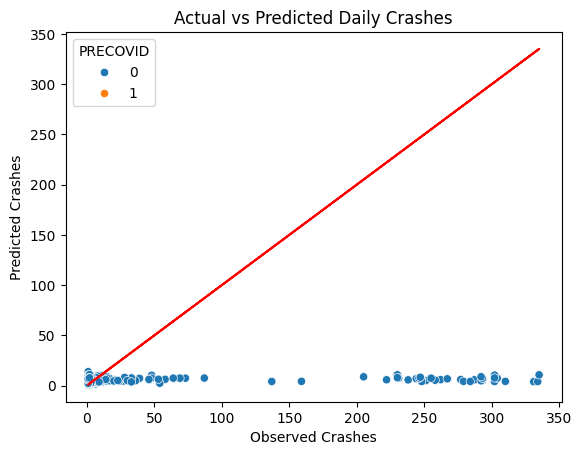

In [152]:
#Test for constant variance by plotting y vs y-hat
#We have horizontal bands across many observed values for each predictive value, which suggests we're missing an influential factor
#that influences number of crashes per day.
sns.scatterplot(x='COLLISION COUNT', y='PREDS', data=daily_crashes, hue='PRECOVID')
plt.xlabel('Observed Crashes')
plt.ylabel('Predicted Crashes')
plt.plot(daily_crashes['COLLISION COUNT'], daily_crashes['COLLISION COUNT'], color = 'r')
plt.title('Actual vs Predicted Daily Crashes')
plt.show()

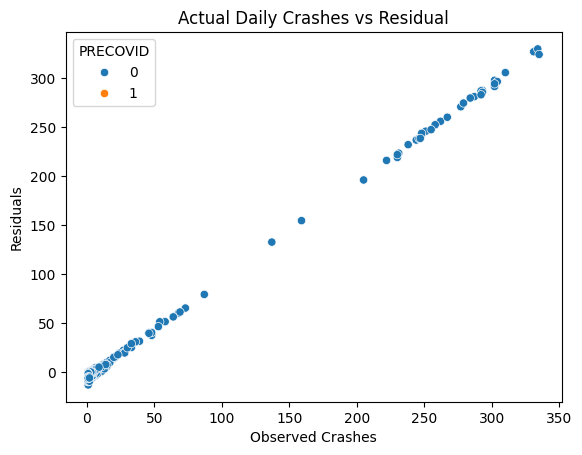

In [153]:
#Another test for constant variance: y-hat vs residuals
#Higher residuals for higher observed crashes - variance is definitely not constant
daily_crashes['RESID'] = daily_crashes['COLLISION COUNT']-daily_crashes['PREDS']
sns.scatterplot(x='COLLISION COUNT', y='RESID', data=daily_crashes, hue='PRECOVID')
plt.xlabel('Observed Crashes')
plt.ylabel('Residuals')
plt.title('Actual Daily Crashes vs Residual')
plt.show()

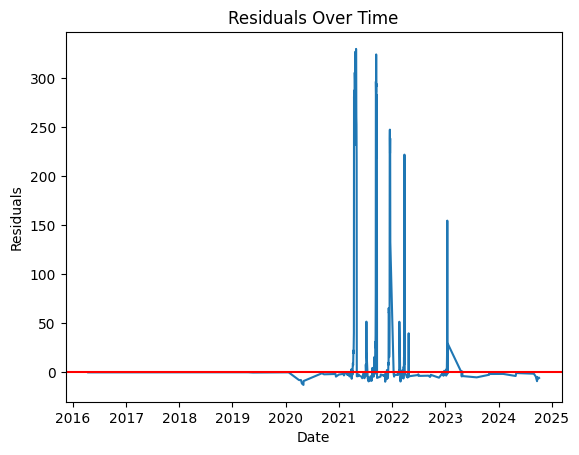

In [154]:
#Check for independence of error by plotting residuals over time
#There seems to be a downward trend in residuals from 2020 to 2025.
plt.plot(daily_crashes.index, daily_crashes['RESID'])
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.show()

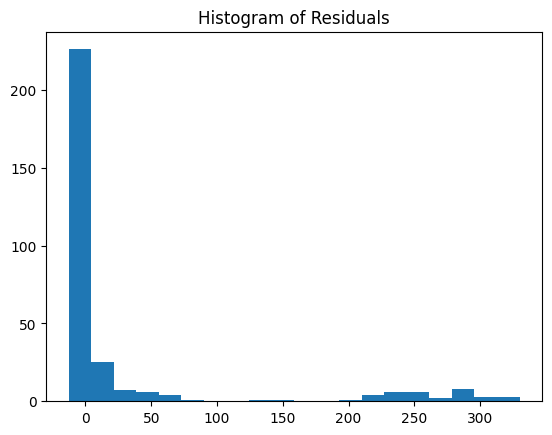

In [155]:
#Check for normality by plotting histogram of residuals
plt.hist(daily_crashes['RESID'], bins=20)
plt.title('Histogram of Residuals')
plt.show()

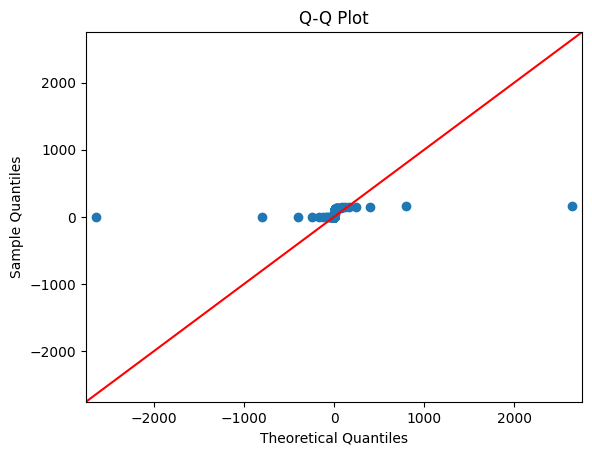

In [156]:
#Q-Q Plot
fig = sm.qqplot(daily_crashes['RESID'], stats.t, distargs=(15,), fit=True, line="45")
plt.title('Q-Q Plot')
plt.show()

In [250]:
#Here's what the model looks like fitting all variables except COVID indicator to the pre-COVID data only.
#R-squared is very small, less than 0.25, which further exemplifies how the COVID indicator is explaining the most variance in our final model.
model_precovid = ols(formula = 'LOG_COLLISION_COUNT ~ IS_WEEKEND + AVG_TRAFFIC_VOL_SQRT + PRCP + IS_HEAVY_FOG + IS_THUNDER +\
 IS_SLEET +  BELOW_FREEZING + IS_HOLIDAY', data=daily_crashes[daily_crashes['PRECOVID']==1]).fit()
print(model_precovid.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.280
Model:                             OLS   Adj. R-squared:                  0.278
Method:                  Least Squares   F-statistic:                     136.8
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):          1.84e-194
Time:                         00:14:56   Log-Likelihood:                 1302.7
No. Observations:                 2820   AIC:                            -2587.
Df Residuals:                     2811   BIC:                            -2534.
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

In [251]:
#A similar result with post-COVID data, but even smaller R-squared, less than 0.1.
#Maybe whatever is causing the downward residual trend post-2020 is causing the gap in R-squared from the pre-COVID model.
model_postcovid = ols(formula = 'LOG_COLLISION_COUNT ~ IS_WEEKEND + AVG_TRAFFIC_VOL_SQRT + PRCP + IS_HEAVY_FOG + IS_THUNDER + IS_SLEET +  BELOW_FREEZING + IS_HOLIDAY', data=daily_crashes[daily_crashes['PRECOVID']==0]).fit()
print(model_postcovid.summary())

                             OLS Regression Results                            
Dep. Variable:     LOG_COLLISION_COUNT   R-squared:                       0.097
Model:                             OLS   Adj. R-squared:                  0.094
Method:                  Least Squares   F-statistic:                     27.46
Date:                 Wed, 10 Dec 2025   Prob (F-statistic):           8.39e-41
Time:                         00:14:57   Log-Likelihood:                 626.93
No. Observations:                 2046   AIC:                            -1236.
Df Residuals:                     2037   BIC:                            -1185.
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

# Research Question 2 (Crash Severity)

In [ ]:
df = pd.read_csv("RQ2_fitting_dataset.csv")
df = df.drop(columns={'Unnamed: 0', 'BOROUGH', 'ON STREET NAME',
                      'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                      'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
                      'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
                      'CONTRIBUTING FACTOR VEHICLE 5', 'TMAX', 'TMIN', 'IS_FOG',
                      'IS_HEAVY_FOG', 'IS_THUNDER', 'IS_SLEET', 'IS_HAIL', 'IS_GLAZE',
                      'IS_HAZE', 'IS_DRIFT_SNOW', 'IS_HIGH_WIND', 'TOTAL INJURIES'})
df = df.drop(columns={'Is_Motorcycle_Scooter_Sedan', 'Is_Sedan_Truck_Van', 'Is_Public_Sedan',
       'Is_Motorcycle_Scooter_Truck_Van', 'Is_Bicycle_Sedan',
       'Is_Emergency_Sedan', 'Is_Coupe_Sedan', 'Is_Motorcycle_Scooter_Public',
       'Is_Public_Truck_Van', 'Is_Bicycle_Truck_Van', 'Is_Bicycle_Public',
       'Is_Coupe_Motorcycle_Scooter', 'Is_Coupe_Truck_Van',
       'Is_Emergency_Motorcycle_Scooter', 'Is_Bicycle_Motorcycle_Scooter',
       'Is_Emergency_Truck_Van', 'Is_Heavy_Industrial_Sedan',
       'Is_Coupe_Public', 'Is_Emergency_Public', 'Is_Bicycle_Emergency',
       'Is_Heavy_Industrial_Motorcycle_Scooter', 'Is_Personal_Mobility_Sedan',
       'Is_Sedan_Suv_Jeep', 'Is_Heavy_Industrial_Truck_Van',
       'Is_Coupe_Emergency', 'Is_Heavy_Industrial_Public',
       'Is_Motorcycle_Scooter_Personal_Mobility',
       'Is_Emergency_Heavy_Industrial', 'Is_Suv_Jeep_Truck_Van',
       'Is_Motorcycle_Scooter_Suv_Jeep', 'Is_Coupe_Heavy_Industrial',
       'Is_Public_Suv_Jeep'})
df['is_injured'] = df['is_injured'].astype(int)
# Transform Involved Vehicle to category
df['Involved_Vehicle_Category'] = (
    df['Involved Vehicles']
    .apply(lambda x: '1' if x == 1
                     else ('2' if x == 2
                          else ('>2'))))
df[['DAY OF WEEK', 'CRASH_MONTH', "Involved_Vehicle_Category"]] = df[['DAY OF WEEK', 'CRASH_MONTH', "Involved_Vehicle_Category"]].astype("category")

In [ ]:
df = df.drop(columns = {'Involved Vehicles'})

## Train/Test Split

In [ ]:
df_sorted = df.sort_values(by="CRASH DATE")
split_idx = int(0.8 * len(df_sorted))
train_df = df_sorted.iloc[:split_idx].copy()
test_df  = df_sorted.iloc[split_idx:].copy()
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [ ]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df = train_df.dropna()
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df = test_df.dropna()

In [ ]:
train_df = train_df.drop(columns={'CRASH_YEAR', 'IS_HUMAN', "CRASH DATE", "CRASH TIME", "COLLISION_ID"})
test_df = test_df.drop(columns={'CRASH_YEAR', 'IS_HUMAN', "CRASH DATE", "CRASH TIME", "COLLISION_ID"})

## Multicollinearity check on train set

In [ ]:
dummies = pd.get_dummies(train_df['BEFORE_COVID'],
                       prefix='BEF_C_',
                        drop_first=False)
train_df = pd.concat([train_df, dummies], axis=1)

In [ ]:
# VIF CHECK WITH THE FINAL VARIABLES USED IN THE MODEL
bool_cols = train_df.select_dtypes(include=["bool"]).columns
train_df[bool_cols] = train_df[bool_cols].astype(int)
# Drop non-numeric columns explicitly
drop_cols = ["CRASH_YEAR", "CRASH DATE", "CRASH TIME", "COLLISION_ID", "is_injured", "IS_HUMAN", "BEF_C__True", "AWND", "SNWD", "TAVG"]
X = train_df.drop(columns=drop_cols, errors="ignore")
# Keep only numeric columns
X = X.select_dtypes(include=["int64", "float64"])
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)
vif_df = pd.DataFrame()
vif_df["variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])]
vif_df.sort_values("VIF", ascending=False)

variable        VIF
10           BEFORE_COVID  16.151364
2           PRECIP_GT_0.1   2.345311
0                    PRCP   2.066283
15               Is_Other   2.033615
27           BEF_C__False   1.916517
11               Is_Sedan   1.914961
4         SNOW_ACCUM_2_IN   1.397986
5            VISION_BLOCK   1.393961
1                    SNOW   1.294450
22        Driver_Behavior   1.250087
3          BELOW_FREEZING   1.245078
23     Driver_Distraction   1.184495
13           Is_Truck_Van   1.080501
24      Driver_Impairment   1.076940
7      AVG TRAFFIC VOLUME   1.073118
8               BUSY HOUR   1.052161
12  Is_Motorcycle_Scooter   1.044467
25    Environment_Roadway   1.040475
14              Is_Public   1.026196
6              IS_WEEKEND   1.017883
20             Is_Bicycle   1.014903
26         Vehicle_Defect   1.013890
16           Is_Emergency   1.005230
9              IS_HOLIDAY   1.003860
17               Is_Coupe   1.003720
18    Is_Heavy_Industrial   1.000294
19            Is_Suv_Jeep   1.000027
21   Is_Personal_Mobility   1.000020

## Variable Selection for Main Effect

In [ ]:
# model performance metrics
results_table = pd.DataFrame(columns=[
    "Model",
    "Pseudo_R2",
    "LogLikelihood",
    "AIC",
    "BIC"])
def add_model_results(model, model_name):
    global results_table
    pseudo_r2 = model.prsquared if hasattr(model, "prsquared") else None
    aic = model.aic
    bic = model.bic
    llf = model.llf
    new_row = {
        "Model": model_name,
        "Pseudo_R2": pseudo_r2,
        "AIC": aic,
        "BIC": bic,
        "LogLikelihood": llf}
    results_table = pd.concat([results_table, pd.DataFrame([new_row])],ignore_index=True)
def add_model(model):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    name = [var_name for var_name, var_val in callers_local_vars if var_val is model]
    model_name = name[0]
    add_model_results(model, model_name)
    print(model.summary())
    results_table

# Prediction evaluation on test_df
def evaluation(model_name):
    test_df['pred_prob'] = model_name.predict(test_df)
    test_df['pred_injury'] = (test_df['pred_prob'] >= 0.5).astype(int)
    y_true = test_df['is_injured']
    y_pred = test_df['pred_injury']
    y_prob = test_df['pred_prob']

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)

    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def lr_test(model_name1, model_name2):
    ll0 = model_name1.llf # Reduced Model
    ll1 = model_name2.llf # Full Model
    # number of parameters
    k0 = model_name1.df_model + 1
    k1 = model_name2.df_model + 1
    # LR statistic
    LR = -2 * (ll0 - ll1)
    # degrees of freedom
    df = k1 - k0
    # p-value
    p_value = chi2.sf(LR, df)
    print(f"LR: {LR}, DF: {df}, p_value: {p_value}")
    if p_value <= 0.05:
        print("p_value <= 0.05")
    else:
        print("p_value > 0.05")

In [ ]:
# Try Weather Group first
model1 = smf.logit(
    formula='is_injured ~ SNOW_ACCUM_2_IN + BELOW_FREEZING + VISION_BLOCK',
    data=train_df
).fit()
add_model(model1)
results_table

Optimization terminated successfully.
         Current function value: 0.503645
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626450
Method:                           MLE   Df Model:                            3
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:               0.0008649
Time:                        18:19:52   Log-Likelihood:            -8.1916e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                3.403e-307
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.3492      0.003   -427.739      0.000      -1.355   

/var/folders/zh/znnjbxzs5hqbkljnm3f8zf9w0000gn/T/ipykernel_24087/444904279.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_table = pd.concat([results_table, pd.DataFrame([new_row])],ignore_index=True)


Model  Pseudo_R2  LogLikelihood           AIC           BIC
0  model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06

Confusion matrix:
 [[254780      0]
 [173643      0]]
Accuracy: 0.595, Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.503


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


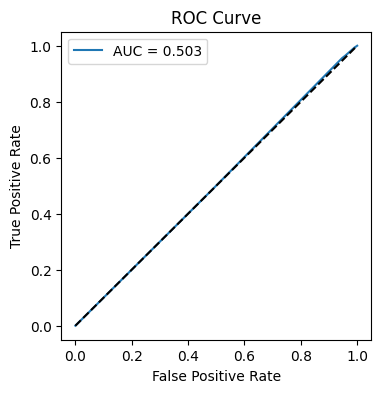

In [ ]:
evaluation(model1)

Optimization terminated successfully.
         Current function value: 0.503441
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626437
Method:                           MLE   Df Model:                           16
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                0.001270
Time:                        18:19:56   Log-Likelihood:            -8.1882e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.3856      0.008   -163.818      0.000      -1.402   

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


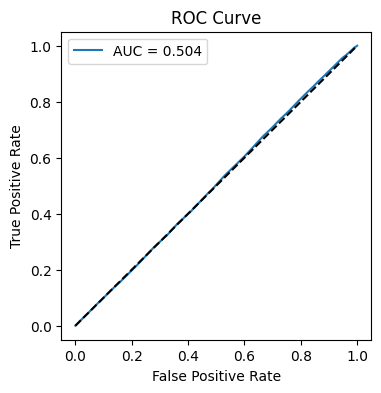

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0  model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1  model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06

In [ ]:
## Add temporal factor variable group
model2 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND + CRASH_MONTH + IS_HOLIDAY',
    data=train_df
).fit()
add_model(model2)
evaluation(model2)
results_table

In [ ]:
lr_test(model1, model2)

LR: 665.0390208300669, DF: 13.0, p_value: 1.0153307623635835e-133
p_value <= 0.05


Optimization terminated successfully.
         Current function value: 0.500442
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626434
Method:                           MLE   Df Model:                           19
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                0.007219
Time:                        18:20:01   Log-Likelihood:            -8.1395e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.6959      0.011    -64.256      0.000      -0.717   

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


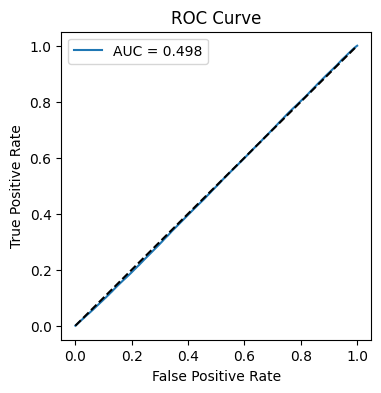

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0  model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1  model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2  model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06

In [ ]:
## Add traffic-indicating variable group
model3 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND + BEFORE_COVID + CRASH_MONTH + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME") + Q("BUSY HOUR")',
    data=train_df
).fit()
add_model(model3)
evaluation(model3)
results_table

In [ ]:
lr_test(model3, model2)

LR: -9754.0344278072, DF: -3.0, p_value: nan
p_value > 0.05


Optimization terminated successfully.
         Current function value: 0.479269
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626432
Method:                           MLE   Df Model:                           21
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                 0.04922
Time:                        18:20:04   Log-Likelihood:            -7.7951e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.2008      0.011    -17.560  

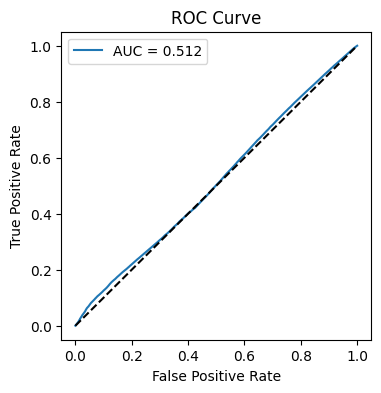

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0  model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1  model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2  model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3  model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06

In [ ]:
## Add crash detail variable group
model4 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND + BEFORE_COVID + CRASH_MONTH + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME") + Q("BUSY HOUR")\
    + Involved_Vehicle_Category',
    data=train_df
).fit()
add_model(model4)
evaluation(model4)
results_table

In [ ]:
lr_test(model2, model4)

LR: 78628.19647683972, DF: 5.0, p_value: 0.0
p_value <= 0.05


Optimization terminated successfully.
         Current function value: 0.479268
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626431
Method:                           MLE   Df Model:                           22
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                 0.04922
Time:                        18:20:06   Log-Likelihood:            -7.7951e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.2000      0.011    -17.479  

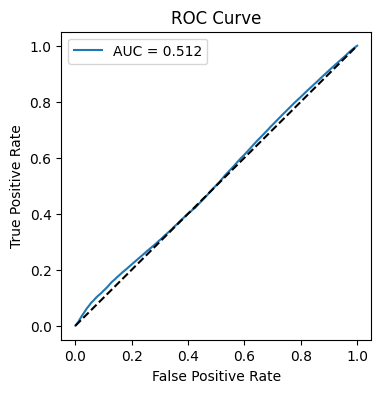

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0  model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1  model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2  model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3  model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4  model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06

In [ ]:
## Add environment_roadway variable
model5 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND + BEFORE_COVID + CRASH_MONTH + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME") + Q("BUSY HOUR")\
    + Involved_Vehicle_Category\
    + Environment_Roadway',
    data=train_df
).fit()
add_model(model5)
evaluation(model5)
results_table

In [ ]:
lr_test(model4, model5)

LR: 3.884551275288686, DF: 1.0, p_value: 0.04873228329967603
p_value <= 0.05


Optimization terminated successfully.
         Current function value: 0.447664
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626423
Method:                           MLE   Df Model:                           30
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1119
Time:                        18:20:09   Log-Likelihood:            -7.2810e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.2355      0.013    -17.842 

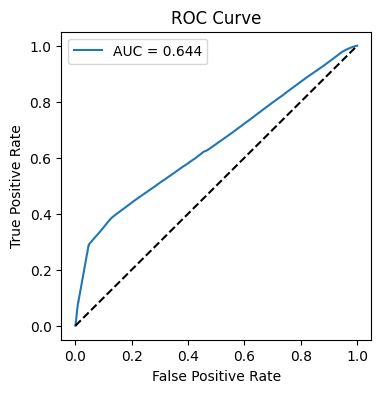

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0  model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1  model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2  model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3  model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4  model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5  model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06

In [ ]:
## Add vehicle type variable
model6 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND + BEFORE_COVID + CRASH_MONTH + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME") + Q("BUSY HOUR")\
    + Involved_Vehicle_Category\
    + Environment_Roadway\
    + Is_Sedan + Is_Motorcycle_Scooter + Is_Public + Is_Other + Is_Emergency + Is_Coupe + Is_Bicycle + Is_Personal_Mobility',
    data=train_df
).fit()
add_model(model6)
evaluation(model6)
results_table

In [ ]:
lr_test(model5, model6)

LR: 102805.97481309157, DF: 8.0, p_value: 0.0
p_value <= 0.05


Optimization terminated successfully.
         Current function value: 0.445990
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626420
Method:                           MLE   Df Model:                           33
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1152
Time:                        18:20:13   Log-Likelihood:            -7.2538e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.3849      0.013    -28.706 

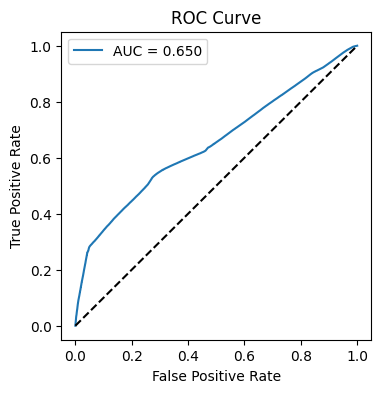

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0  model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1  model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2  model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3  model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4  model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5  model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6  model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06

In [ ]:
## Add human factor variable
model7 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND + BEFORE_COVID + CRASH_MONTH + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME") + Q("BUSY HOUR")\
    + Involved_Vehicle_Category\
    + Environment_Roadway\
    + Is_Sedan + Is_Motorcycle_Scooter + Is_Public + Is_Other + Is_Emergency + Is_Coupe + Is_Bicycle + Is_Personal_Mobility\
    + Driver_Behavior + Environment_Roadway + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model7)
evaluation(model7)
results_table

In [ ]:
lr_test(model6, model7)

LR: 5444.988985111238, DF: 3.0, p_value: 0.0
p_value <= 0.05


## Main Effect Backward

Optimization terminated successfully.
         Current function value: 0.445992
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626421
Method:                           MLE   Df Model:                           32
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1152
Time:                        18:20:36   Log-Likelihood:            -7.2539e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.3870      0.013    -28.913 

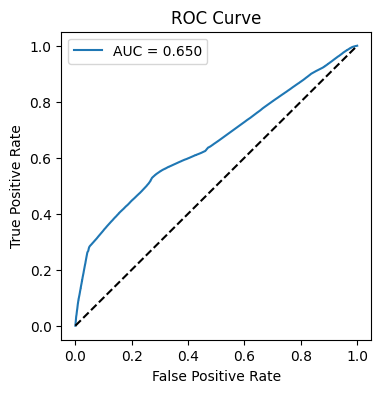

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0  model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1  model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2  model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3  model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4  model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5  model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6  model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7  model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06

In [ ]:
## Eliminate Busy Hour as lr_test(model2, model3) < 0.05
model8 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND + BEFORE_COVID + CRASH_MONTH + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME")\
    + Involved_Vehicle_Category\
    + Environment_Roadway\
    + Is_Sedan + Is_Motorcycle_Scooter + Is_Public + Is_Other + Is_Emergency + Is_Coupe + Is_Bicycle + Is_Personal_Mobility\
    + Driver_Behavior + Environment_Roadway + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model8)
evaluation(model8)
results_table

In [ ]:
lr_test(model8, model7)

LR: 8.21504787565209, DF: 1.0, p_value: 0.00415444190321819
p_value <= 0.05


Optimization terminated successfully.
         Current function value: 0.445993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626422
Method:                           MLE   Df Model:                           31
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1152
Time:                        18:20:49   Log-Likelihood:            -7.2539e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.3870      0.013    -28.909  

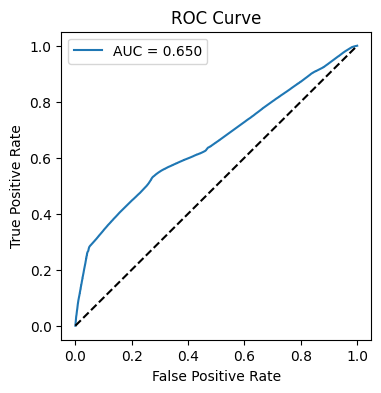

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0  model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1  model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2  model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3  model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4  model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5  model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6  model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7  model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8  model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06

In [ ]:
## Eliminate Is_Personal_Mobility
model9 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND + BEFORE_COVID + CRASH_MONTH + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME")\
    + Involved_Vehicle_Category\
    + Environment_Roadway\
    + Is_Sedan + Is_Motorcycle_Scooter + Is_Public + Is_Other + Is_Emergency + Is_Coupe + Is_Bicycle\
    + Driver_Behavior + Environment_Roadway + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model9)
evaluation(model9)
results_table

In [ ]:
lr_test(model9, model8)

LR: 1.8154503509867936, DF: 1.0, p_value: 0.17785578971938779
p_value > 0.05


==> do not remove variable

## Adding some possible variables and interaction effect

Optimization terminated successfully.
         Current function value: 0.445989
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626420
Method:                           MLE   Df Model:                           33
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1152
Time:                        18:20:53   Log-Likelihood:            -7.2538e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -0.372

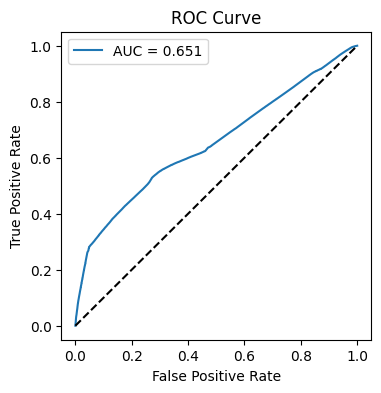

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0   model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1   model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2   model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3   model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4   model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5   model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6   model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7   model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8   model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9  model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06

In [ ]:
## IS_WEEKEND * BEFORE_COVID
model10 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND * BEFORE_COVID + CRASH_MONTH + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME")\
    + Involved_Vehicle_Category\
    + Environment_Roadway\
    + Is_Sedan + Is_Motorcycle_Scooter + Is_Public + Is_Other + Is_Emergency + Is_Coupe + Is_Bicycle + Is_Personal_Mobility\
    + Driver_Behavior + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model10)
evaluation(model10)
results_table

In [ ]:
lr_test(model9, model10)

LR: 12.77044961345382, DF: 2.0, p_value: 0.0016862893637995373
p_value <= 0.05


Optimization terminated successfully.
         Current function value: 0.445965
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626419
Method:                           MLE   Df Model:                           34
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1153
Time:                        18:20:58   Log-Likelihood:            -7.2534e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                              

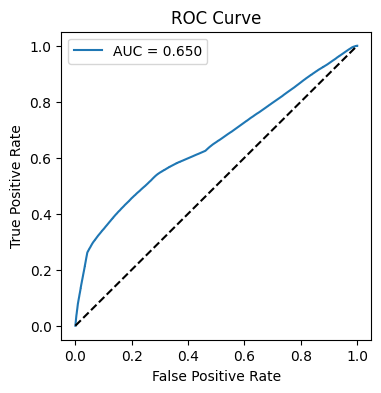

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06

In [ ]:
## Traffic Volume * BEFORE_COVID
model11 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND * BEFORE_COVID + CRASH_MONTH + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME") * BEFORE_COVID\
    + Involved_Vehicle_Category\
    + Environment_Roadway\
    + Is_Sedan + Is_Motorcycle_Scooter + Is_Public + Is_Other + Is_Emergency + Is_Coupe + Is_Bicycle + Is_Personal_Mobility\
    + Driver_Behavior + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model11)
evaluation(model11)
results_table

In [ ]:
lr_test(model10, model11)

LR: 79.02489017718472, DF: 1.0, p_value: 6.133232982373063e-19
p_value <= 0.05


However, AUC drops => do not keep the term

Optimization terminated successfully.
         Current function value: 0.445960
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626409
Method:                           MLE   Df Model:                           44
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1153
Time:                        18:21:02   Log-Likelihood:            -7.2533e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -0.416

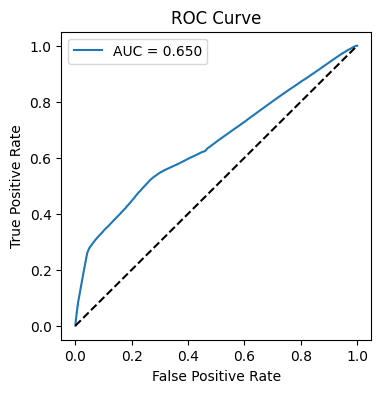

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06
11  model12   0.115301 -725334.009002  1.450758e+06  1.451312e+06

In [ ]:
## Crash Month * BEFORE_COVID
model12 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND * BEFORE_COVID + CRASH_MONTH * BEFORE_COVID + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME") \
    + Involved_Vehicle_Category\
    + Environment_Roadway\
    + Is_Sedan + Is_Motorcycle_Scooter + Is_Public + Is_Other + Is_Emergency + Is_Coupe + Is_Bicycle + Is_Personal_Mobility\
    + Driver_Behavior + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model12)
evaluation(model12)
results_table

AUC drops => do not keep the term

Optimization terminated successfully.
         Current function value: 0.445922
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626416
Method:                           MLE   Df Model:                           37
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1154
Time:                        18:21:07   Log-Likelihood:            -7.2527e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept    

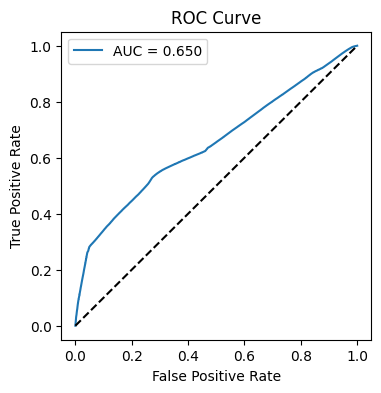

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06
11  model12   0.115301 -725334.009002  1.450758e+06  1.451312e+06
12  model13   0.115376 -725272.052015  1.450620e+06  1.451088e+06

In [ ]:
# EDA shows possible interaction between Motorcycle_Scooter with the human factors
model13 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN\
    + VISION_BLOCK\
    + IS_WEEKEND\
    + BEFORE_COVID\
    + CRASH_MONTH\
    + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME")\
    + Involved_Vehicle_Category\
    + Q("BUSY HOUR")\
    + Is_Sedan\
    + Is_Motorcycle_Scooter * Driver_Distraction + Is_Motorcycle_Scooter * Driver_Behavior + Is_Motorcycle_Scooter * Driver_Impairment + Is_Motorcycle_Scooter * Environment_Roadway\
    + Is_Public + Is_Other + Is_Emergency + Is_Coupe + Is_Bicycle + Is_Personal_Mobility\
    + Driver_Behavior + Environment_Roadway + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model13)
evaluation(model13)
results_table

Optimization terminated successfully.
         Current function value: 0.445890
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626412
Method:                           MLE   Df Model:                           41
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1154
Time:                        18:21:11   Log-Likelihood:            -7.2522e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept    

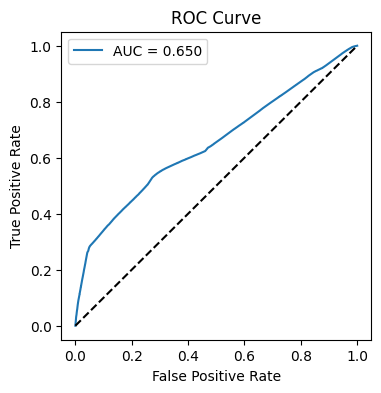

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06
11  model12   0.115301 -725334.009002  1.450758e+06  1.451312e+06
12  model13   0.115376 -725272.052015  1.450620e+06  1.451088e+06
13  model14   0.115440 -725219.792505  1.450524e+06  1.451040e+06

In [ ]:
# EDA shows possible interaction between Bicycle with the human factors
model14 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN\
    + VISION_BLOCK + TAVG\
    + IS_WEEKEND\
    + BEFORE_COVID\
    + CRASH_MONTH\
    + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME")\
    + Involved_Vehicle_Category\
    + Q("BUSY HOUR")\
    + Is_Sedan\
    + Is_Motorcycle_Scooter * Driver_Distraction + Is_Motorcycle_Scooter * Driver_Behavior + Is_Motorcycle_Scooter * Driver_Impairment + Is_Motorcycle_Scooter * Environment_Roadway\
    + Is_Public + Is_Other + Is_Emergency + Is_Coupe\
    + Is_Bicycle * Driver_Distraction + Is_Bicycle * Driver_Behavior + Is_Bicycle * Driver_Impairment\
    + Is_Personal_Mobility\
    + Driver_Behavior + Environment_Roadway + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model14)
evaluation(model14)
results_table

Optimization terminated successfully.
         Current function value: 0.443119
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626414
Method:                           MLE   Df Model:                           39
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1209
Time:                        18:21:16   Log-Likelihood:            -7.2071e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------

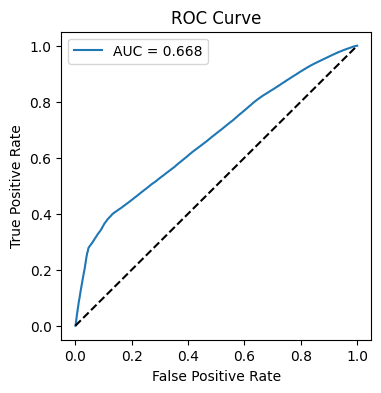

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06
11  model12   0.115301 -725334.009002  1.450758e+06  1.451312e+06
12  model13   0.115376 -725272.052015  1.450620e+06  1.451088e+06
13  model14   0.115440 -725219.792505  1.450524e+06  1.451040e+06
14  model15   0.120937 -720713.081888  1.441506e+06  1.441998e+06

In [ ]:
# Go back to previous model (model10), add IS_WEEKEND * BEFORE COVID * Involved Vehicle
model15 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND * BEFORE_COVID * Involved_Vehicle_Category + CRASH_MONTH + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME")\
    + Environment_Roadway\
    + Is_Sedan + Is_Motorcycle_Scooter + Is_Public + Is_Other + Is_Emergency + Is_Coupe + Is_Bicycle + Is_Personal_Mobility\
    + Driver_Behavior + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model15)
evaluation(model15)
results_table


Optimization terminated successfully.
         Current function value: 0.442918
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626413
Method:                           MLE   Df Model:                           40
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1213
Time:                        18:21:21   Log-Likelihood:            -7.2039e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------

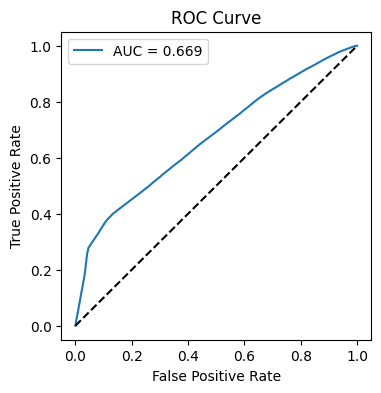

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06
11  model12   0.115301 -725334.009002  1.450758e+06  1.451312e+06
12  model13   0.115376 -725272.052015  1.450620e+06  1.451088e+06
13  model14   0.115440 -725219.792505  1.450524e+06  1.451040e+06
14  model15   0.120937 -720713.081888  1.441506e+06  1.441998e+06
15  model16   0.121335 -720386.400514  1.440855e+06  1.441359e+06

In [ ]:
results_table = results_table[results_table['Model'] != 'model16']
# Add Sedan * Motorcycle
model16 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND * BEFORE_COVID * Involved_Vehicle_Category + CRASH_MONTH + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME")\
    + Environment_Roadway\
    + Is_Sedan * Is_Motorcycle_Scooter + Is_Public + Is_Other + Is_Emergency + Is_Coupe + Is_Bicycle + Is_Personal_Mobility\
    + Driver_Behavior + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model16)
evaluation(model16)
results_table

In [ ]:
lr_test(model15, model16)

LR: 653.3627480571158, DF: 1.0, p_value: 4.1474638905571715e-144
p_value <= 0.05


Optimization terminated successfully.
         Current function value: 0.442909
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626412
Method:                           MLE   Df Model:                           41
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1214
Time:                        18:21:25   Log-Likelihood:            -7.2037e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------

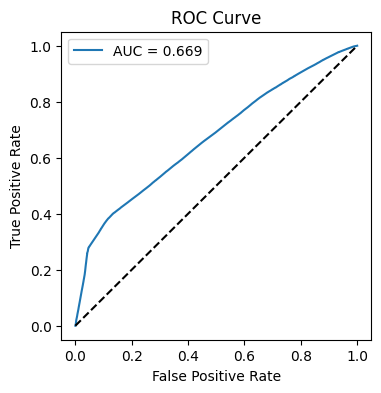

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06
11  model12   0.115301 -725334.009002  1.450758e+06  1.451312e+06
12  model13   0.115376 -725272.052015  1.450620e+06  1.451088e+06
13  model14   0.115440 -725219.792505  1.450524e+06  1.451040e+06
14  model15   0.120937 -720713.081888  1.441506e+06  1.441998e+06
15  model16   0.121335 -720386.400514  1.440855e+06  1.441359e+06
16  model17   0.121354 -720371.383244  1.440827e+06  1.441343e+06

In [ ]:
# Add Motorcycle * Bicycle
model17 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND * BEFORE_COVID * Involved_Vehicle_Category + CRASH_MONTH + IS_HOLIDAY\
    +Q("AVG TRAFFIC VOLUME")\
    + Environment_Roadway\
    + Is_Sedan * Is_Motorcycle_Scooter + Is_Public + Is_Other + Is_Emergency + Is_Coupe + Is_Bicycle * Is_Motorcycle_Scooter + Is_Personal_Mobility\
    + Driver_Behavior + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model17)
evaluation(model17)
results_table

In [ ]:
lr_test(model16, model17)

LR: 30.03454060293734, DF: 1.0, p_value: 4.244186211276929e-08
p_value <= 0.05


Optimization terminated successfully.
         Current function value: 0.442766
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626409
Method:                           MLE   Df Model:                           44
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1216
Time:                        18:21:30   Log-Likelihood:            -7.2014e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------

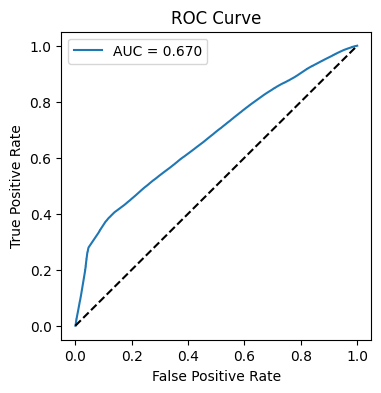

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06
11  model12   0.115301 -725334.009002  1.450758e+06  1.451312e+06
12  model13   0.115376 -725272.052015  1.450620e+06  1.451088e+06
13  model14   0.115440 -725219.792505  1.450524e+06  1.451040e+06
14  model15   0.120937 -720713.081888  1.441506e+06  1.441998e+06
15  model16   0.121335 -720386.400514  1.440855e+06  1.441359e+06
16  model17   0.121354 -720371.383244  1.440827e+06  1.441343e+06
17  model18   0.121638 -720138.400417  1.440367e+06  1.440920e+06

In [ ]:
# Add Busy hour * Involved Vehicle?
model18 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN + VISION_BLOCK\
    + IS_WEEKEND * BEFORE_COVID * Involved_Vehicle_Category + CRASH_MONTH + IS_HOLIDAY\
    + Q("BUSY HOUR") * Involved_Vehicle_Category \
    +Q("AVG TRAFFIC VOLUME")\
    + Environment_Roadway\
    + Is_Sedan * Is_Motorcycle_Scooter + Is_Public + Is_Other + Is_Emergency + Is_Coupe + Is_Bicycle * Is_Motorcycle_Scooter + Is_Personal_Mobility\
    + Driver_Behavior + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model18)
evaluation(model18)
results_table

In [ ]:
lr_test(model17, model18)

LR: 465.9656536914408, DF: 3.0, p_value: 1.1321135447806458e-100
p_value <= 0.05


Optimization terminated successfully.
         Current function value: 0.441608
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626399
Method:                           MLE   Df Model:                           54
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1239
Time:                        18:21:36   Log-Likelihood:            -7.1826e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------

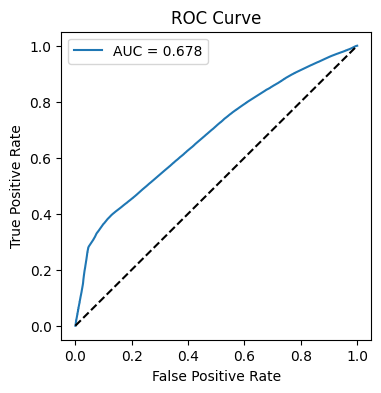

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06
11  model12   0.115301 -725334.009002  1.450758e+06  1.451312e+06
12  model13   0.115376 -725272.052015  1.450620e+06  1.451088e+06
13  model14   0.115440 -725219.792505  1.450524e+06  1.451040e+06
14  model15   0.120937 -720713.081888  1.441506e+06  1.441998e+06
15  model16   0.121335 -720386.400514  1.440855e+06  1.441359e+06
16  model17   0.121354 -720371.383244  1.440827e+06  1.441343e+06
17  model18   0.121638 -720138.400417  1.440367e+06  1.440920e+06
18  model19   0.123935 -718255.171607  1.436620e+06  1.437297e+06

In [ ]:
# Interaction between Vehicle Type
model19 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN\
    + VISION_BLOCK\
    + IS_WEEKEND * Involved_Vehicle_Category * BEFORE_COVID \
    + CRASH_MONTH\
    + IS_HOLIDAY\
    + Q("AVG TRAFFIC VOLUME")\
    + Q("BUSY HOUR") * Involved_Vehicle_Category\
    + Q("AVG TRAFFIC VOLUME") * Driver_Behavior \
    + Q("AVG TRAFFIC VOLUME") * Driver_Distraction\
    + Is_Sedan * Is_Motorcycle_Scooter\
    + Is_Motorcycle_Scooter * Is_Bicycle\
    + Is_Public\
    + Is_Truck_Van\
    + Is_Motorcycle_Scooter * Driver_Distraction + Is_Motorcycle_Scooter * Driver_Behavior + Is_Motorcycle_Scooter * Driver_Impairment + Is_Motorcycle_Scooter * Environment_Roadway\
    + Is_Other + Is_Emergency + Is_Coupe\
    + Is_Bicycle * Driver_Distraction + Is_Bicycle * Driver_Behavior + Is_Bicycle * Driver_Impairment\
    + Is_Personal_Mobility\
    + Driver_Behavior + Environment_Roadway + Driver_Distraction + Driver_Distraction + Driver_Impairment',
    data=train_df
).fit()
add_model(model19)
evaluation(model19)
results_table

## Backward: remove one by one to see what's redundant

Optimization terminated successfully.
         Current function value: 0.441608
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626399
Method:                           MLE   Df Model:                           54
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1239
Time:                        18:21:42   Log-Likelihood:            -7.1826e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------

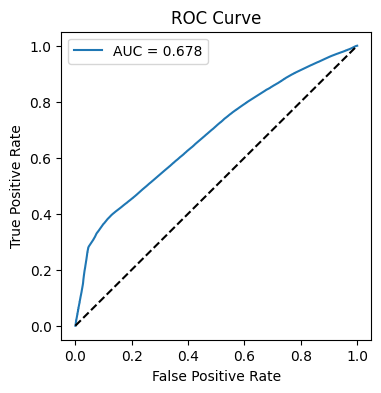

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06
11  model12   0.115301 -725334.009002  1.450758e+06  1.451312e+06
12  model13   0.115376 -725272.052015  1.450620e+06  1.451088e+06
13  model14   0.115440 -725219.792505  1.450524e+06  1.451040e+06
14  model15   0.120937 -720713.081888  1.441506e+06  1.441998e+06
15  model16   0.121335 -720386.400514  1.440855e+06  1.441359e+06
16  model17   0.121354 -720371.383244  1.440827e+06  1.441343e+06
17  model18   0.121638 -720138.400417  1.440367e+06  1.440920e+06
18  model19   0.123935 -718255.171607  1.436620e+06  1.437297e+06
19  model20   0.123935 -718255.171607  1.436620e+06  1.437297e+06

In [ ]:
# Remove Q("BUSY HOUR") * Involved_Vehicle_Category
model20 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN\
    + VISION_BLOCK\
    + IS_WEEKEND * Involved_Vehicle_Category * BEFORE_COVID \
    + CRASH_MONTH\
    + IS_HOLIDAY\
    + Q("AVG TRAFFIC VOLUME")\
    + Involved_Vehicle_Category\
    + Q("BUSY HOUR") * Involved_Vehicle_Category\
    + Q("AVG TRAFFIC VOLUME") * Driver_Behavior \
    + Q("AVG TRAFFIC VOLUME") * Driver_Distraction\
    + Is_Sedan * Is_Motorcycle_Scooter\
    + Is_Motorcycle_Scooter * Is_Bicycle\
    + Is_Public\
    + Is_Truck_Van\
    + Is_Motorcycle_Scooter * Driver_Distraction + Is_Motorcycle_Scooter * Driver_Behavior + Is_Motorcycle_Scooter * Driver_Impairment + Is_Motorcycle_Scooter * Environment_Roadway\
    + Is_Other + Is_Emergency + Is_Coupe\
    + Is_Bicycle * Driver_Distraction + Is_Bicycle * Driver_Behavior + Is_Bicycle * Driver_Impairment\
    + Is_Personal_Mobility',
    data=train_df
).fit()
add_model(model20)
evaluation(model20)
results_table

In [ ]:
lr_test(model20, model19)

LR: -0.0, DF: 0.0, p_value: nan
p_value > 0.05


==> keep

Optimization terminated successfully.
         Current function value: 0.441621
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626400
Method:                           MLE   Df Model:                           53
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1239
Time:                        18:21:47   Log-Likelihood:            -7.1828e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------

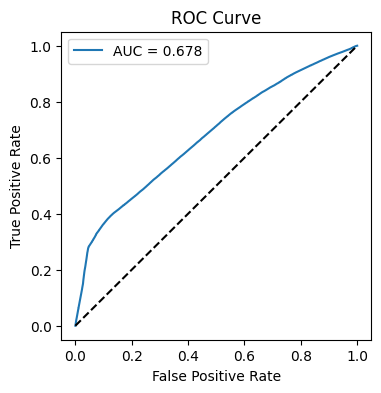

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06
11  model12   0.115301 -725334.009002  1.450758e+06  1.451312e+06
12  model13   0.115376 -725272.052015  1.450620e+06  1.451088e+06
13  model14   0.115440 -725219.792505  1.450524e+06  1.451040e+06
14  model15   0.120937 -720713.081888  1.441506e+06  1.441998e+06
15  model16   0.121335 -720386.400514  1.440855e+06  1.441359e+06
16  model17   0.121354 -720371.383244  1.440827e+06  1.441343e+06
17  model18   0.121638 -720138.400417  1.440367e+06  1.440920e+06
18  model19   0.123935 -718255.171607  1.436620e+06  1.437297e+06
19  model20   0.123935 -718255.171607  1.436620e+06  1.437297e+06
20  model21   0.123908 -718277.046839  1.436662e+06  1.437326e+06

In [ ]:
#Remove AVG Traffic Volume * Driver Behavior
model21 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN\
    + VISION_BLOCK\
    + IS_WEEKEND * Involved_Vehicle_Category * BEFORE_COVID \
    + CRASH_MONTH\
    + IS_HOLIDAY\
    + Q("AVG TRAFFIC VOLUME")\
    + Involved_Vehicle_Category\
    + Q("BUSY HOUR") * Involved_Vehicle_Category\
    + Q("AVG TRAFFIC VOLUME") * Driver_Distraction\
    + Is_Sedan * Is_Motorcycle_Scooter\
    + Is_Motorcycle_Scooter * Is_Bicycle\
    + Is_Public\
    + Is_Truck_Van\
    + Is_Motorcycle_Scooter * Driver_Distraction + Is_Motorcycle_Scooter * Driver_Behavior + Is_Motorcycle_Scooter * Driver_Impairment + Is_Motorcycle_Scooter * Environment_Roadway\
    + Is_Other + Is_Emergency + Is_Coupe\
    + Is_Bicycle * Driver_Distraction + Is_Bicycle * Driver_Behavior + Is_Bicycle * Driver_Impairment\
    + Is_Personal_Mobility',
    data=train_df
).fit()
add_model(model21)
evaluation(model21)
results_table

In [ ]:
lr_test(model21, model19)

LR: 43.750463211443275, DF: 1.0, p_value: 3.730282215582967e-11
p_value <= 0.05


==> Remove

Optimization terminated successfully.
         Current function value: 0.441622
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626401
Method:                           MLE   Df Model:                           52
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1239
Time:                        18:21:53   Log-Likelihood:            -7.1828e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------

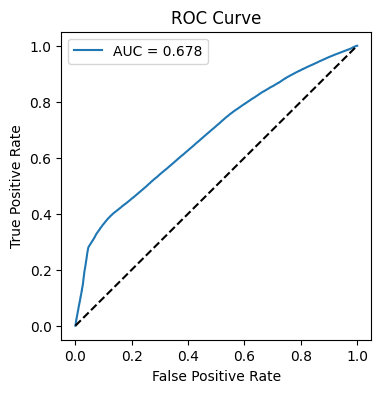

In [ ]:
# Remove AVG Traffic Volume * Driver Distraction
model22 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN\
    + VISION_BLOCK\
    + IS_WEEKEND * Involved_Vehicle_Category * BEFORE_COVID \
    + CRASH_MONTH\
    + IS_HOLIDAY\
    + Q("AVG TRAFFIC VOLUME")\
    + Q("BUSY HOUR") * Involved_Vehicle_Category\
    + Is_Sedan * Is_Motorcycle_Scooter\
    + Is_Motorcycle_Scooter * Is_Bicycle\
    + Is_Public\
    + Is_Truck_Van\
    + Is_Motorcycle_Scooter * Driver_Distraction + Is_Motorcycle_Scooter * Driver_Behavior + Is_Motorcycle_Scooter * Driver_Impairment + Is_Motorcycle_Scooter * Environment_Roadway\
    + Is_Other + Is_Emergency + Is_Coupe\
    + Is_Bicycle * Driver_Distraction + Is_Bicycle * Driver_Behavior + Is_Bicycle * Driver_Impairment\
    + Is_Personal_Mobility',
    data=train_df
).fit()
add_model(model22)
evaluation(model22)

In [ ]:
lr_test(model22, model19)

LR: 46.301652126945555, DF: 2.0, p_value: 8.825188474381451e-11
p_value <= 0.05


Optimization terminated successfully.
         Current function value: 0.441643
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626403
Method:                           MLE   Df Model:                           50
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1239
Time:                        18:21:58   Log-Likelihood:            -7.1831e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------

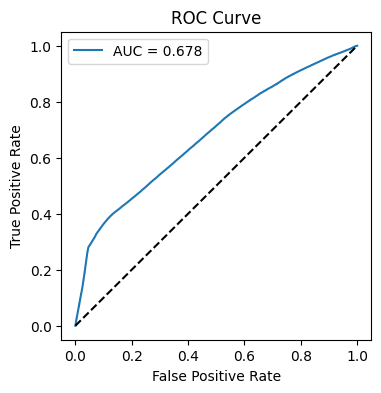

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06
11  model12   0.115301 -725334.009002  1.450758e+06  1.451312e+06
12  model13   0.115376 -725272.052015  1.450620e+06  1.451088e+06
13  model14   0.115440 -725219.792505  1.450524e+06  1.451040e+06
14  model15   0.120937 -720713.081888  1.441506e+06  1.441998e+06
15  model16   0.121335 -720386.400514  1.440855e+06  1.441359e+06
16  model17   0.121354 -720371.383244  1.440827e+06  1.441343e+06
17  model18   0.121638 -720138.400417  1.440367e+06  1.440920e+06
18  model19   0.123935 -718255.171607  1.436620e+06  1.437297e+06
19  model20   0.123935 -718255.171607  1.436620e+06  1.437297e+06
20  model21   0.123908 -718277.046839  1.436662e+06  1.437326e+06
21  model22   0.123907 -718278.322433  1.436663e+06  1.437315e+06
22  model23   0.123866 -718311.514036  1.436725e+06  1.437352e+06

In [ ]:
# Model 22 and remove Is_Personal_Mobility
model23 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN\
    + VISION_BLOCK\
    + IS_WEEKEND * Involved_Vehicle_Category * BEFORE_COVID \
    + CRASH_MONTH\
    + IS_HOLIDAY\
    + Q("AVG TRAFFIC VOLUME")\
    + Q("BUSY HOUR") * Involved_Vehicle_Category\
    + Is_Sedan * Is_Motorcycle_Scooter\
    + Is_Motorcycle_Scooter * Is_Bicycle\
    + Is_Public\
    + Is_Truck_Van\
    + Is_Motorcycle_Scooter * Driver_Distraction  + Is_Motorcycle_Scooter * Driver_Impairment \
    + Environment_Roadway * PRCP\
    + Driver_Behavior\
    + Vehicle_Defect\
    + Is_Other + Is_Emergency + Is_Coupe\
    + Is_Bicycle * Driver_Distraction',
    data=train_df
).fit()
add_model(model23)
evaluation(model23)
results_table

In [ ]:
lr_test(model23, model22)

LR: 66.38320618658327, DF: 2.0, p_value: 3.8465371485309044e-15
p_value <= 0.05


Optimization terminated successfully.
         Current function value: 0.441672
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626408
Method:                           MLE   Df Model:                           45
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1238
Time:                        18:22:02   Log-Likelihood:            -7.1836e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------

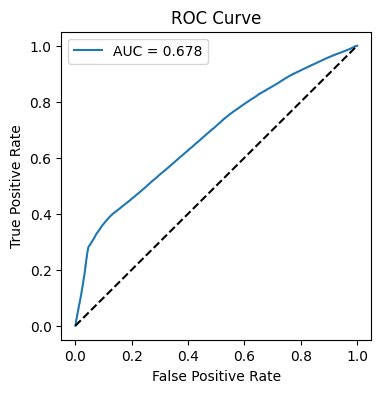

Model  Pseudo_R2  LogLikelihood           AIC           BIC
0    model1   0.000865 -819155.911776  1.638320e+06  1.638369e+06
1    model2   0.001270 -818823.392265  1.637681e+06  1.637890e+06
2    model3   0.007219 -813946.375051  1.627933e+06  1.628179e+06
3    model4   0.049222 -779509.294027  1.559063e+06  1.559333e+06
4    model5   0.049225 -779507.351751  1.559061e+06  1.559344e+06
5    model6   0.111922 -728104.364344  1.456271e+06  1.456652e+06
6    model7   0.115242 -725381.869852  1.450832e+06  1.451250e+06
7    model8   0.115237 -725385.977376  1.450838e+06  1.451244e+06
8    model9   0.115236 -725386.885101  1.450838e+06  1.451231e+06
9   model10   0.115244 -725380.499876  1.450829e+06  1.451247e+06
10  model11   0.115292 -725340.987431  1.450752e+06  1.451183e+06
11  model12   0.115301 -725334.009002  1.450758e+06  1.451312e+06
12  model13   0.115376 -725272.052015  1.450620e+06  1.451088e+06
13  model14   0.115440 -725219.792505  1.450524e+06  1.451040e+06
14  model15   0.120937 -720713.081888  1.441506e+06  1.441998e+06
15  model16   0.121335 -720386.400514  1.440855e+06  1.441359e+06
16  model17   0.121354 -720371.383244  1.440827e+06  1.441343e+06
17  model18   0.121638 -720138.400417  1.440367e+06  1.440920e+06
18  model19   0.123935 -718255.171607  1.436620e+06  1.437297e+06
19  model20   0.123935 -718255.171607  1.436620e+06  1.437297e+06
20  model21   0.123908 -718277.046839  1.436662e+06  1.437326e+06
21  model22   0.123907 -718278.322433  1.436663e+06  1.437315e+06
22  model23   0.123866 -718311.514036  1.436725e+06  1.437352e+06
23  model24   0.123807 -718359.776484  1.436812e+06  1.437377e+06

In [ ]:
# Model 23 and remove some intuitive cross interactions and Is_Personal_Mobility due to p-value <0.05
model24 = smf.logit(
    formula='is_injured ~ BELOW_FREEZING + SNOW_ACCUM_2_IN\
    + VISION_BLOCK\
    + IS_WEEKEND * Involved_Vehicle_Category * BEFORE_COVID \
    + CRASH_MONTH\
    + IS_HOLIDAY\
    + Q("AVG TRAFFIC VOLUME")\
    + Q("BUSY HOUR") * Involved_Vehicle_Category\
    + Is_Sedan * Is_Motorcycle_Scooter\
    + Is_Motorcycle_Scooter * Is_Bicycle\
    + Is_Public\
    + Is_Truck_Van\
    + Environment_Roadway\
    + Is_Other + Is_Emergency + Is_Coupe\
    + Vehicle_Defect\
    + Driver_Distraction\
    + Driver_Behavior\
    + Driver_Impairment',
    data=train_df
).fit()
add_model(model24)
evaluation(model24)
results_table

In [ ]:
lr_test(model24, model23)

LR: 96.52489650645293, DF: 5.0, p_value: 2.8516058259244487e-19
p_value <= 0.05


## Diagnostics

In [ ]:
model24.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_injured   No. Observations:              1626454
Model:                          Logit   Df Residuals:                  1626408
Method:                           MLE   Df Model:                           45
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1238
Time:                        18:22:03   Log-Likelihood:            -7.1836e+05
converged:                       True   LL-Null:                   -8.1986e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================================================================
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  -1.0300      0.019    -54.619      0.000      -1.067      -0.993
BELOW_FREEZING[T.True]                                                     -0.0647      0.009     -7.020      0.000      -0.083      -0.047
SNOW_ACCUM_2_IN[T.True]                                                    -0.1026      0.011     -9.382      0.000      -0.124      -0.081
VISION_BLOCK[T.True]                                                        0.0228      0.004      5.240      0.000       0.014       0.031
IS_WEEKEND[T.True]                                                         -0.0933      0.029     -3.235      0.001      -0.150      -0.037
Involved_Vehicle_Category[T.2]                                              0.1477      0.019      7.735      0.000       0.110       0.185
Involved_Vehicle_Category[T.>2]                                             0.9030      0.028     32.333      0.000       0.848       0.958
BEFORE_COVID[T.True]                                                        0.5751      0.016     36.537      0.000       0.544       0.606
CRASH_MONTH[T.2]                                                           -0.0218      0.011     -1.924      0.054      -0.044       0.000
CRASH_MONTH[T.3]                                                           -0.0536      0.011     -4.841      0.000      -0.075      -0.032
CRASH_MONTH[T.4]                                                           -0.0347      0.011     -3.046      0.002      -0.057      -0.012
CRASH_MONTH[T.5]                                                           -0.0130      0.012     -1.120      0.263      -0.036       0.010
CRASH_MONTH[T.6]                                                           -0.0045      0.011     -0.406      0.685      -0.026       0.017
CRASH_MONTH[T.7]                                                           -0.0192      0.011     -1.738      0.082      -0.041       0.002
CRASH_MONTH[T.8]                                                           -0.0159      0.011     -1.433      0.152      -0.038       0.006
CRASH_MONTH[T.9]                                                            0.0143      0.011      1.282      0.200      -0.008       0.036
CRASH_MONTH[T.10]                                                           0.0195      0.011      1.702      0.089      -0.003       0.042
CRASH_MONTH[T.11]                                                           0.0018      0.011      0.165      0.869      -0.020       0.024
CRASH_MONTH[T.12]                                                           0.0211      0.011      1.964      0.050    4.35e-05       0.042
IS_HOLIDAY[T.True]                                                          0.0179      0.008      2.217      0.027       0.002       0.034
Q("BUSY HOUR")[T.True

Confusion matrix:
 [[242989  11791]
 [125040  48603]]
Accuracy: 0.681, Precision: 0.805, Recall: 0.280, F1: 0.415, AUC: 0.678


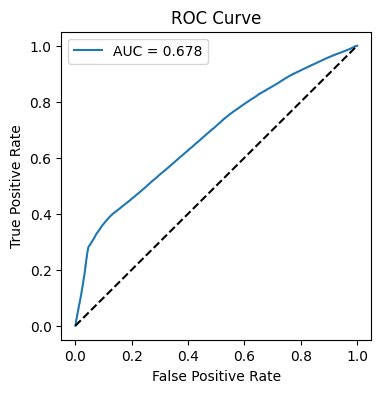

In [ ]:
evaluation(model24)

In [ ]:
test_df.columns

Index(['DAY OF WEEK', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'AWND', 'PRECIP_GT_0.1',
       'BELOW_FREEZING', 'SNOW_ACCUM_2_IN', 'VISION_BLOCK', 'is_injured',
       'IS_WEEKEND', 'CRASH_MONTH', 'AVG TRAFFIC VOLUME', 'BUSY HOUR',
       'IS_HOLIDAY', 'BEFORE_COVID', 'Is_Sedan', 'Is_Motorcycle_Scooter',
       'Is_Truck_Van', 'Is_Public', 'Is_Other', 'Is_Emergency', 'Is_Coupe',
       'Is_Heavy_Industrial', 'Is_Suv_Jeep', 'Is_Bicycle',
       'Is_Personal_Mobility', 'Driver_Behavior', 'Driver_Distraction',
       'Driver_Impairment', 'Environment_Roadway', 'Vehicle_Defect',
       'Involved_Vehicle_Category', 'pred_prob', 'pred_injury'],
      dtype='object')

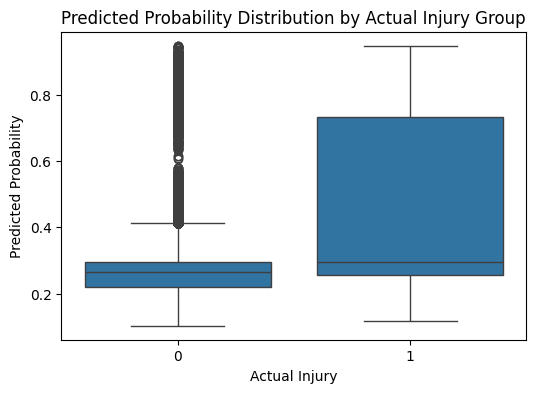

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(
    x=test_df['is_injured'],
    y=test_df['pred_prob']
)
plt.xlabel("Actual Injury")
plt.ylabel("Predicted Probability")
plt.title("Predicted Probability Distribution by Actual Injury Group")
plt.show()

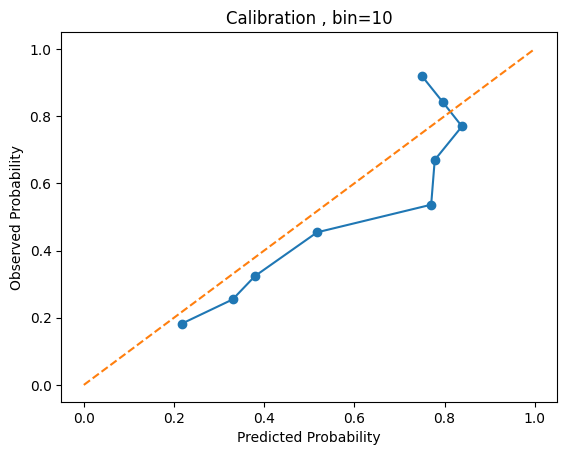

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
    test_df['is_injured'], test_df['pred_prob'], n_bins=10
)

plt.plot(prob_true, prob_pred, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Probability")
plt.title("Calibration , bin=10")
plt.show()


In [ ]:
params = model24.params
conf = model24.conf_int()
conf.columns = ['2.5%', '97.5%']
odds_ratios = np.exp(params)
conf_exp = np.exp(conf)

#odd ratio table
# odd_ratio = exp(beta)
odd_ratio = pd.DataFrame({
    'coef': params,
    'odds_ratio': odds_ratios,
    'CI_lower': conf_exp['2.5%'],
    'CI_upper': conf_exp['97.5%'],
    'p_value': model24.pvalues})

odd_ratio = odd_ratio.reset_index()

odd_ratio['p_value <= 0.05'] = odd_ratio['p_value'] <= 0.05

# percent_change_in_odd
odd_ratio['odd_percent_change'] = odd_ratio['odds_ratio']-1

odd_ratio.to_csv("RQ2_interpretation_table.csv")

odd_ratio.sort_values(by='odds_ratio', ascending=False)


index      coef  odds_ratio  \
23                                 Is_Bicycle[T.True]  3.171742   23.848988   
22                      Is_Motorcycle_Scooter[T.True]  2.067301    7.903463   
6                     Involved_Vehicle_Category[T.>2]  0.903014    2.467028   
7                                BEFORE_COVID[T.True]  0.575129    1.777360   
41     Is_Sedan[T.True]:Is_Motorcycle_Scooter[T.True]  0.525263    1.690904   
33                          Driver_Impairment[T.True]  0.358338    1.430949   
31                         Driver_Distraction[T.True]  0.310189    1.363683   
32                            Driver_Behavior[T.True]  0.293997    1.341779   
44  IS_WEEKEND[T.True]:Involved_Vehicle_Category[T...  0.195856    1.216352   
34  IS_WEEKEND[T.True]:Involved_Vehicle_Category[T.2]  0.151995    1.164155   
5                      Involved_Vehicle_Category[T.2]  0.147726    1.159195   
20                             Q("BUSY HOUR")[T.True]  0.135331    1.144916   
43  IS_WEEKEND[T.True]:Involved_Vehicle_Category[T...  0.130975    1.139939   
26                        Environment_Roadway[T.True]  0.094716    1.099347   
3                                VISION_BLOCK[T.True]  0.022819    1.023081   
18                                  CRASH_MONTH[T.12]  0.021104    1.021329   
16                                  CRASH_MONTH[T.10]  0.019510    1.019702   
19                                 IS_HOLIDAY[T.True]  0.017914    1.018076   
15                                   CRASH_MONTH[T.9]  0.014268    1.014370   
17                                  CRASH_MONTH[T.11]  0.001832    1.001834   
45                            Q("AVG TRAFFIC VOLUME") -0.000111    0.999889   
12                                   CRASH_MONTH[T.6] -0.004492    0.995518   
11                                   CRASH_MONTH[T.5] -0.012953    0.987131   
14                                   CRASH_MONTH[T.8] -0.015905    0.984221   
13                                   CRASH_MONTH[T.7] -0.019214    0.980970   
8                                    CRASH_MONTH[T.2] -0.021760    0.978475   
10                                   CRASH_MONTH[T.4] -0.034690    0.965904   
9                                    CRASH_MONTH[T.3] -0.053591    0.947819   
30                             Vehicle_Defect[T.True] -0.063427    0.938542   
1                              BELOW_FREEZING[T.True] -0.064739    0.937312   
35  IS_WEEKEND[T.True]:Involved_Vehicle_Category[T... -0.076135    0.926691   
36            IS_WEEKEND[T.True]:BEFORE_COVID[T.True] -0.083674    0.919731   
4                                  IS_WEEKEND[T.True] -0.093255    0.910961   
2                             SNOW_ACCUM_2_IN[T.True] -0.102628    0.902463   
40  Q("BUSY HOUR")[T.True]:Involved_Vehicle_Catego... -0.103099    0.902037   
27                                   Is_Other[T.True] -0.144771    0.865220   
29                                   Is_Coupe[T.True] -0.159540    0.852536   
24                                  Is_Public[T.True] -0.211013    0.809764   
39  Q("BUSY HOUR")[T.True]:Involved_Vehicle_Catego... -0.221260    0.801508   
21                                   Is_Sedan[T.True] -0.283317    0.753281   
25                               Is_Truck_Van[T.True] -0.441883    0.642825   
28                               Is_Emergency[T.True] -0.594228    0.551988   
38  Involved_Vehicle_Category[T.>2]:BEFORE_COVID[T... -0.889004    0.411065   
0                                           Intercept -1.029975    0.357016   
37  Involved_Vehicle_Category[T.2]:BEFORE_COVID[T.... -1.546516    0.212989   
42   Is_Motorcycle_Scooter[T.True]:Is_Bicycle[T.True] -2.079422    0.125002   

     CI_lower   CI_upper        p_value  p_value <= 0.05  odd_percent_change  
23  22.936965  24.797275   0.000000e+00             True           22.848988  
22   7.639927   8.176089   0.000000e+00             True            6.903463  
6    2.335616   2.605833  2.383324e-229             True            1.467028  
7    1.723363   1.

## Further tuning

Using iscost line from the link www0.cs.ucl.ac.uk/staff/W.Langdon/roc. Using these concept:

alpha = cost_false_positive = cost of a false positive (false alarm)
beta = cost_false_negative = cost of missing a positive (false negative)

p = proportion of positive cases

Then the average expected cost of classification at point x,y in the ROC space is C = (1-p) alpha x + p beta (1-y).
To find the best threshold you have to minimize C so :

best_threshold = argmin ( (1-p) alpha x + p beta (1-y) ).

In [ ]:
def find_best_threshold(y_true, y_prob, alpha=1, beta=1):
    """
    alpha = cost of false positive
    beta  = cost of false negative
    """
    # ROC points
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    # Prevalence (proportion of positives)
    p = y_true.mean()
    # Expected cost for each threshold
    # C = (1 - p) * alpha * FPR + p * beta * (1 - TPR)
    cost = (1 - p) * alpha * fpr + p * beta * (1 - tpr)
    # Best threshold = threshold with minimum cost
    best_idx = np.argmin(cost)
    best_threshold = thresholds[best_idx]
    return {
        "best_threshold": best_threshold,
        "best_cost": cost[best_idx],
        "fpr": fpr[best_idx],
        "tpr": tpr[best_idx],
        "thresholds": thresholds,
        "cost_array": cost
    }

result = find_best_threshold(
    y_true=test_df["is_injured"],
    y_prob=test_df["pred_prob"],
    alpha=1,     # cost of false positive
    beta=5       # cost of false negative (usually worse)
)

print("Best threshold:", result["best_threshold"])
print("Cost at best threshold:", result["best_cost"])
print("FPR:", result["fpr"])
print("TPR:", result["tpr"])

Best threshold: 0.14570348288686888
Cost at best threshold: 0.5942981585955937
FPR: 0.9968050867415025
TPR: 0.9992570964565228


In [ ]:
# Change threshold
def evaluation_tune(model_name, threshold):
    test_df['pred_prob'] = model_name.predict(test_df)
    test_df['pred_injury'] = (test_df['pred_prob'] >= threshold).astype(int)
    y_true = test_df['is_injured']
    y_pred = test_df['pred_injury']
    y_prob = test_df['pred_prob']

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)

    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve, threshold = {threshold}')
    plt.legend()
    plt.show()

Confusion matrix:
 [[ 26156 228624]
 [  7275 166368]]
Accuracy: 0.449, Precision: 0.421, Recall: 0.958, F1: 0.585, AUC: 0.678


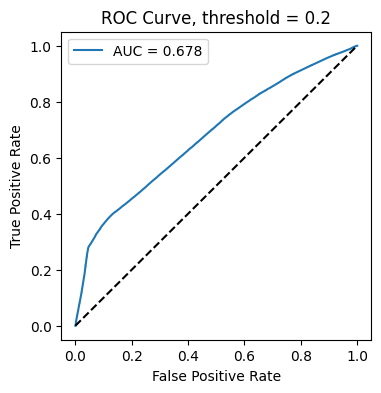

In [ ]:
evaluation_tune(model24, 0.2)

Confusion matrix:
 [[201615  53165]
 [ 93701  79942]]
Accuracy: 0.657, Precision: 0.601, Recall: 0.460, F1: 0.521, AUC: 0.678


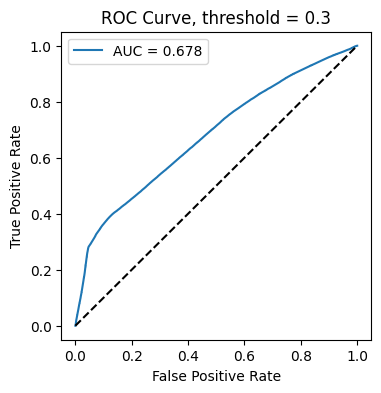

In [ ]:
evaluation_tune(model24, 0.3)

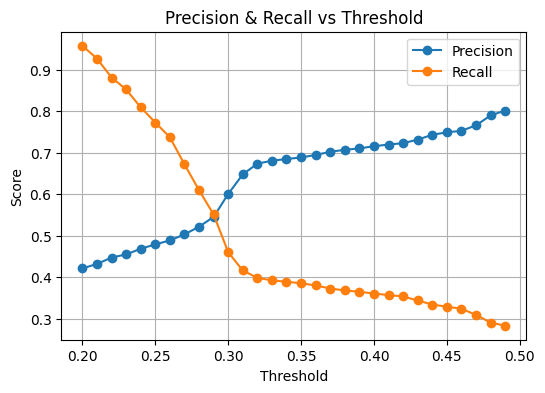

In [ ]:
thresholds=np.arange(0.2, 0.5, 0.01)
probs = model24.predict(test_df)
y_true = test_df['is_injured']

precision_list = []
recall_list = []
fpr_list = []
fnr_list = []

for t in thresholds:
    preds = (probs >= t).astype(int)

    precision_list.append(precision_score(y_true, preds))
    recall_list.append(recall_score(y_true, preds))

    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    fpr_list.append(fpr)
    fnr_list.append(fnr)

plt.figure(figsize=(6,4))
plt.plot(thresholds, precision_list, marker='o', label='Precision')
plt.plot(thresholds, recall_list, marker='o', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_thresh_precision = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision_list,
    "recall": recall_list
})

In [ ]:
df_thresh_precision

threshold  precision    recall
0        0.20   0.421193  0.958104
1        0.21   0.432002  0.926931
2        0.22   0.447351  0.881423
3        0.23   0.454974  0.852629
4        0.24   0.468608  0.809563
5        0.25   0.479169  0.772988
6        0.26   0.488674  0.737369
7        0.27   0.503219  0.672103
8        0.28   0.521665  0.610010
9        0.29   0.545357  0.551281
10       0.30   0.600584  0.460381
11       0.31   0.647855  0.416233
12       0.32   0.673753  0.398409
13       0.33   0.680891  0.392541
14       0.34   0.684941  0.388959
15       0.35   0.688731  0.385538
16       0.36   0.694767  0.380130
17       0.37   0.702394  0.372759
18       0.38   0.707149  0.368083
19       0.39   0.710565  0.364852
20       0.40   0.715731  0.360654
21       0.41   0.719888  0.357003
22       0.42   0.723089  0.353576
23       0.43   0.731704  0.343866
24       0.44   0.743379  0.334151
25       0.45   0.749269  0.328945
26       0.46   0.752918  0.323900
27       0.47   0.766149  0.309278
28       0.48   0.789890  0.290567
29       0.49   0.801925  0.283029

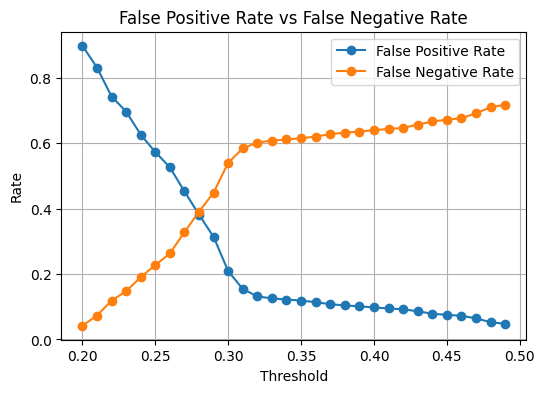

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(thresholds, fpr_list, marker='o', label='False Positive Rate')
plt.plot(thresholds, fnr_list, marker='o', label='False Negative Rate')
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("False Positive Rate vs False Negative Rate")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
threshold_df = pd.DataFrame({
    "threshold": thresholds,
    "fpr": fpr_list,
    "fnr": fnr_list
})

In [ ]:
threshold_df

threshold       fpr       fnr
0        0.20  0.897339  0.041896
1        0.21  0.830615  0.073069
2        0.22  0.742127  0.118577
3        0.23  0.696118  0.147371
4        0.24  0.625673  0.190437
5        0.25  0.572627  0.227012
6        0.26  0.525842  0.262631
7        0.27  0.452206  0.327897
8        0.28  0.381215  0.389990
9        0.29  0.313223  0.448719
10       0.30  0.208670  0.539619
11       0.31  0.154196  0.583767
12       0.32  0.131482  0.601591
13       0.33  0.125383  0.607459
14       0.34  0.121937  0.611041
15       0.35  0.118753  0.614462
16       0.36  0.113820  0.619870
17       0.37  0.107642  0.627241
18       0.38  0.103890  0.631917
19       0.39  0.101287  0.635148
20       0.40  0.097625  0.639346
21       0.41  0.094674  0.642997
22       0.42  0.092284  0.646424
23       0.43  0.085933  0.656134
24       0.44  0.078617  0.665849
25       0.45  0.075022  0.671055
26       0.46  0.072443  0.676100
27       0.47  0.064338  0.690722
28       0.48  0.052677  0.709433
29       0.49  0.047645  0.716971

Confusion matrix:
 [[157654  97126]
 [ 67719 105924]]
Accuracy: 0.615, Precision: 0.522, Recall: 0.610, F1: 0.562, AUC: 0.678


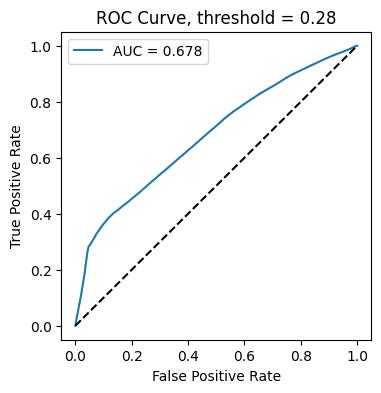

In [ ]:
evaluation_tune(model24, 0.28)